In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
import numpy as np
import random
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras import layers
from keras.models import Sequential
 
from matplotlib import pyplot
import matplotlib.pyplot as plt

In [33]:
def load_real_samples():
  (trainX, _), (_, _) = load_data()
  X = trainX.astype('float32')
  X = (X - 127.5) / 127.5
  return X

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(32, 32, 3)


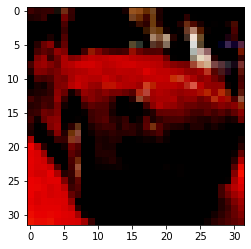

In [34]:
dataset = load_real_samples()
plt.imshow(dataset[5])
print(dataset[50].shape)


In [35]:
# define the standalone generator model
def define_generator(latent_dim=100):
  model = Sequential()
  n_nodes = 256 * 4 * 4
  model.add(layers.Dense(n_nodes, input_dim=latent_dim))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Reshape((4, 4, 256)))
  model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Conv2D(3, (3,3), activation='tanh', padding='same'))
  return model

In [36]:
def generate_latent_points(latent_dim, n_samples):
	x_input = randn(latent_dim * n_samples)
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


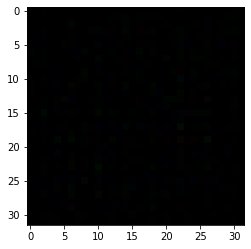

In [37]:
generator = define_generator(100)
noise = generate_latent_points(100,1)
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0])

In [38]:
def define_discriminator(in_shape=(32,32,3)):
  model = Sequential()
  model.add(layers.Conv2D(64, (3,3), padding='same', input_shape=in_shape))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Conv2D(256, (3,3), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Flatten())
  model.add(layers.Dropout(0.4))
  model.add(layers.Dense(1, activation='sigmoid'))

  opt = Adam(1e-4)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [39]:
discriminator = define_discriminator()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.4998059]], shape=(1, 1), dtype=float32)


In [40]:
def define_gan(g_model, d_model):
  d_model.trainable = False
  model = Sequential()
  model.add(g_model)
  model.add(d_model)
  opt = Adam(1e-4)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

In [41]:
gan = define_gan(generator, discriminator)
noise = generate_latent_points(100,1)
decision = gan(noise)
print (decision)

tf.Tensor([[0.49980706]], shape=(1, 1), dtype=float32)


In [42]:
def generate_real_samples(dataset, n_samples, w):
	# ix = randint(0, dataset.shape[0], n_samples)
	ix = np.random.choice(dataset.shape[0], n_samples, w)
	X = dataset[ix]
	noise = np.random.normal(0,.0001,X.shape)
	X += noise
	y = ones((n_samples, 1))*.9
	return X, y

In [43]:
def generate_fake_samples(g_model, latent_dim, n_samples):
	x_input = generate_latent_points(latent_dim, n_samples)
	X = g_model.predict(x_input)
	noise = np.random.normal(0,.0001,X.shape)
	X += noise
	y = ones((n_samples, 1))*.1
	return X, y

In [44]:
# def save_plot(examples, epoch, modelnumber, n=10, adagan =''):
# 	examples = (examples + 1) / 2.0
# 	for i in range(n * n):
# 		pyplot.subplot(n, n, 1 + i)
# 		pyplot.axis('off')
# 		pyplot.imshow(examples[i, :, :, 0], cmap='gray')
	
# 	filename = '/content/drive/My Drive/Colab Notebooks/DL/Project/generated_plot{0}_m{1:03}_e{2:03}.png'.format(adagan, modelnumber , (epoch+1))
# 	print(filename)
# 	pyplot.savefig(filename)
# 	pyplot.close()
def save_plot(examples, epoch, modelnumber, n=10, adagan =''):
	examples = (examples + 1) / 2.0
	for i in range(n * n):
		pyplot.subplot(n, n, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(examples[i])
	filename = '/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot{0}_m{1:03}_e{2:03}.png'.format(adagan, modelnumber , (epoch+1))
	print(filename)
	pyplot.savefig(filename)
	pyplot.close()

	# examples = (examples + 1) / 2.0
	# for i in range(n * n):
	# 	plt.subplot(n, n, 1 + i)
	# 	plt.axis('off')
	# 	plt.imshow(examples[i])
	
	# filename = '/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot{0}_m{1:03}_e{2:03}.png'.format(adagan, modelnumber , (epoch+1))
	# print(filename)
	# plt.savefig(filename)

In [45]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, modelnumber, n_samples=150):
	# X_real, y_real = generate_real_samples(dataset, n_samples)
	# _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	save_plot(x_fake, epoch, modelnumber)
	# filename = 'generator_model_%03d.h5' % (epoch+1)
	# print(filename)
	# g_model.save(filename)

In [46]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, n_batch ,w, modelnumber):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	# bat_per_epo = 20
	half_batch = n_batch

	g_loss_list = []
	d_loss_list = []
	for i in range(n_epochs):
		sd_loss = 0
		sg_loss = 0
		for j in range(bat_per_epo):
			X_real, y_real = generate_real_samples(dataset, half_batch, w)
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			X_gan = generate_latent_points(latent_dim, n_batch)
			y_gan = ones((n_batch, 1))
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			sd_loss += d_loss1+d_loss2
			sg_loss += g_loss
			if (j+1) % 10 == 0:
				print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
					(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		d_loss_list.append(sd_loss)
		g_loss_list.append(sg_loss)
		# if (i+1) % 10 == 0:
		summarize_performance(i, g_model, d_model, dataset, latent_dim, modelnumber)
	
	plt.figure(figsize = (12, 12))
	%config InlineBackend.figure_format ='retina'
	plt.plot(d_loss_list, color = 'm', linewidth = 3, label = 'Discriminator loss')
	plt.plot(g_loss_list, color = 'orangered', linewidth = 3, label = 'Generator loss')
	plt.legend(loc = 'best')
	plt.grid(color = 'black', linestyle = '--', linewidth = 0.4)

	sequence_length = 20
	shift_size = 1

	plt.xlabel('epochs', fontsize = 14)
	plt.ylabel('Loss', fontsize = 14)   
	plt.xticks(fontname = "Times New Roman", fontsize = 14)      
	plt.yticks(fontname = "Times New Roman", fontsize = 14)

	filename = '/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/loss_plot_m%03d.png' % modelnumber
	plt.savefig(filename)



In [47]:
def dcgan(w, modelnumber, latent_dim, n_epochs, n_batch, dataset):
  d_model = define_discriminator()
  g_model = define_generator(latent_dim)
  gan_model = define_gan(g_model, d_model)
  train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, n_batch , w, modelnumber)
  return g_model, d_model


# latent_dim = 8
# n_epochs = 5
# n_batch = 128
# dataset = load_real_samples()
# w = (np.ones(dataset.shape[0])/dataset.shape[0]).tolist()
# g_model, d_model = dcgan(w, 1, latent_dim, n_epochs, n_batch, dataset)

In [48]:
def generate_adagan_fake_samples(g_models, alphas, latent_dim, n_samples):
  ix = np.random.choice(len(g_models), n_samples, alphas).tolist()
  first = True
  for i in range(len(g_models)):
    n_samples_in_g = ix.count(i)
    x_fake, y_fake = generate_fake_samples(g_models[i], latent_dim, n_samples_in_g)
    if first:
      first = False
      x = x_fake
      y = y_fake
    else:
      x = np.append(x,x_fake,0)
      y = np.append(y,y_fake,0)
  return x,y

In [49]:
# g_models = [g_model, g_model]
# alphas = [.5,.5]
# a = generate_adagan_fake_samples(g_models, alphas, 8, 100)


In [50]:
def train_adagan_discriminator(g_models, alphas, d_model, dataset, latent_dim, n_epochs, n_batch, modelnumber):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  # bat_per_epo = 10
  half_batch = n_batch
  w = (np.ones(dataset.shape[0])/dataset.shape[0]).tolist()
  d_loss_list = []
  for i in range(n_epochs):
    sd_loss = 0
    for j in range(bat_per_epo):
      X_real, y_real = generate_real_samples(dataset, half_batch, w)
      d_loss1, _ = d_model.train_on_batch(X_real, y_real)

      X_fake, y_fake = generate_adagan_fake_samples(g_models, alphas, latent_dim, half_batch)
      d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
      sd_loss += d_loss1+d_loss2

      if (j+1) % 10 == 0:
        print('>%d, %d/%d, d1=%.3f, d2=%.3f' %
          (i+1, j+1, bat_per_epo, d_loss1, d_loss2))
    d_loss_list.append(sd_loss)
	
  plt.figure(figsize = (12, 12))
  %config InlineBackend.figure_format ='retina'
  plt.plot(d_loss_list, color = 'm', linewidth = 3, label = 'Discriminator loss')
  plt.legend(loc = 'best')
  plt.grid(color = 'black', linestyle = '--', linewidth = 0.4)

  sequence_length = 20
  shift_size = 1

  plt.xlabel('epochs', fontsize = 14)
  plt.ylabel('Loss', fontsize = 14)   
  plt.xticks(fontname = "Times New Roman", fontsize = 14)      
  plt.yticks(fontname = "Times New Roman", fontsize = 14)

  filename = '/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/loss_adagan_discriminator_plot_m%03d.png' % modelnumber
  plt.savefig(filename)

In [51]:
def adagan_discriminator(g_models, alphas, dataset, latent_dim, n_epochs, n_batch, modelnumber):
  discriminator = define_discriminator()
  train_adagan_discriminator(g_models, alphas, discriminator, dataset, latent_dim, n_epochs, n_batch, modelnumber)
  return discriminator


In [52]:
def sigmoid(x):
    s = 1/(1+np.exp(-x)) 
    return s

In [53]:
def _compute_data_weights_theory_star(beta, ratios, num):
  ratios_sorted = np.sort(ratios)
  cumsum_ratios = np.cumsum(ratios_sorted)
  is_found = False
  for i in range(num):
      _lambda = beta * num * (1. + (1.-beta) / beta \
              / num * cumsum_ratios[i]) / (i + 1.)
      if i == num - 1:
          if _lambda >= (1. - beta) * ratios_sorted[-1]:
              is_found = True
              break
      else:
          if _lambda <= (1 - beta) * ratios_sorted[i + 1] \
                  and _lambda >= (1 - beta) * ratios_sorted[i]:
              is_found = True
              break
  data_weights = np.zeros(num)
  if is_found:
      _lambdamask = ratios <= (_lambda / (1.-beta))
      data_weights[_lambdamask] = (_lambda -
                                    (1-beta)*ratios[_lambdamask]) / num / beta
      data_weights = data_weights / np.sum(data_weights)
      return data_weights
  else:
      data_weights = np.ones(num) / (num + 0.)
      return data_weights

In [ ]:
latent_dim = 8
n_epochs = 40
n_discriminator_epochs = 5
n_batch = 128
dataset = load_real_samples()

g_models = []
alphas = []
T = 10
w = (np.ones(dataset.shape[0])/dataset.shape[0]).tolist()
g_model, d_model = dcgan(w, 1, latent_dim, n_epochs, n_batch, dataset)
g_models.append(g_model)
alphas.append(1)
metric = []
for i in range(2, T):
  beta = 1/i
  discriminator = adagan_discriminator(g_models, alphas, dataset, latent_dim, n_discriminator_epochs, n_batch, 2)
  prob_real_data = discriminator.predict(dataset, batch_size=256)
  prob_real_data = sigmoid(prob_real_data)

  metric.append(np.sum(prob_real_data))


  density_ratios = ((1. - prob_real_data) / (prob_real_data + 1e-8)).flatten()

  w = list(_compute_data_weights_theory_star(beta, density_ratios, dataset.shape[0]))
  

  g_model, d_model = dcgan(w, i, latent_dim, n_epochs, n_batch, dataset)
  g_models.append(g_model)

  tmp = np.array(alphas)
  tmp = tmp * (1 - beta)
  alphas.append(beta)

  X_fake, _ = generate_adagan_fake_samples(g_models, alphas, latent_dim, 150)
  save_plot(X_fake, 0, i, n=10, adagan ='adagan')



plt.figure(figsize = (12, 12))
%config InlineBackend.figure_format ='retina'
plt.plot(metric, color = 'm', linewidth = 3)
plt.legend(loc = 'best')
plt.grid(color = 'black', linestyle = '--', linewidth = 0.4)

filename = '/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/metric.png'
plt.savefig(filename)



>1, 10/390, d1=0.394, d2=0.705 g=0.679
>1, 20/390, d1=0.345, d2=0.711 g=0.682
>1, 30/390, d1=0.344, d2=0.585 g=0.878
>1, 40/390, d1=0.351, d2=0.489 g=1.092
>1, 50/390, d1=0.359, d2=0.477 g=1.116
>1, 60/390, d1=0.358, d2=0.408 g=1.423
>1, 70/390, d1=0.395, d2=0.762 g=0.797
>1, 80/390, d1=0.367, d2=0.332 g=1.944
>1, 90/390, d1=0.357, d2=0.327 g=2.655
>1, 100/390, d1=0.351, d2=0.339 g=2.540
>1, 110/390, d1=0.347, d2=0.353 g=2.561
>1, 120/390, d1=0.391, d2=0.333 g=2.800
>1, 130/390, d1=0.358, d2=0.358 g=2.547
>1, 140/390, d1=0.376, d2=0.386 g=2.811
>1, 150/390, d1=0.421, d2=0.327 g=2.964
>1, 160/390, d1=0.469, d2=0.335 g=2.762
>1, 170/390, d1=0.385, d2=0.327 g=2.833
>1, 180/390, d1=0.364, d2=0.329 g=2.531
>1, 190/390, d1=0.360, d2=0.341 g=2.433
>1, 200/390, d1=0.370, d2=0.330 g=2.842
>1, 210/390, d1=0.352, d2=0.342 g=2.461
>1, 220/390, d1=0.358, d2=0.328 g=2.412
>1, 230/390, d1=0.356, d2=0.338 g=2.542
>1, 240/390, d1=0.668, d2=0.724 g=7.069
>1, 250/390, d1=0.367, d2=0.496 g=1.560
>1, 260/3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>1, 390/390, d1=0.409, d2=0.377 g=2.312


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m001_e001.png
>2, 10/390, d1=0.406, d2=0.343 g=2.408
>2, 20/390, d1=0.395, d2=0.342 g=2.343
>2, 30/390, d1=0.364, d2=0.341 g=2.190
>2, 40/390, d1=0.368, d2=0.341 g=2.378
>2, 50/390, d1=0.398, d2=0.344 g=2.854
>2, 60/390, d1=0.348, d2=0.338 g=2.372
>2, 70/390, d1=0.347, d2=0.335 g=2.179
>2, 80/390, d1=0.336, d2=0.335 g=2.376
>2, 90/390, d1=0.338, d2=0.336 g=2.347
>2, 100/390, d1=0.342, d2=0.341 g=2.209
>2, 110/390, d1=0.353, d2=0.329 g=2.457
>2, 120/390, d1=0.352, d2=0.339 g=2.210
>2, 130/390, d1=0.363, d2=0.349 g=2.142
>2, 140/390, d1=0.402, d2=0.342 g=2.407
>2, 150/390, d1=0.371, d2=0.342 g=2.607
>2, 160/390, d1=0.369, d2=0.343 g=2.381
>2, 170/390, d1=0.359, d2=0.344 g=2.383
>2, 180/390, d1=0.363, d2=0.347 g=2.248
>2, 190/390, d1=0.383, d2=0.358 g=2.472
>2, 200/390, d1=0.435, d2=0.396 g=2.341
>2, 210/390, d1=0.431, d2=0.357 g=1.987
>2, 220/390, d1=0.372, d2=0.338 g=2.264
>2, 230/390, d1=0.378, d2=0.352 g=2.050
>2,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>2, 390/390, d1=0.384, d2=0.361 g=2.376


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m001_e002.png
>3, 10/390, d1=0.369, d2=0.334 g=2.241
>3, 20/390, d1=0.362, d2=0.334 g=2.237
>3, 30/390, d1=0.355, d2=0.336 g=2.262
>3, 40/390, d1=0.354, d2=0.342 g=2.229
>3, 50/390, d1=0.355, d2=0.336 g=2.228
>3, 60/390, d1=0.364, d2=0.333 g=2.198
>3, 70/390, d1=0.348, d2=0.334 g=2.426
>3, 80/390, d1=0.349, d2=0.333 g=2.524
>3, 90/390, d1=0.368, d2=0.332 g=2.301
>3, 100/390, d1=0.348, d2=0.334 g=2.524
>3, 110/390, d1=0.343, d2=0.333 g=2.372
>3, 120/390, d1=0.344, d2=0.338 g=2.490
>3, 130/390, d1=0.368, d2=0.344 g=2.434
>3, 140/390, d1=0.369, d2=0.357 g=2.508
>3, 150/390, d1=0.379, d2=0.355 g=2.936
>3, 160/390, d1=0.695, d2=0.421 g=2.683
>3, 170/390, d1=0.397, d2=0.403 g=1.569
>3, 180/390, d1=0.357, d2=0.368 g=2.119
>3, 190/390, d1=0.350, d2=0.389 g=2.220
>3, 200/390, d1=0.424, d2=0.352 g=1.924
>3, 210/390, d1=0.362, d2=0.340 g=2.154
>3, 220/390, d1=0.363, d2=0.343 g=2.242
>3, 230/390, d1=0.378, d2=0.343 g=2.139
>3,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>3, 390/390, d1=0.384, d2=0.342 g=2.323


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m001_e003.png
>4, 10/390, d1=0.393, d2=0.349 g=2.178
>4, 20/390, d1=0.398, d2=0.347 g=2.157
>4, 30/390, d1=0.395, d2=0.349 g=2.657
>4, 40/390, d1=0.390, d2=0.383 g=2.038
>4, 50/390, d1=0.360, d2=0.364 g=2.432
>4, 60/390, d1=0.399, d2=0.376 g=2.095
>4, 70/390, d1=0.429, d2=0.378 g=1.931
>4, 80/390, d1=0.446, d2=0.364 g=2.107
>4, 90/390, d1=0.409, d2=0.350 g=2.251
>4, 100/390, d1=0.392, d2=0.358 g=1.997
>4, 110/390, d1=0.463, d2=0.364 g=1.887
>4, 120/390, d1=0.440, d2=0.356 g=2.220
>4, 130/390, d1=0.366, d2=0.341 g=2.351
>4, 140/390, d1=0.354, d2=0.345 g=2.192
>4, 150/390, d1=0.386, d2=0.348 g=2.313
>4, 160/390, d1=0.369, d2=0.366 g=2.327
>4, 170/390, d1=0.427, d2=0.357 g=2.151
>4, 180/390, d1=0.388, d2=0.351 g=2.142
>4, 190/390, d1=0.371, d2=0.338 g=2.292
>4, 200/390, d1=0.359, d2=0.334 g=2.389
>4, 210/390, d1=0.357, d2=0.343 g=2.420
>4, 220/390, d1=0.380, d2=0.350 g=2.163
>4, 230/390, d1=0.424, d2=0.360 g=2.177
>4,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>4, 390/390, d1=0.439, d2=0.364 g=1.926


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m001_e004.png
>5, 10/390, d1=0.414, d2=0.388 g=2.053
>5, 20/390, d1=0.442, d2=0.368 g=1.993
>5, 30/390, d1=0.415, d2=0.352 g=2.334
>5, 40/390, d1=0.394, d2=0.359 g=2.221
>5, 50/390, d1=0.420, d2=0.354 g=2.023
>5, 60/390, d1=0.412, d2=0.350 g=2.216
>5, 70/390, d1=0.391, d2=0.367 g=2.168
>5, 80/390, d1=0.436, d2=0.401 g=2.156
>5, 90/390, d1=0.449, d2=0.376 g=2.244
>5, 100/390, d1=0.472, d2=0.381 g=2.112
>5, 110/390, d1=0.446, d2=0.370 g=2.158
>5, 120/390, d1=0.423, d2=0.380 g=1.688
>5, 130/390, d1=0.390, d2=0.409 g=2.109
>5, 140/390, d1=0.411, d2=0.353 g=2.283
>5, 150/390, d1=0.436, d2=0.373 g=2.139
>5, 160/390, d1=0.483, d2=0.412 g=1.687
>5, 170/390, d1=0.445, d2=0.380 g=2.074
>5, 180/390, d1=0.442, d2=0.358 g=2.606
>5, 190/390, d1=0.385, d2=0.362 g=2.483
>5, 200/390, d1=0.436, d2=0.386 g=2.093
>5, 210/390, d1=0.444, d2=0.378 g=2.100
>5, 220/390, d1=0.469, d2=0.354 g=2.236
>5, 230/390, d1=0.405, d2=0.356 g=2.027
>5,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>5, 390/390, d1=0.412, d2=0.423 g=1.770


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m001_e005.png
>6, 10/390, d1=0.441, d2=0.395 g=1.843
>6, 20/390, d1=0.466, d2=0.436 g=1.640
>6, 30/390, d1=0.469, d2=0.394 g=1.687
>6, 40/390, d1=0.441, d2=0.405 g=1.788
>6, 50/390, d1=0.479, d2=0.380 g=1.855
>6, 60/390, d1=0.445, d2=0.392 g=1.792
>6, 70/390, d1=0.508, d2=0.390 g=1.928
>6, 80/390, d1=0.461, d2=0.438 g=2.172
>6, 90/390, d1=0.482, d2=0.409 g=2.052
>6, 100/390, d1=0.503, d2=0.478 g=2.167
>6, 110/390, d1=0.497, d2=0.364 g=2.382
>6, 120/390, d1=0.526, d2=0.466 g=2.114
>6, 130/390, d1=0.495, d2=0.445 g=2.275
>6, 140/390, d1=0.491, d2=0.410 g=2.204
>6, 150/390, d1=0.635, d2=0.409 g=1.950
>6, 160/390, d1=0.530, d2=0.421 g=1.711
>6, 170/390, d1=0.558, d2=0.462 g=1.431
>6, 180/390, d1=0.396, d2=0.412 g=1.672
>6, 190/390, d1=0.379, d2=0.403 g=1.777
>6, 200/390, d1=0.423, d2=0.389 g=1.788
>6, 210/390, d1=0.467, d2=0.406 g=1.593
>6, 220/390, d1=0.455, d2=0.416 g=1.561
>6, 230/390, d1=0.568, d2=0.461 g=1.408
>6,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>6, 390/390, d1=0.459, d2=0.442 g=1.552


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m001_e006.png
>7, 10/390, d1=0.485, d2=0.397 g=1.721
>7, 20/390, d1=0.416, d2=0.380 g=1.981
>7, 30/390, d1=0.448, d2=0.406 g=1.757
>7, 40/390, d1=0.487, d2=0.403 g=1.719
>7, 50/390, d1=0.509, d2=0.498 g=1.651
>7, 60/390, d1=0.706, d2=0.520 g=1.494
>7, 70/390, d1=0.597, d2=0.400 g=1.809
>7, 80/390, d1=0.539, d2=0.446 g=1.557
>7, 90/390, d1=0.502, d2=0.381 g=2.050
>7, 100/390, d1=0.492, d2=0.364 g=1.921
>7, 110/390, d1=0.489, d2=0.415 g=1.709
>7, 120/390, d1=0.535, d2=0.468 g=1.602
>7, 130/390, d1=0.515, d2=0.464 g=1.521
>7, 140/390, d1=0.499, d2=0.477 g=1.564
>7, 150/390, d1=0.471, d2=0.486 g=1.567
>7, 160/390, d1=0.593, d2=0.540 g=1.289
>7, 170/390, d1=0.584, d2=0.511 g=1.462
>7, 180/390, d1=0.478, d2=0.485 g=1.436
>7, 190/390, d1=0.486, d2=0.438 g=1.732
>7, 200/390, d1=0.424, d2=0.412 g=1.796
>7, 210/390, d1=0.469, d2=0.387 g=1.740
>7, 220/390, d1=0.483, d2=0.413 g=1.641
>7, 230/390, d1=0.574, d2=0.504 g=1.462
>7,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>7, 390/390, d1=0.602, d2=0.399 g=1.818


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m001_e007.png
>8, 10/390, d1=0.437, d2=0.379 g=1.817
>8, 20/390, d1=0.516, d2=0.376 g=2.082
>8, 30/390, d1=0.566, d2=0.402 g=1.996
>8, 40/390, d1=0.531, d2=0.456 g=1.746
>8, 50/390, d1=0.546, d2=0.542 g=1.383
>8, 60/390, d1=0.494, d2=0.539 g=1.425
>8, 70/390, d1=0.464, d2=0.470 g=1.773
>8, 80/390, d1=0.449, d2=0.422 g=1.842
>8, 90/390, d1=0.478, d2=0.409 g=1.701
>8, 100/390, d1=0.545, d2=0.471 g=1.693
>8, 110/390, d1=0.460, d2=0.489 g=1.636
>8, 120/390, d1=0.457, d2=0.464 g=1.673
>8, 130/390, d1=0.438, d2=0.423 g=1.678
>8, 140/390, d1=0.450, d2=0.438 g=1.700
>8, 150/390, d1=0.437, d2=0.430 g=1.799
>8, 160/390, d1=0.453, d2=0.443 g=1.593
>8, 170/390, d1=0.459, d2=0.423 g=1.727
>8, 180/390, d1=0.465, d2=0.442 g=1.551
>8, 190/390, d1=0.498, d2=0.478 g=1.513
>8, 200/390, d1=0.562, d2=0.473 g=1.432
>8, 210/390, d1=0.632, d2=0.471 g=1.441
>8, 220/390, d1=0.560, d2=0.522 g=1.430
>8, 230/390, d1=0.562, d2=0.537 g=1.361
>8,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>8, 390/390, d1=0.473, d2=0.467 g=1.753


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m001_e008.png
>9, 10/390, d1=0.469, d2=0.439 g=1.570
>9, 20/390, d1=0.498, d2=0.425 g=1.564
>9, 30/390, d1=0.461, d2=0.463 g=1.659
>9, 40/390, d1=0.583, d2=0.479 g=1.632
>9, 50/390, d1=0.464, d2=0.484 g=1.606
>9, 60/390, d1=0.570, d2=0.433 g=1.863
>9, 70/390, d1=0.580, d2=0.409 g=1.906
>9, 80/390, d1=0.545, d2=0.426 g=1.783
>9, 90/390, d1=0.548, d2=0.432 g=1.722
>9, 100/390, d1=0.551, d2=0.444 g=1.636
>9, 110/390, d1=0.514, d2=0.421 g=1.600
>9, 120/390, d1=0.501, d2=0.438 g=1.599
>9, 130/390, d1=0.489, d2=0.446 g=1.655
>9, 140/390, d1=0.479, d2=0.471 g=1.514
>9, 150/390, d1=0.509, d2=0.502 g=1.456
>9, 160/390, d1=0.494, d2=0.447 g=1.513
>9, 170/390, d1=0.517, d2=0.437 g=1.446
>9, 180/390, d1=0.524, d2=0.518 g=1.321
>9, 190/390, d1=0.552, d2=0.470 g=1.379
>9, 200/390, d1=0.523, d2=0.455 g=1.391
>9, 210/390, d1=0.514, d2=0.426 g=1.477
>9, 220/390, d1=0.507, d2=0.370 g=1.783
>9, 230/390, d1=0.456, d2=0.432 g=1.796
>9,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>9, 390/390, d1=0.448, d2=0.365 g=1.980


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m001_e009.png
>10, 10/390, d1=0.463, d2=0.427 g=1.823
>10, 20/390, d1=0.548, d2=0.465 g=1.559
>10, 30/390, d1=0.554, d2=0.455 g=1.654
>10, 40/390, d1=0.497, d2=0.471 g=1.614
>10, 50/390, d1=0.564, d2=0.431 g=1.673
>10, 60/390, d1=0.522, d2=0.449 g=1.506
>10, 70/390, d1=0.590, d2=0.440 g=1.568
>10, 80/390, d1=0.533, d2=0.495 g=1.706
>10, 90/390, d1=0.521, d2=0.459 g=1.633
>10, 100/390, d1=0.568, d2=0.490 g=1.573
>10, 110/390, d1=0.550, d2=0.462 g=1.684
>10, 120/390, d1=0.529, d2=0.483 g=1.606
>10, 130/390, d1=0.534, d2=0.419 g=1.534
>10, 140/390, d1=0.458, d2=0.414 g=1.846
>10, 150/390, d1=0.434, d2=0.492 g=1.564
>10, 160/390, d1=0.607, d2=0.443 g=1.650
>10, 170/390, d1=0.537, d2=0.430 g=1.535
>10, 180/390, d1=0.474, d2=0.385 g=1.772
>10, 190/390, d1=0.504, d2=0.446 g=1.670
>10, 200/390, d1=0.537, d2=0.480 g=1.443
>10, 210/390, d1=0.533, d2=0.461 g=1.917
>10, 220/390, d1=0.551, d2=0.465 g=2.106
>10, 230/390, d1=0.56

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m001_e010.png
>11, 10/390, d1=0.472, d2=0.404 g=1.568
>11, 20/390, d1=0.519, d2=0.405 g=1.742
>11, 30/390, d1=0.553, d2=0.529 g=1.317
>11, 40/390, d1=0.618, d2=0.568 g=1.301
>11, 50/390, d1=0.631, d2=0.570 g=1.243
>11, 60/390, d1=0.587, d2=0.494 g=1.471
>11, 70/390, d1=0.621, d2=0.449 g=1.455
>11, 80/390, d1=0.503, d2=0.468 g=1.399
>11, 90/390, d1=0.511, d2=0.436 g=1.623
>11, 100/390, d1=0.501, d2=0.466 g=1.555
>11, 110/390, d1=0.445, d2=0.462 g=1.365
>11, 120/390, d1=0.515, d2=0.426 g=1.587
>11, 130/390, d1=0.553, d2=0.425 g=1.512
>11, 140/390, d1=0.501, d2=0.410 g=1.728
>11, 150/390, d1=0.520, d2=0.481 g=1.420
>11, 160/390, d1=0.519, d2=0.502 g=1.540
>11, 170/390, d1=0.549, d2=0.475 g=1.428
>11, 180/390, d1=0.520, d2=0.462 g=1.609
>11, 190/390, d1=0.520, d2=0.488 g=1.671
>11, 200/390, d1=0.519, d2=0.494 g=1.496
>11, 210/390, d1=0.527, d2=0.453 g=1.559
>11, 220/390, d1=0.531, d2=0.424 g=1.707
>11, 230/390, d1=0.48

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>11, 390/390, d1=0.554, d2=0.503 g=1.480


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m001_e011.png
>12, 10/390, d1=0.497, d2=0.437 g=1.743
>12, 20/390, d1=0.469, d2=0.430 g=1.694
>12, 30/390, d1=0.481, d2=0.368 g=1.962
>12, 40/390, d1=0.490, d2=0.457 g=1.559
>12, 50/390, d1=0.555, d2=0.406 g=1.814
>12, 60/390, d1=0.596, d2=0.461 g=1.597
>12, 70/390, d1=0.581, d2=0.454 g=1.501
>12, 80/390, d1=0.532, d2=0.442 g=1.442
>12, 90/390, d1=0.505, d2=0.437 g=1.505
>12, 100/390, d1=0.489, d2=0.437 g=1.507
>12, 110/390, d1=0.474, d2=0.411 g=1.525
>12, 120/390, d1=0.458, d2=0.438 g=1.541
>12, 130/390, d1=0.534, d2=0.415 g=1.676
>12, 140/390, d1=0.499, d2=0.485 g=1.566
>12, 150/390, d1=0.623, d2=0.586 g=1.615
>12, 160/390, d1=0.614, d2=0.569 g=1.369
>12, 170/390, d1=0.544, d2=0.490 g=1.391
>12, 180/390, d1=0.543, d2=0.469 g=1.478
>12, 190/390, d1=0.576, d2=0.460 g=1.657
>12, 200/390, d1=0.605, d2=0.531 g=1.176
>12, 210/390, d1=0.513, d2=0.444 g=1.432
>12, 220/390, d1=0.461, d2=0.425 g=1.519
>12, 230/390, d1=0.43

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>12, 390/390, d1=0.760, d2=0.560 g=1.621


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m001_e012.png
>13, 10/390, d1=0.955, d2=0.933 g=0.695
>13, 20/390, d1=0.638, d2=0.562 g=1.055
>13, 30/390, d1=0.509, d2=0.455 g=1.471
>13, 40/390, d1=0.502, d2=0.441 g=1.465
>13, 50/390, d1=0.544, d2=0.429 g=1.680
>13, 60/390, d1=0.505, d2=0.445 g=1.643
>13, 70/390, d1=0.517, d2=0.424 g=1.540
>13, 80/390, d1=0.599, d2=0.430 g=1.443
>13, 90/390, d1=0.545, d2=0.447 g=1.499
>13, 100/390, d1=0.527, d2=0.482 g=1.554
>13, 110/390, d1=0.520, d2=0.486 g=1.619
>13, 120/390, d1=0.544, d2=0.484 g=1.509
>13, 130/390, d1=0.585, d2=0.566 g=1.273
>13, 140/390, d1=0.516, d2=0.547 g=1.335
>13, 150/390, d1=0.594, d2=0.494 g=1.345
>13, 160/390, d1=0.522, d2=0.468 g=1.460
>13, 170/390, d1=0.526, d2=0.414 g=1.652
>13, 180/390, d1=0.475, d2=0.391 g=1.595
>13, 190/390, d1=0.433, d2=0.419 g=1.632
>13, 200/390, d1=0.463, d2=0.446 g=1.585
>13, 210/390, d1=0.474, d2=0.489 g=1.641
>13, 220/390, d1=0.565, d2=0.464 g=1.459
>13, 230/390, d1=0.48

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>13, 390/390, d1=0.556, d2=0.539 g=1.523


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m001_e013.png
>14, 10/390, d1=0.555, d2=0.602 g=1.018
>14, 20/390, d1=0.478, d2=0.519 g=1.251
>14, 30/390, d1=0.481, d2=0.432 g=1.641
>14, 40/390, d1=0.441, d2=0.423 g=1.545
>14, 50/390, d1=0.506, d2=0.463 g=1.465
>14, 60/390, d1=0.505, d2=0.448 g=1.413
>14, 70/390, d1=0.557, d2=0.523 g=1.181
>14, 80/390, d1=0.684, d2=0.602 g=1.060
>14, 90/390, d1=0.667, d2=0.542 g=1.148
>14, 100/390, d1=0.524, d2=0.437 g=1.605
>14, 110/390, d1=0.429, d2=0.371 g=1.918
>14, 120/390, d1=0.443, d2=0.392 g=1.940
>14, 130/390, d1=0.520, d2=0.434 g=1.715
>14, 140/390, d1=0.618, d2=0.474 g=1.681
>14, 150/390, d1=0.524, d2=0.436 g=1.516
>14, 160/390, d1=0.544, d2=0.451 g=1.551
>14, 170/390, d1=0.463, d2=0.468 g=1.424
>14, 180/390, d1=0.565, d2=0.512 g=1.319
>14, 190/390, d1=0.666, d2=0.545 g=1.393
>14, 200/390, d1=0.626, d2=0.516 g=1.347
>14, 210/390, d1=0.474, d2=0.404 g=1.622
>14, 220/390, d1=0.408, d2=0.397 g=1.970
>14, 230/390, d1=0.44

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>14, 390/390, d1=0.475, d2=0.414 g=1.696


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m001_e014.png
>15, 10/390, d1=0.489, d2=0.419 g=1.676
>15, 20/390, d1=0.463, d2=0.408 g=1.832
>15, 30/390, d1=0.538, d2=0.396 g=1.857
>15, 40/390, d1=0.539, d2=0.434 g=1.509
>15, 50/390, d1=0.622, d2=0.530 g=1.324
>15, 60/390, d1=0.638, d2=0.530 g=1.173
>15, 70/390, d1=0.578, d2=0.559 g=1.177
>15, 80/390, d1=0.573, d2=0.449 g=1.339
>15, 90/390, d1=0.524, d2=0.400 g=1.590
>15, 100/390, d1=0.464, d2=0.379 g=1.740
>15, 110/390, d1=0.479, d2=0.369 g=1.819
>15, 120/390, d1=0.529, d2=0.398 g=1.705
>15, 130/390, d1=0.581, d2=0.456 g=1.514
>15, 140/390, d1=0.604, d2=0.441 g=1.704
>15, 150/390, d1=0.540, d2=0.392 g=1.923
>15, 160/390, d1=0.449, d2=0.391 g=2.050
>15, 170/390, d1=0.513, d2=0.438 g=1.781
>15, 180/390, d1=0.508, d2=0.412 g=1.836
>15, 190/390, d1=0.534, d2=0.487 g=1.487
>15, 200/390, d1=0.732, d2=0.555 g=1.237
>15, 210/390, d1=0.502, d2=0.509 g=1.354
>15, 220/390, d1=0.498, d2=0.400 g=1.759
>15, 230/390, d1=0.46

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>15, 390/390, d1=0.468, d2=0.509 g=1.505


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m001_e015.png
>16, 10/390, d1=0.594, d2=0.522 g=1.345
>16, 20/390, d1=0.613, d2=0.504 g=1.351
>16, 30/390, d1=0.572, d2=0.539 g=1.275
>16, 40/390, d1=0.546, d2=0.445 g=1.501
>16, 50/390, d1=0.498, d2=0.498 g=1.499
>16, 60/390, d1=0.632, d2=0.516 g=1.528
>16, 70/390, d1=0.543, d2=0.429 g=1.737
>16, 80/390, d1=0.526, d2=0.395 g=1.983
>16, 90/390, d1=0.579, d2=0.498 g=1.734
>16, 100/390, d1=0.710, d2=0.508 g=1.478
>16, 110/390, d1=0.576, d2=0.571 g=1.148
>16, 120/390, d1=0.553, d2=0.495 g=1.361
>16, 130/390, d1=0.527, d2=0.453 g=1.464
>16, 140/390, d1=0.488, d2=0.477 g=1.420
>16, 150/390, d1=0.520, d2=0.489 g=1.328
>16, 160/390, d1=0.550, d2=0.531 g=1.224
>16, 170/390, d1=0.615, d2=0.528 g=1.104
>16, 180/390, d1=0.590, d2=0.562 g=1.228
>16, 190/390, d1=0.542, d2=0.464 g=1.344
>16, 200/390, d1=0.484, d2=0.384 g=1.871
>16, 210/390, d1=0.405, d2=0.401 g=1.929
>16, 220/390, d1=0.496, d2=0.403 g=1.851
>16, 230/390, d1=0.62

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m001_e016.png
>17, 10/390, d1=0.620, d2=0.437 g=1.687
>17, 20/390, d1=0.595, d2=0.502 g=1.406
>17, 30/390, d1=0.499, d2=0.439 g=1.680
>17, 40/390, d1=0.597, d2=0.435 g=1.471
>17, 50/390, d1=0.469, d2=0.415 g=1.568
>17, 60/390, d1=0.467, d2=0.433 g=1.649
>17, 70/390, d1=0.473, d2=0.480 g=1.432
>17, 80/390, d1=0.482, d2=0.521 g=1.423
>17, 90/390, d1=0.558, d2=0.470 g=1.381
>17, 100/390, d1=0.493, d2=0.505 g=1.275
>17, 110/390, d1=0.569, d2=0.482 g=1.483
>17, 120/390, d1=0.512, d2=0.394 g=1.891
>17, 130/390, d1=0.560, d2=0.383 g=1.759
>17, 140/390, d1=0.545, d2=0.447 g=1.663
>17, 150/390, d1=0.522, d2=0.439 g=1.690
>17, 160/390, d1=0.538, d2=0.550 g=1.389
>17, 170/390, d1=0.565, d2=0.528 g=1.590
>17, 180/390, d1=0.629, d2=0.494 g=1.354
>17, 190/390, d1=0.482, d2=0.476 g=1.426
>17, 200/390, d1=0.513, d2=0.435 g=1.564
>17, 210/390, d1=0.488, d2=0.484 g=1.508
>17, 220/390, d1=0.504, d2=0.413 g=1.538
>17, 230/390, d1=0.46

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>17, 390/390, d1=0.544, d2=0.491 g=1.350


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m001_e017.png
>18, 10/390, d1=0.507, d2=0.457 g=1.410
>18, 20/390, d1=0.499, d2=0.450 g=1.653
>18, 30/390, d1=0.469, d2=0.478 g=1.552
>18, 40/390, d1=0.486, d2=0.447 g=1.745
>18, 50/390, d1=0.481, d2=0.447 g=1.495
>18, 60/390, d1=0.513, d2=0.532 g=1.439
>18, 70/390, d1=0.653, d2=0.560 g=1.317
>18, 80/390, d1=0.576, d2=0.518 g=1.355
>18, 90/390, d1=0.559, d2=0.460 g=1.444
>18, 100/390, d1=0.537, d2=0.440 g=1.375
>18, 110/390, d1=0.480, d2=0.421 g=1.686
>18, 120/390, d1=0.529, d2=0.422 g=1.924
>18, 130/390, d1=0.604, d2=0.466 g=1.533
>18, 140/390, d1=0.540, d2=0.450 g=1.847
>18, 150/390, d1=0.501, d2=0.441 g=1.715
>18, 160/390, d1=0.646, d2=0.562 g=1.500
>18, 170/390, d1=0.568, d2=0.541 g=1.189
>18, 180/390, d1=0.475, d2=0.450 g=1.581
>18, 190/390, d1=0.432, d2=0.415 g=1.806
>18, 200/390, d1=0.510, d2=0.440 g=1.688
>18, 210/390, d1=0.504, d2=0.460 g=1.390
>18, 220/390, d1=0.539, d2=0.499 g=1.571
>18, 230/390, d1=0.53

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>18, 390/390, d1=0.638, d2=0.513 g=1.436


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m001_e018.png
>19, 10/390, d1=0.518, d2=0.498 g=1.512
>19, 20/390, d1=0.553, d2=0.447 g=1.566
>19, 30/390, d1=0.462, d2=0.409 g=1.757
>19, 40/390, d1=0.468, d2=0.385 g=1.662
>19, 50/390, d1=0.465, d2=0.439 g=1.677
>19, 60/390, d1=0.511, d2=0.441 g=1.639
>19, 70/390, d1=0.598, d2=0.456 g=1.582
>19, 80/390, d1=0.555, d2=0.468 g=1.554
>19, 90/390, d1=0.460, d2=0.438 g=1.903
>19, 100/390, d1=0.477, d2=0.433 g=1.904
>19, 110/390, d1=0.518, d2=0.466 g=1.456
>19, 120/390, d1=0.615, d2=0.639 g=1.287
>19, 130/390, d1=0.556, d2=0.481 g=1.516
>19, 140/390, d1=0.538, d2=0.456 g=1.643
>19, 150/390, d1=0.572, d2=0.453 g=1.550
>19, 160/390, d1=0.508, d2=0.401 g=1.643
>19, 170/390, d1=0.546, d2=0.427 g=1.569
>19, 180/390, d1=0.534, d2=0.514 g=1.628
>19, 190/390, d1=0.685, d2=0.490 g=1.351
>19, 200/390, d1=0.632, d2=0.523 g=1.269
>19, 210/390, d1=0.586, d2=0.470 g=1.476
>19, 220/390, d1=0.529, d2=0.421 g=1.633
>19, 230/390, d1=0.53

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>19, 390/390, d1=0.673, d2=0.563 g=1.456


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m001_e019.png
>20, 10/390, d1=0.551, d2=0.481 g=1.578
>20, 20/390, d1=0.518, d2=0.473 g=1.537
>20, 30/390, d1=0.517, d2=0.484 g=1.573
>20, 40/390, d1=0.629, d2=0.474 g=1.535
>20, 50/390, d1=0.600, d2=0.461 g=1.525
>20, 60/390, d1=0.502, d2=0.426 g=1.732
>20, 70/390, d1=0.452, d2=0.426 g=1.787
>20, 80/390, d1=0.463, d2=0.434 g=1.653
>20, 90/390, d1=0.519, d2=0.448 g=1.504
>20, 100/390, d1=0.593, d2=0.506 g=1.293
>20, 110/390, d1=0.610, d2=0.471 g=1.432
>20, 120/390, d1=0.489, d2=0.419 g=1.687
>20, 130/390, d1=0.568, d2=0.456 g=1.611
>20, 140/390, d1=0.562, d2=0.442 g=1.730
>20, 150/390, d1=0.588, d2=0.449 g=1.669
>20, 160/390, d1=0.546, d2=0.451 g=1.633
>20, 170/390, d1=0.519, d2=0.528 g=1.323
>20, 180/390, d1=0.554, d2=0.440 g=1.445
>20, 190/390, d1=0.465, d2=0.414 g=1.621
>20, 200/390, d1=0.499, d2=0.440 g=1.580
>20, 210/390, d1=0.569, d2=0.451 g=1.461
>20, 220/390, d1=0.477, d2=0.464 g=1.572
>20, 230/390, d1=0.53

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>20, 390/390, d1=0.575, d2=0.460 g=1.526


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m001_e020.png
>21, 10/390, d1=0.537, d2=0.414 g=1.529
>21, 20/390, d1=0.504, d2=0.452 g=1.612
>21, 30/390, d1=0.503, d2=0.441 g=1.361
>21, 40/390, d1=0.519, d2=0.457 g=1.527
>21, 50/390, d1=0.530, d2=0.466 g=1.560
>21, 60/390, d1=0.538, d2=0.493 g=1.661
>21, 70/390, d1=0.565, d2=0.523 g=1.595
>21, 80/390, d1=0.605, d2=0.493 g=1.439
>21, 90/390, d1=0.504, d2=0.568 g=1.213
>21, 100/390, d1=0.491, d2=0.490 g=1.416
>21, 110/390, d1=0.486, d2=0.447 g=1.473
>21, 120/390, d1=0.447, d2=0.436 g=1.558
>21, 130/390, d1=0.498, d2=0.426 g=1.532
>21, 140/390, d1=0.490, d2=0.463 g=1.503
>21, 150/390, d1=0.519, d2=0.457 g=1.451
>21, 160/390, d1=0.520, d2=0.491 g=1.392
>21, 170/390, d1=0.653, d2=0.534 g=1.366
>21, 180/390, d1=0.709, d2=0.439 g=1.561
>21, 190/390, d1=0.645, d2=0.469 g=1.426
>21, 200/390, d1=0.561, d2=0.473 g=1.607
>21, 210/390, d1=0.534, d2=0.447 g=1.567
>21, 220/390, d1=0.497, d2=0.434 g=1.696
>21, 230/390, d1=0.53

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m001_e021.png
>22, 10/390, d1=0.572, d2=0.537 g=1.331
>22, 20/390, d1=0.480, d2=0.472 g=1.414
>22, 30/390, d1=0.497, d2=0.466 g=1.414
>22, 40/390, d1=0.460, d2=0.435 g=1.639
>22, 50/390, d1=0.507, d2=0.473 g=1.534
>22, 60/390, d1=0.524, d2=0.500 g=1.491
>22, 70/390, d1=0.598, d2=0.483 g=1.379
>22, 80/390, d1=0.601, d2=0.462 g=1.478
>22, 90/390, d1=0.582, d2=0.442 g=1.531
>22, 100/390, d1=0.516, d2=0.457 g=1.726
>22, 110/390, d1=0.655, d2=0.469 g=1.712
>22, 120/390, d1=0.550, d2=0.508 g=1.403
>22, 130/390, d1=0.550, d2=0.437 g=1.766
>22, 140/390, d1=0.712, d2=0.476 g=1.447
>22, 150/390, d1=0.580, d2=0.436 g=1.479
>22, 160/390, d1=0.568, d2=0.487 g=1.552
>22, 170/390, d1=0.560, d2=0.457 g=1.487
>22, 180/390, d1=0.477, d2=0.499 g=1.535
>22, 190/390, d1=0.548, d2=0.504 g=1.515
>22, 200/390, d1=0.519, d2=0.507 g=1.617
>22, 210/390, d1=0.498, d2=0.488 g=1.970
>22, 220/390, d1=0.547, d2=0.479 g=1.795
>22, 230/390, d1=0.65

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m001_e022.png
>23, 10/390, d1=0.520, d2=0.439 g=1.638
>23, 20/390, d1=0.577, d2=0.454 g=1.426
>23, 30/390, d1=0.532, d2=0.440 g=1.503
>23, 40/390, d1=0.520, d2=0.379 g=1.852
>23, 50/390, d1=0.501, d2=0.409 g=1.624
>23, 60/390, d1=0.499, d2=0.393 g=1.841
>23, 70/390, d1=0.527, d2=0.434 g=1.671
>23, 80/390, d1=0.544, d2=0.492 g=1.784
>23, 90/390, d1=0.552, d2=0.483 g=1.618
>23, 100/390, d1=0.524, d2=0.442 g=1.616
>23, 110/390, d1=0.526, d2=0.523 g=1.408
>23, 120/390, d1=0.575, d2=0.484 g=1.415
>23, 130/390, d1=0.447, d2=0.376 g=1.993
>23, 140/390, d1=0.448, d2=0.368 g=1.795
>23, 150/390, d1=0.523, d2=0.537 g=1.364
>23, 160/390, d1=0.656, d2=0.554 g=1.248
>23, 170/390, d1=0.609, d2=0.471 g=1.530
>23, 180/390, d1=0.510, d2=0.425 g=1.851
>23, 190/390, d1=0.493, d2=0.413 g=2.063
>23, 200/390, d1=0.492, d2=0.428 g=1.987
>23, 210/390, d1=0.574, d2=0.477 g=1.737
>23, 220/390, d1=0.717, d2=0.536 g=1.334
>23, 230/390, d1=0.59

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m001_e023.png
>24, 10/390, d1=0.598, d2=0.523 g=1.318
>24, 20/390, d1=0.533, d2=0.498 g=1.308
>24, 30/390, d1=0.551, d2=0.462 g=1.415
>24, 40/390, d1=0.517, d2=0.458 g=1.393
>24, 50/390, d1=0.557, d2=0.463 g=1.367
>24, 60/390, d1=0.586, d2=0.502 g=1.315
>24, 70/390, d1=0.587, d2=0.499 g=1.188
>24, 80/390, d1=0.509, d2=0.477 g=1.284
>24, 90/390, d1=0.561, d2=0.448 g=1.482
>24, 100/390, d1=0.524, d2=0.429 g=1.437
>24, 110/390, d1=0.582, d2=0.420 g=1.579
>24, 120/390, d1=0.521, d2=0.429 g=1.664
>24, 130/390, d1=0.620, d2=0.475 g=1.493
>24, 140/390, d1=0.498, d2=0.476 g=1.488
>24, 150/390, d1=0.534, d2=0.434 g=1.622
>24, 160/390, d1=0.519, d2=0.460 g=1.308
>24, 170/390, d1=0.490, d2=0.458 g=1.477
>24, 180/390, d1=0.463, d2=0.421 g=1.665
>24, 190/390, d1=0.482, d2=0.482 g=1.558
>24, 200/390, d1=0.572, d2=0.448 g=1.443
>24, 210/390, d1=0.538, d2=0.434 g=1.479
>24, 220/390, d1=0.514, d2=0.498 g=1.471
>24, 230/390, d1=0.48

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m001_e024.png
>25, 10/390, d1=0.545, d2=0.490 g=1.409
>25, 20/390, d1=0.467, d2=0.434 g=1.573
>25, 30/390, d1=0.566, d2=0.466 g=1.678
>25, 40/390, d1=0.598, d2=0.443 g=1.494
>25, 50/390, d1=0.572, d2=0.523 g=1.397
>25, 60/390, d1=0.534, d2=0.405 g=1.719
>25, 70/390, d1=0.460, d2=0.483 g=1.467
>25, 80/390, d1=0.580, d2=0.416 g=1.563
>25, 90/390, d1=0.562, d2=0.518 g=1.276
>25, 100/390, d1=0.552, d2=0.511 g=1.321
>25, 110/390, d1=0.493, d2=0.402 g=1.675
>25, 120/390, d1=0.446, d2=0.417 g=1.588
>25, 130/390, d1=0.520, d2=0.409 g=1.693
>25, 140/390, d1=0.544, d2=0.394 g=1.646
>25, 150/390, d1=0.597, d2=0.490 g=1.421
>25, 160/390, d1=0.624, d2=0.468 g=1.479
>25, 170/390, d1=0.535, d2=0.400 g=1.709
>25, 180/390, d1=0.444, d2=0.416 g=1.906
>25, 190/390, d1=0.542, d2=0.443 g=1.684
>25, 200/390, d1=0.658, d2=0.542 g=1.478
>25, 210/390, d1=0.605, d2=0.517 g=1.442
>25, 220/390, d1=0.528, d2=0.463 g=1.515
>25, 230/390, d1=0.48

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>25, 390/390, d1=0.500, d2=0.447 g=1.585


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m001_e025.png
>26, 10/390, d1=0.506, d2=0.443 g=1.546
>26, 20/390, d1=0.599, d2=0.462 g=1.445
>26, 30/390, d1=0.624, d2=0.477 g=1.422
>26, 40/390, d1=0.606, d2=0.476 g=1.430
>26, 50/390, d1=0.541, d2=0.494 g=1.428
>26, 60/390, d1=0.501, d2=0.438 g=1.779
>26, 70/390, d1=0.453, d2=0.397 g=1.778
>26, 80/390, d1=0.529, d2=0.437 g=1.675
>26, 90/390, d1=0.589, d2=0.512 g=1.305
>26, 100/390, d1=0.617, d2=0.514 g=1.295
>26, 110/390, d1=0.530, d2=0.487 g=1.575
>26, 120/390, d1=0.537, d2=0.466 g=1.476
>26, 130/390, d1=0.607, d2=0.492 g=1.385
>26, 140/390, d1=0.623, d2=0.493 g=1.471
>26, 150/390, d1=0.559, d2=0.451 g=1.536
>26, 160/390, d1=0.561, d2=0.478 g=1.570
>26, 170/390, d1=0.522, d2=0.461 g=1.577
>26, 180/390, d1=0.608, d2=0.482 g=1.412
>26, 190/390, d1=0.518, d2=0.489 g=1.417
>26, 200/390, d1=0.507, d2=0.427 g=1.745
>26, 210/390, d1=0.519, d2=0.385 g=1.876
>26, 220/390, d1=0.458, d2=0.433 g=1.721
>26, 230/390, d1=0.49

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m001_e026.png
>27, 10/390, d1=0.535, d2=0.490 g=1.453
>27, 20/390, d1=0.599, d2=0.491 g=1.404
>27, 30/390, d1=0.636, d2=0.583 g=1.324
>27, 40/390, d1=0.568, d2=0.534 g=1.345
>27, 50/390, d1=0.527, d2=0.456 g=1.505
>27, 60/390, d1=0.494, d2=0.414 g=1.714
>27, 70/390, d1=0.503, d2=0.455 g=1.484
>27, 80/390, d1=0.496, d2=0.472 g=1.463
>27, 90/390, d1=0.536, d2=0.467 g=1.610
>27, 100/390, d1=0.486, d2=0.461 g=1.519
>27, 110/390, d1=0.504, d2=0.481 g=1.533
>27, 120/390, d1=0.642, d2=0.437 g=1.501
>27, 130/390, d1=0.533, d2=0.553 g=1.335
>27, 140/390, d1=0.555, d2=0.472 g=1.576
>27, 150/390, d1=0.584, d2=0.462 g=1.387
>27, 160/390, d1=0.493, d2=0.499 g=1.562
>27, 170/390, d1=0.560, d2=0.466 g=1.482
>27, 180/390, d1=0.567, d2=0.466 g=1.462
>27, 190/390, d1=0.585, d2=0.481 g=1.375
>27, 200/390, d1=0.495, d2=0.445 g=1.573
>27, 210/390, d1=0.477, d2=0.423 g=1.741
>27, 220/390, d1=0.503, d2=0.443 g=1.573
>27, 230/390, d1=0.55

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m001_e027.png
>28, 10/390, d1=0.484, d2=0.431 g=1.503
>28, 20/390, d1=0.518, d2=0.459 g=1.523
>28, 30/390, d1=0.602, d2=0.489 g=1.410
>28, 40/390, d1=0.563, d2=0.563 g=1.292
>28, 50/390, d1=0.562, d2=0.457 g=1.516
>28, 60/390, d1=0.586, d2=0.450 g=1.685
>28, 70/390, d1=0.530, d2=0.419 g=1.609
>28, 80/390, d1=0.569, d2=0.430 g=1.486
>28, 90/390, d1=0.499, d2=0.440 g=1.510
>28, 100/390, d1=0.482, d2=0.432 g=1.696
>28, 110/390, d1=0.518, d2=0.442 g=1.625
>28, 120/390, d1=0.528, d2=0.503 g=1.480
>28, 130/390, d1=0.618, d2=0.513 g=1.519
>28, 140/390, d1=0.623, d2=0.518 g=1.494
>28, 150/390, d1=0.532, d2=0.458 g=1.565
>28, 160/390, d1=0.496, d2=0.426 g=1.679
>28, 170/390, d1=0.526, d2=0.414 g=1.651
>28, 180/390, d1=0.577, d2=0.454 g=1.558
>28, 190/390, d1=0.569, d2=0.463 g=1.659
>28, 200/390, d1=0.640, d2=0.443 g=1.577
>28, 210/390, d1=0.579, d2=0.551 g=1.452
>28, 220/390, d1=0.537, d2=0.483 g=1.569
>28, 230/390, d1=0.63

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>28, 390/390, d1=0.569, d2=0.450 g=1.444
/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m001_e028.png
>29, 10/390, d1=0.454, d2=0.405 g=1.671
>29, 20/390, d1=0.508, d2=0.396 g=1.594
>29, 30/390, d1=0.570, d2=0.489 g=1.488
>29, 40/390, d1=0.565, d2=0.477 g=1.515
>29, 50/390, d1=0.584, d2=0.431 g=1.629
>29, 60/390, d1=0.519, d2=0.413 g=1.680
>29, 70/390, d1=0.486, d2=0.417 g=1.651
>29, 80/390, d1=0.608, d2=0.428 g=1.544
>29, 90/390, d1=0.555, d2=0.472 g=1.460
>29, 100/390, d1=0.582, d2=0.469 g=1.364
>29, 110/390, d1=0.530, d2=0.413 g=1.665
>29, 120/390, d1=0.461, d2=0.431 g=1.639
>29, 130/390, d1=0.592, d2=0.432 g=1.528
>29, 140/390, d1=0.556, d2=0.438 g=1.608
>29, 150/390, d1=0.516, d2=0.414 g=1.792
>29, 160/390, d1=0.495, d2=0.431 g=1.810
>29, 170/390, d1=0.576, d2=0.432 g=1.637
>29, 180/390, d1=0.548, d2=0.455 g=1.631
>29, 190/390, d1=0.635, d2=0.456 g=1.768
>29, 200/390, d1=0.719, d2=0.472 g=1.535
>29, 210/390, d1=0.613, d2=0.515 g=1.376
>29, 220/390, d1=0.55

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m001_e029.png
>30, 10/390, d1=0.506, d2=0.437 g=1.718
>30, 20/390, d1=0.492, d2=0.422 g=1.877
>30, 30/390, d1=0.520, d2=0.421 g=1.601
>30, 40/390, d1=0.549, d2=0.469 g=1.479
>30, 50/390, d1=0.559, d2=0.463 g=1.527
>30, 60/390, d1=0.537, d2=0.451 g=1.521
>30, 70/390, d1=0.502, d2=0.484 g=1.523
>30, 80/390, d1=0.555, d2=0.453 g=1.454
>30, 90/390, d1=0.572, d2=0.442 g=1.529
>30, 100/390, d1=0.606, d2=0.503 g=1.540
>30, 110/390, d1=0.720, d2=0.500 g=1.505
>30, 120/390, d1=0.485, d2=0.432 g=1.595
>30, 130/390, d1=0.498, d2=0.400 g=1.804
>30, 140/390, d1=0.531, d2=0.391 g=1.765
>30, 150/390, d1=0.514, d2=0.443 g=1.674
>30, 160/390, d1=0.474, d2=0.427 g=1.714
>30, 170/390, d1=0.518, d2=0.417 g=1.715
>30, 180/390, d1=0.534, d2=0.431 g=1.530
>30, 190/390, d1=0.597, d2=0.429 g=1.546
>30, 200/390, d1=0.489, d2=0.535 g=1.424
>30, 210/390, d1=0.571, d2=0.529 g=1.459
>30, 220/390, d1=0.525, d2=0.472 g=1.298
>30, 230/390, d1=0.57

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m001_e030.png
>31, 10/390, d1=0.627, d2=0.484 g=1.394
>31, 20/390, d1=0.603, d2=0.440 g=1.499
>31, 30/390, d1=0.548, d2=0.469 g=1.382
>31, 40/390, d1=0.585, d2=0.439 g=1.476
>31, 50/390, d1=0.502, d2=0.460 g=1.412
>31, 60/390, d1=0.513, d2=0.426 g=1.583
>31, 70/390, d1=0.481, d2=0.415 g=1.623
>31, 80/390, d1=0.526, d2=0.436 g=1.491
>31, 90/390, d1=0.510, d2=0.436 g=1.635
>31, 100/390, d1=0.507, d2=0.418 g=1.573
>31, 110/390, d1=0.571, d2=0.411 g=1.693
>31, 120/390, d1=0.558, d2=0.478 g=1.374
>31, 130/390, d1=0.594, d2=0.435 g=1.504
>31, 140/390, d1=0.634, d2=0.487 g=1.306
>31, 150/390, d1=0.546, d2=0.438 g=1.617
>31, 160/390, d1=0.555, d2=0.414 g=1.530
>31, 170/390, d1=0.481, d2=0.452 g=1.753
>31, 180/390, d1=0.557, d2=0.422 g=1.748
>31, 190/390, d1=0.453, d2=0.459 g=1.883
>31, 200/390, d1=0.535, d2=0.431 g=1.778
>31, 210/390, d1=0.544, d2=0.462 g=1.498
>31, 220/390, d1=0.536, d2=0.464 g=1.477
>31, 230/390, d1=0.53

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m001_e031.png
>32, 10/390, d1=0.502, d2=0.450 g=1.562
>32, 20/390, d1=0.557, d2=0.508 g=1.386
>32, 30/390, d1=0.626, d2=0.546 g=1.218
>32, 40/390, d1=0.595, d2=0.519 g=1.374
>32, 50/390, d1=0.505, d2=0.419 g=1.495
>32, 60/390, d1=0.503, d2=0.425 g=1.760
>32, 70/390, d1=0.570, d2=0.452 g=1.498
>32, 80/390, d1=0.613, d2=0.420 g=1.527
>32, 90/390, d1=0.509, d2=0.428 g=1.654
>32, 100/390, d1=0.487, d2=0.434 g=1.623
>32, 110/390, d1=0.559, d2=0.438 g=1.554
>32, 120/390, d1=0.566, d2=0.446 g=1.429
>32, 130/390, d1=0.502, d2=0.442 g=1.519
>32, 140/390, d1=0.458, d2=0.423 g=1.599
>32, 150/390, d1=0.515, d2=0.474 g=1.391
>32, 160/390, d1=0.628, d2=0.478 g=1.526
>32, 170/390, d1=0.609, d2=0.448 g=1.493
>32, 180/390, d1=0.481, d2=0.438 g=1.767
>32, 190/390, d1=0.472, d2=0.413 g=1.692
>32, 200/390, d1=0.559, d2=0.440 g=1.599
>32, 210/390, d1=0.542, d2=0.450 g=1.549
>32, 220/390, d1=0.499, d2=0.460 g=1.629
>32, 230/390, d1=0.52

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m001_e032.png
>33, 10/390, d1=0.569, d2=0.436 g=1.552
>33, 20/390, d1=0.609, d2=0.456 g=1.374
>33, 30/390, d1=0.598, d2=0.517 g=1.203
>33, 40/390, d1=0.542, d2=0.467 g=1.429
>33, 50/390, d1=0.505, d2=0.439 g=1.594
>33, 60/390, d1=0.515, d2=0.429 g=1.454
>33, 70/390, d1=0.492, d2=0.473 g=1.338
>33, 80/390, d1=0.482, d2=0.448 g=1.522
>33, 90/390, d1=0.482, d2=0.496 g=1.306
>33, 100/390, d1=0.519, d2=0.455 g=1.437
>33, 110/390, d1=0.521, d2=0.419 g=1.658
>33, 120/390, d1=0.495, d2=0.406 g=1.592
>33, 130/390, d1=0.556, d2=0.417 g=1.642
>33, 140/390, d1=0.562, d2=0.443 g=1.503
>33, 150/390, d1=0.595, d2=0.491 g=1.526
>33, 160/390, d1=0.508, d2=0.457 g=1.641
>33, 170/390, d1=0.525, d2=0.445 g=1.690
>33, 180/390, d1=0.528, d2=0.428 g=1.698
>33, 190/390, d1=0.574, d2=0.451 g=1.771
>33, 200/390, d1=0.507, d2=0.492 g=1.664
>33, 210/390, d1=0.491, d2=0.444 g=1.590
>33, 220/390, d1=0.568, d2=0.445 g=1.503
>33, 230/390, d1=0.43

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m001_e033.png
>34, 10/390, d1=0.541, d2=0.442 g=1.444
>34, 20/390, d1=0.505, d2=0.422 g=1.547
>34, 30/390, d1=0.500, d2=0.406 g=1.571
>34, 40/390, d1=0.478, d2=0.437 g=1.446
>34, 50/390, d1=0.508, d2=0.428 g=1.647
>34, 60/390, d1=0.491, d2=0.449 g=1.540
>34, 70/390, d1=0.495, d2=0.430 g=1.549
>34, 80/390, d1=0.518, d2=0.439 g=1.501
>34, 90/390, d1=0.530, d2=0.455 g=1.395
>34, 100/390, d1=0.534, d2=0.449 g=1.504
>34, 110/390, d1=0.498, d2=0.464 g=1.527
>34, 120/390, d1=0.494, d2=0.446 g=1.648
>34, 130/390, d1=0.543, d2=0.433 g=1.631
>34, 140/390, d1=0.550, d2=0.474 g=1.561
>34, 150/390, d1=0.651, d2=0.439 g=1.822
>34, 160/390, d1=0.589, d2=0.521 g=1.514
>34, 170/390, d1=0.584, d2=0.455 g=1.627
>34, 180/390, d1=0.604, d2=0.487 g=1.412
>34, 190/390, d1=0.645, d2=0.503 g=1.335
>34, 200/390, d1=0.596, d2=0.479 g=1.329
>34, 210/390, d1=0.621, d2=0.473 g=1.717
>34, 220/390, d1=0.565, d2=0.494 g=1.438
>34, 230/390, d1=0.60

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m001_e034.png
>35, 10/390, d1=0.516, d2=0.442 g=1.611
>35, 20/390, d1=0.512, d2=0.444 g=1.718
>35, 30/390, d1=0.540, d2=0.427 g=1.677
>35, 40/390, d1=0.598, d2=0.457 g=1.497
>35, 50/390, d1=0.611, d2=0.420 g=1.650
>35, 60/390, d1=0.619, d2=0.462 g=1.612
>35, 70/390, d1=0.614, d2=0.464 g=1.530
>35, 80/390, d1=0.514, d2=0.480 g=1.574
>35, 90/390, d1=0.556, d2=0.491 g=1.580
>35, 100/390, d1=0.593, d2=0.492 g=1.325
>35, 110/390, d1=0.545, d2=0.442 g=1.434
>35, 120/390, d1=0.445, d2=0.419 g=1.617
>35, 130/390, d1=0.489, d2=0.409 g=1.615
>35, 140/390, d1=0.498, d2=0.462 g=1.369
>35, 150/390, d1=0.532, d2=0.456 g=1.522
>35, 160/390, d1=0.580, d2=0.425 g=1.516
>35, 170/390, d1=0.573, d2=0.482 g=1.294
>35, 180/390, d1=0.569, d2=0.458 g=1.511
>35, 190/390, d1=0.577, d2=0.465 g=1.405
>35, 200/390, d1=0.554, d2=0.479 g=1.377
>35, 210/390, d1=0.565, d2=0.452 g=1.447
>35, 220/390, d1=0.533, d2=0.432 g=1.473
>35, 230/390, d1=0.52

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>35, 390/390, d1=0.527, d2=0.482 g=1.466


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m001_e035.png
>36, 10/390, d1=0.514, d2=0.382 g=1.774
>36, 20/390, d1=0.475, d2=0.434 g=1.657
>36, 30/390, d1=0.552, d2=0.393 g=1.658
>36, 40/390, d1=0.482, d2=0.411 g=1.745
>36, 50/390, d1=0.656, d2=0.458 g=1.467
>36, 60/390, d1=0.608, d2=0.507 g=1.569
>36, 70/390, d1=0.538, d2=0.498 g=1.371
>36, 80/390, d1=0.482, d2=0.470 g=1.441
>36, 90/390, d1=0.473, d2=0.403 g=1.565
>36, 100/390, d1=0.517, d2=0.418 g=1.459
>36, 110/390, d1=0.494, d2=0.456 g=1.424
>36, 120/390, d1=0.628, d2=0.493 g=1.395
>36, 130/390, d1=0.542, d2=0.463 g=1.439
>36, 140/390, d1=0.525, d2=0.452 g=1.625
>36, 150/390, d1=0.510, d2=0.412 g=1.747
>36, 160/390, d1=0.515, d2=0.413 g=1.656
>36, 170/390, d1=0.614, d2=0.415 g=1.612
>36, 180/390, d1=0.584, d2=0.455 g=1.489
>36, 190/390, d1=0.536, d2=0.420 g=1.642
>36, 200/390, d1=0.502, d2=0.384 g=1.874
>36, 210/390, d1=0.491, d2=0.404 g=1.689
>36, 220/390, d1=0.510, d2=0.431 g=1.554
>36, 230/390, d1=0.50

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m001_e036.png
>37, 10/390, d1=0.662, d2=0.488 g=1.387
>37, 20/390, d1=0.640, d2=0.491 g=1.210
>37, 30/390, d1=0.574, d2=0.521 g=1.382
>37, 40/390, d1=0.587, d2=0.440 g=1.392
>37, 50/390, d1=0.490, d2=0.441 g=1.456
>37, 60/390, d1=0.513, d2=0.436 g=1.560
>37, 70/390, d1=0.499, d2=0.445 g=1.601
>37, 80/390, d1=0.541, d2=0.465 g=1.555
>37, 90/390, d1=0.675, d2=0.496 g=1.474
>37, 100/390, d1=0.614, d2=0.507 g=1.300
>37, 110/390, d1=0.586, d2=0.441 g=1.737
>37, 120/390, d1=0.521, d2=0.435 g=1.700
>37, 130/390, d1=0.526, d2=0.483 g=1.654
>37, 140/390, d1=0.712, d2=0.491 g=1.371
>37, 150/390, d1=0.560, d2=0.478 g=1.440
>37, 160/390, d1=0.534, d2=0.458 g=1.623
>37, 170/390, d1=0.479, d2=0.483 g=1.422
>37, 180/390, d1=0.570, d2=0.412 g=1.736
>37, 190/390, d1=0.540, d2=0.434 g=1.559
>37, 200/390, d1=0.511, d2=0.430 g=1.523
>37, 210/390, d1=0.514, d2=0.423 g=1.663
>37, 220/390, d1=0.596, d2=0.430 g=1.562
>37, 230/390, d1=0.53

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>37, 390/390, d1=0.612, d2=0.470 g=1.407


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m001_e037.png
>38, 10/390, d1=0.541, d2=0.502 g=1.434
>38, 20/390, d1=0.521, d2=0.481 g=1.590
>38, 30/390, d1=0.548, d2=0.419 g=1.777
>38, 40/390, d1=0.571, d2=0.457 g=1.489
>38, 50/390, d1=0.593, d2=0.461 g=1.425
>38, 60/390, d1=0.499, d2=0.494 g=1.469
>38, 70/390, d1=0.565, d2=0.433 g=1.556
>38, 80/390, d1=0.583, d2=0.429 g=1.468
>38, 90/390, d1=0.556, d2=0.417 g=1.503
>38, 100/390, d1=0.538, d2=0.449 g=1.565
>38, 110/390, d1=0.588, d2=0.486 g=1.738
>38, 120/390, d1=0.544, d2=0.444 g=1.654
>38, 130/390, d1=0.528, d2=0.454 g=1.402
>38, 140/390, d1=0.493, d2=0.441 g=1.568
>38, 150/390, d1=0.549, d2=0.441 g=1.540
>38, 160/390, d1=0.524, d2=0.489 g=1.591
>38, 170/390, d1=0.555, d2=0.469 g=1.442
>38, 180/390, d1=0.551, d2=0.449 g=1.648
>38, 190/390, d1=0.478, d2=0.454 g=1.559
>38, 200/390, d1=0.548, d2=0.421 g=1.697
>38, 210/390, d1=0.612, d2=0.461 g=1.563
>38, 220/390, d1=0.611, d2=0.467 g=1.433
>38, 230/390, d1=0.56

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>38, 390/390, d1=0.547, d2=0.461 g=1.809


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m001_e038.png
>39, 10/390, d1=0.541, d2=0.461 g=1.758
>39, 20/390, d1=0.485, d2=0.425 g=1.878
>39, 30/390, d1=0.481, d2=0.408 g=1.735
>39, 40/390, d1=0.490, d2=0.451 g=1.546
>39, 50/390, d1=0.485, d2=0.443 g=1.587
>39, 60/390, d1=0.610, d2=0.444 g=1.522
>39, 70/390, d1=0.550, d2=0.423 g=1.671
>39, 80/390, d1=0.644, d2=0.450 g=1.495
>39, 90/390, d1=0.491, d2=0.439 g=1.428
>39, 100/390, d1=0.499, d2=0.446 g=1.589
>39, 110/390, d1=0.432, d2=0.426 g=1.608
>39, 120/390, d1=0.552, d2=0.453 g=1.466
>39, 130/390, d1=0.548, d2=0.472 g=1.431
>39, 140/390, d1=0.522, d2=0.497 g=1.534
>39, 150/390, d1=0.496, d2=0.423 g=1.637
>39, 160/390, d1=0.535, d2=0.446 g=1.486
>39, 170/390, d1=0.480, d2=0.452 g=1.457
>39, 180/390, d1=0.494, d2=0.404 g=1.604
>39, 190/390, d1=0.590, d2=0.430 g=1.508
>39, 200/390, d1=0.499, d2=0.457 g=1.500
>39, 210/390, d1=0.489, d2=0.439 g=1.524
>39, 220/390, d1=0.532, d2=0.436 g=1.645
>39, 230/390, d1=0.49

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>40, 390/390, d1=0.596, d2=0.567 g=1.267


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m001_e040.png


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


>1, 10/390, d1=0.656, d2=0.678
>1, 20/390, d1=0.643, d2=0.606
>1, 30/390, d1=0.572, d2=0.526
>1, 40/390, d1=0.474, d2=0.431
>1, 50/390, d1=0.424, d2=0.378
>1, 60/390, d1=0.395, d2=0.371
>1, 70/390, d1=0.369, d2=0.358
>1, 80/390, d1=0.373, d2=0.350
>1, 90/390, d1=0.364, d2=0.354
>1, 100/390, d1=0.366, d2=0.343
>1, 110/390, d1=0.354, d2=0.346
>1, 120/390, d1=0.357, d2=0.342
>1, 130/390, d1=0.354, d2=0.346
>1, 140/390, d1=0.355, d2=0.353
>1, 150/390, d1=0.355, d2=0.338
>1, 160/390, d1=0.353, d2=0.342
>1, 170/390, d1=0.354, d2=0.340
>1, 180/390, d1=0.350, d2=0.339
>1, 190/390, d1=0.352, d2=0.337
>1, 200/390, d1=0.346, d2=0.335
>1, 210/390, d1=0.348, d2=0.335
>1, 220/390, d1=0.350, d2=0.336
>1, 230/390, d1=0.346, d2=0.335
>1, 240/390, d1=0.344, d2=0.337
>1, 250/390, d1=0.345, d2=0.336
>1, 260/390, d1=0.345, d2=0.337
>1, 270/390, d1=0.346, d2=0.335
>1, 280/390, d1=0.347, d2=0.333
>1, 290/390, d1=0.344, d2=0.335
>1, 300/390, d1=0.340, d2=0.332
>1, 310/390, d1=0.348, d2=0.331
>1, 320/390, d1=0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>2, 390/390, d1=0.365, d2=0.336 g=2.180


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m002_e002.png
>3, 10/390, d1=0.366, d2=0.336 g=2.346
>3, 20/390, d1=0.353, d2=0.337 g=2.304
>3, 30/390, d1=0.347, d2=0.342 g=2.294
>3, 40/390, d1=0.362, d2=0.335 g=2.346
>3, 50/390, d1=0.362, d2=0.336 g=2.191
>3, 60/390, d1=0.376, d2=0.432 g=2.665
>3, 70/390, d1=0.367, d2=0.360 g=2.269
>3, 80/390, d1=0.387, d2=0.356 g=2.341
>3, 90/390, d1=0.380, d2=0.346 g=2.239
>3, 100/390, d1=0.375, d2=0.345 g=2.155
>3, 110/390, d1=0.374, d2=0.345 g=2.134
>3, 120/390, d1=0.354, d2=0.334 g=2.327
>3, 130/390, d1=0.384, d2=0.338 g=2.277
>3, 140/390, d1=0.381, d2=0.343 g=2.126
>3, 150/390, d1=0.389, d2=0.341 g=2.142
>3, 160/390, d1=0.380, d2=0.348 g=2.404
>3, 170/390, d1=0.379, d2=0.371 g=2.008
>3, 180/390, d1=0.373, d2=0.347 g=2.184
>3, 190/390, d1=0.367, d2=0.344 g=2.228
>3, 200/390, d1=0.380, d2=0.340 g=2.164
>3, 210/390, d1=0.378, d2=0.341 g=2.336
>3, 220/390, d1=0.369, d2=0.342 g=2.190
>3, 230/390, d1=0.372, d2=0.335 g=2.338
>3,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>3, 390/390, d1=0.370, d2=0.349 g=2.275


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m002_e003.png
>4, 10/390, d1=0.410, d2=0.379 g=2.069
>4, 20/390, d1=0.425, d2=0.416 g=1.917
>4, 30/390, d1=0.406, d2=0.362 g=2.199
>4, 40/390, d1=0.473, d2=0.407 g=2.054
>4, 50/390, d1=0.461, d2=0.362 g=2.590
>4, 60/390, d1=0.451, d2=0.344 g=2.299
>4, 70/390, d1=0.464, d2=0.370 g=1.939
>4, 80/390, d1=0.436, d2=0.361 g=2.158
>4, 90/390, d1=0.459, d2=0.360 g=2.002
>4, 100/390, d1=0.404, d2=0.342 g=2.131
>4, 110/390, d1=0.383, d2=0.338 g=2.242
>4, 120/390, d1=0.390, d2=0.351 g=2.176
>4, 130/390, d1=0.408, d2=0.372 g=2.052
>4, 140/390, d1=0.441, d2=0.383 g=1.892
>4, 150/390, d1=0.478, d2=0.408 g=1.866
>4, 160/390, d1=0.403, d2=0.354 g=2.283
>4, 170/390, d1=0.408, d2=0.381 g=2.008
>4, 180/390, d1=0.425, d2=0.348 g=2.437
>4, 190/390, d1=0.407, d2=0.384 g=2.344
>4, 200/390, d1=0.395, d2=0.333 g=2.565
>4, 210/390, d1=0.408, d2=0.350 g=2.233
>4, 220/390, d1=0.404, d2=0.364 g=2.675
>4, 230/390, d1=0.386, d2=0.375 g=2.026
>4,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>4, 390/390, d1=0.422, d2=0.367 g=2.338


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m002_e004.png
>5, 10/390, d1=0.407, d2=0.345 g=2.498
>5, 20/390, d1=0.429, d2=0.350 g=2.279
>5, 30/390, d1=0.468, d2=0.356 g=2.263
>5, 40/390, d1=0.454, d2=0.363 g=2.120
>5, 50/390, d1=0.406, d2=0.352 g=2.276
>5, 60/390, d1=0.406, d2=0.360 g=1.957
>5, 70/390, d1=0.415, d2=0.347 g=2.354
>5, 80/390, d1=0.413, d2=0.355 g=2.117
>5, 90/390, d1=0.376, d2=0.360 g=2.054
>5, 100/390, d1=0.421, d2=0.380 g=1.854
>5, 110/390, d1=0.424, d2=0.374 g=2.130
>5, 120/390, d1=0.516, d2=0.517 g=1.492
>5, 130/390, d1=0.536, d2=0.484 g=1.524
>5, 140/390, d1=0.436, d2=0.382 g=1.980
>5, 150/390, d1=0.416, d2=0.382 g=2.201
>5, 160/390, d1=0.407, d2=0.365 g=2.039
>5, 170/390, d1=0.459, d2=0.399 g=1.743
>5, 180/390, d1=0.435, d2=0.417 g=1.691
>5, 190/390, d1=0.428, d2=0.371 g=2.125
>5, 200/390, d1=0.405, d2=0.375 g=2.201
>5, 210/390, d1=0.382, d2=0.385 g=2.108
>5, 220/390, d1=0.454, d2=0.462 g=1.774
>5, 230/390, d1=0.589, d2=0.485 g=1.400
>5,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m002_e005.png
>6, 10/390, d1=0.525, d2=0.496 g=1.529
>6, 20/390, d1=0.471, d2=0.409 g=1.670
>6, 30/390, d1=0.457, d2=0.381 g=1.915
>6, 40/390, d1=0.402, d2=0.421 g=1.853
>6, 50/390, d1=0.499, d2=0.449 g=1.661
>6, 60/390, d1=0.440, d2=0.456 g=1.989
>6, 70/390, d1=0.502, d2=0.609 g=1.639
>6, 80/390, d1=0.523, d2=0.485 g=1.409
>6, 90/390, d1=0.515, d2=0.425 g=1.919
>6, 100/390, d1=0.636, d2=0.492 g=1.503
>6, 110/390, d1=0.522, d2=0.436 g=1.636
>6, 120/390, d1=0.491, d2=0.397 g=2.046
>6, 130/390, d1=0.509, d2=0.377 g=1.962
>6, 140/390, d1=0.566, d2=0.374 g=2.132
>6, 150/390, d1=0.648, d2=0.472 g=1.714
>6, 160/390, d1=0.554, d2=0.420 g=1.833
>6, 170/390, d1=0.496, d2=0.379 g=2.073
>6, 180/390, d1=0.412, d2=0.357 g=2.423
>6, 190/390, d1=0.453, d2=0.360 g=1.989
>6, 200/390, d1=0.429, d2=0.366 g=2.219
>6, 210/390, d1=0.436, d2=0.373 g=2.208
>6, 220/390, d1=0.378, d2=0.372 g=2.041
>6, 230/390, d1=0.445, d2=0.420 g=1.869
>6,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>6, 390/390, d1=0.417, d2=0.390 g=1.741


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m002_e006.png
>7, 10/390, d1=0.438, d2=0.382 g=1.983
>7, 20/390, d1=0.460, d2=0.449 g=1.719
>7, 30/390, d1=0.508, d2=0.403 g=1.797
>7, 40/390, d1=0.469, d2=0.447 g=1.469
>7, 50/390, d1=0.476, d2=0.429 g=1.801
>7, 60/390, d1=0.438, d2=0.483 g=1.592
>7, 70/390, d1=0.543, d2=0.507 g=1.576
>7, 80/390, d1=0.660, d2=0.571 g=1.645
>7, 90/390, d1=0.566, d2=0.600 g=1.313
>7, 100/390, d1=0.484, d2=0.392 g=2.523
>7, 110/390, d1=0.511, d2=0.403 g=1.900
>7, 120/390, d1=0.498, d2=0.367 g=2.114
>7, 130/390, d1=0.501, d2=0.416 g=1.845
>7, 140/390, d1=0.685, d2=0.501 g=1.376
>7, 150/390, d1=0.692, d2=0.488 g=1.546
>7, 160/390, d1=0.491, d2=0.445 g=1.576
>7, 170/390, d1=0.427, d2=0.398 g=1.764
>7, 180/390, d1=0.431, d2=0.376 g=1.781
>7, 190/390, d1=0.453, d2=0.396 g=1.590
>7, 200/390, d1=0.562, d2=0.433 g=1.410
>7, 210/390, d1=0.476, d2=0.498 g=1.188
>7, 220/390, d1=0.541, d2=0.459 g=1.392
>7, 230/390, d1=0.482, d2=0.400 g=1.627
>7,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>7, 390/390, d1=0.539, d2=0.366 g=1.922


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m002_e007.png
>8, 10/390, d1=0.511, d2=0.428 g=1.660
>8, 20/390, d1=0.534, d2=0.423 g=1.587
>8, 30/390, d1=0.449, d2=0.449 g=1.570
>8, 40/390, d1=0.464, d2=0.434 g=1.575
>8, 50/390, d1=0.486, d2=0.410 g=1.556
>8, 60/390, d1=0.432, d2=0.453 g=1.503
>8, 70/390, d1=0.550, d2=0.420 g=1.653
>8, 80/390, d1=0.480, d2=0.446 g=1.559
>8, 90/390, d1=0.535, d2=0.484 g=1.419
>8, 100/390, d1=0.594, d2=0.459 g=1.511
>8, 110/390, d1=0.581, d2=0.442 g=1.772
>8, 120/390, d1=0.513, d2=0.389 g=1.756
>8, 130/390, d1=0.519, d2=0.395 g=1.833
>8, 140/390, d1=0.655, d2=0.379 g=1.851
>8, 150/390, d1=0.532, d2=0.358 g=2.178
>8, 160/390, d1=0.464, d2=0.369 g=2.060
>8, 170/390, d1=0.552, d2=0.408 g=1.821
>8, 180/390, d1=0.553, d2=0.476 g=1.645
>8, 190/390, d1=0.683, d2=0.523 g=1.618
>8, 200/390, d1=0.703, d2=0.414 g=1.599
>8, 210/390, d1=0.482, d2=0.476 g=1.735
>8, 220/390, d1=0.475, d2=0.440 g=1.984
>8, 230/390, d1=0.477, d2=0.389 g=1.919
>8,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>8, 390/390, d1=0.520, d2=0.448 g=1.694


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m002_e008.png
>9, 10/390, d1=0.526, d2=0.400 g=1.802
>9, 20/390, d1=0.486, d2=0.429 g=1.677
>9, 30/390, d1=0.492, d2=0.384 g=1.856
>9, 40/390, d1=0.495, d2=0.399 g=1.768
>9, 50/390, d1=0.516, d2=0.454 g=1.647
>9, 60/390, d1=0.461, d2=0.452 g=1.773
>9, 70/390, d1=0.505, d2=0.436 g=1.645
>9, 80/390, d1=0.518, d2=0.469 g=1.696
>9, 90/390, d1=0.518, d2=0.497 g=1.733
>9, 100/390, d1=0.507, d2=0.554 g=1.499
>9, 110/390, d1=0.535, d2=0.500 g=1.426
>9, 120/390, d1=0.510, d2=0.551 g=1.303
>9, 130/390, d1=0.498, d2=0.469 g=1.492
>9, 140/390, d1=0.581, d2=0.505 g=1.239
>9, 150/390, d1=0.493, d2=0.569 g=1.159
>9, 160/390, d1=0.535, d2=0.531 g=1.216
>9, 170/390, d1=0.544, d2=0.529 g=1.301
>9, 180/390, d1=0.476, d2=0.518 g=1.168
>9, 190/390, d1=0.504, d2=0.528 g=1.253
>9, 200/390, d1=0.499, d2=0.533 g=1.192
>9, 210/390, d1=0.510, d2=0.596 g=1.029
>9, 220/390, d1=0.475, d2=0.565 g=1.156
>9, 230/390, d1=0.452, d2=0.493 g=1.277
>9,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m002_e009.png
>10, 10/390, d1=0.500, d2=0.408 g=1.754
>10, 20/390, d1=0.442, d2=0.438 g=1.642
>10, 30/390, d1=0.505, d2=0.402 g=1.720
>10, 40/390, d1=0.415, d2=0.378 g=2.059
>10, 50/390, d1=0.491, d2=0.422 g=1.693
>10, 60/390, d1=0.481, d2=0.444 g=1.742
>10, 70/390, d1=0.621, d2=0.441 g=1.690
>10, 80/390, d1=0.562, d2=0.525 g=1.546
>10, 90/390, d1=0.714, d2=0.613 g=1.266
>10, 100/390, d1=0.688, d2=0.635 g=1.322
>10, 110/390, d1=0.591, d2=0.467 g=1.375
>10, 120/390, d1=0.537, d2=0.410 g=1.777
>10, 130/390, d1=0.561, d2=0.441 g=1.554
>10, 140/390, d1=0.594, d2=0.429 g=1.775
>10, 150/390, d1=0.564, d2=0.425 g=1.939
>10, 160/390, d1=0.587, d2=0.464 g=1.838
>10, 170/390, d1=0.580, d2=0.478 g=1.632
>10, 180/390, d1=0.591, d2=0.414 g=1.763
>10, 190/390, d1=0.503, d2=0.464 g=1.622
>10, 200/390, d1=0.582, d2=0.535 g=1.357
>10, 210/390, d1=0.633, d2=0.526 g=1.219
>10, 220/390, d1=0.540, d2=0.513 g=1.299
>10, 230/390, d1=0.51

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m002_e010.png
>11, 10/390, d1=0.624, d2=0.489 g=1.420
>11, 20/390, d1=0.490, d2=0.424 g=1.881
>11, 30/390, d1=0.567, d2=0.442 g=1.567
>11, 40/390, d1=0.532, d2=0.425 g=1.792
>11, 50/390, d1=0.579, d2=0.512 g=1.464
>11, 60/390, d1=0.511, d2=0.520 g=1.448
>11, 70/390, d1=0.512, d2=0.432 g=1.705
>11, 80/390, d1=0.488, d2=0.427 g=1.750
>11, 90/390, d1=0.491, d2=0.441 g=1.698
>11, 100/390, d1=0.514, d2=0.487 g=1.393
>11, 110/390, d1=0.534, d2=0.529 g=1.229
>11, 120/390, d1=0.570, d2=0.536 g=1.166
>11, 130/390, d1=0.635, d2=0.559 g=1.164
>11, 140/390, d1=0.607, d2=0.588 g=1.222
>11, 150/390, d1=0.597, d2=0.595 g=1.145
>11, 160/390, d1=0.604, d2=0.529 g=1.294
>11, 170/390, d1=0.569, d2=0.434 g=1.616
>11, 180/390, d1=0.576, d2=0.516 g=1.449
>11, 190/390, d1=0.604, d2=0.488 g=1.545
>11, 200/390, d1=0.587, d2=0.478 g=1.597
>11, 210/390, d1=0.619, d2=0.504 g=1.585
>11, 220/390, d1=0.651, d2=0.640 g=1.057
>11, 230/390, d1=0.68

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>13, 390/390, d1=0.525, d2=0.455 g=1.352


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m002_e013.png
>14, 10/390, d1=0.487, d2=0.440 g=1.510
>14, 20/390, d1=0.568, d2=0.523 g=1.418
>14, 30/390, d1=0.599, d2=0.418 g=1.452
>14, 40/390, d1=0.500, d2=0.446 g=1.478
>14, 50/390, d1=0.513, d2=0.471 g=1.518
>14, 60/390, d1=0.534, d2=0.439 g=1.467
>14, 70/390, d1=0.579, d2=0.486 g=1.449
>14, 80/390, d1=0.571, d2=0.469 g=1.476
>14, 90/390, d1=0.519, d2=0.525 g=1.380
>14, 100/390, d1=0.541, d2=0.481 g=1.424
>14, 110/390, d1=0.471, d2=0.412 g=1.639
>14, 120/390, d1=0.492, d2=0.399 g=1.884
>14, 130/390, d1=0.495, d2=0.414 g=1.813
>14, 140/390, d1=0.587, d2=0.438 g=1.811
>14, 150/390, d1=0.565, d2=0.488 g=1.448
>14, 160/390, d1=0.692, d2=0.551 g=1.572
>14, 170/390, d1=0.609, d2=0.574 g=1.188
>14, 180/390, d1=0.497, d2=0.462 g=1.554
>14, 190/390, d1=0.480, d2=0.431 g=1.647
>14, 200/390, d1=0.531, d2=0.461 g=1.641
>14, 210/390, d1=0.607, d2=0.515 g=1.273
>14, 220/390, d1=0.599, d2=0.524 g=1.329
>14, 230/390, d1=0.52

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>14, 390/390, d1=0.530, d2=0.448 g=1.681


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m002_e014.png
>15, 10/390, d1=0.480, d2=0.509 g=1.445
>15, 20/390, d1=0.601, d2=0.479 g=1.682
>15, 30/390, d1=0.594, d2=0.461 g=1.631
>15, 40/390, d1=0.539, d2=0.445 g=1.498
>15, 50/390, d1=0.513, d2=0.484 g=1.416
>15, 60/390, d1=0.641, d2=0.481 g=1.310
>15, 70/390, d1=0.540, d2=0.474 g=1.370
>15, 80/390, d1=0.492, d2=0.421 g=1.660
>15, 90/390, d1=0.571, d2=0.452 g=1.507
>15, 100/390, d1=0.541, d2=0.421 g=1.632
>15, 110/390, d1=0.571, d2=0.507 g=1.392
>15, 120/390, d1=0.678, d2=0.473 g=1.419
>15, 130/390, d1=0.541, d2=0.437 g=1.669
>15, 140/390, d1=0.578, d2=0.462 g=1.585
>15, 150/390, d1=0.577, d2=0.517 g=1.320
>15, 160/390, d1=0.598, d2=0.565 g=1.186
>15, 170/390, d1=0.566, d2=0.530 g=1.352
>15, 180/390, d1=0.583, d2=0.558 g=1.241
>15, 190/390, d1=0.555, d2=0.575 g=1.174
>15, 200/390, d1=0.578, d2=0.491 g=1.315
>15, 210/390, d1=0.513, d2=0.503 g=1.396
>15, 220/390, d1=0.459, d2=0.410 g=1.646
>15, 230/390, d1=0.45

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>15, 390/390, d1=0.603, d2=0.506 g=1.446


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m002_e015.png
>16, 10/390, d1=0.616, d2=0.640 g=1.234
>16, 20/390, d1=0.682, d2=0.557 g=1.270
>16, 30/390, d1=0.600, d2=0.626 g=1.192
>16, 40/390, d1=0.580, d2=0.480 g=1.422
>16, 50/390, d1=0.531, d2=0.445 g=1.614
>16, 60/390, d1=0.475, d2=0.436 g=1.723
>16, 70/390, d1=0.551, d2=0.477 g=1.341
>16, 80/390, d1=0.459, d2=0.459 g=1.347
>16, 90/390, d1=0.473, d2=0.435 g=1.488
>16, 100/390, d1=0.488, d2=0.432 g=1.696
>16, 110/390, d1=0.554, d2=0.448 g=1.592
>16, 120/390, d1=0.506, d2=0.514 g=1.475
>16, 130/390, d1=0.465, d2=0.428 g=1.909
>16, 140/390, d1=0.452, d2=0.411 g=1.955
>16, 150/390, d1=0.492, d2=0.404 g=1.855
>16, 160/390, d1=0.562, d2=0.492 g=1.626
>16, 170/390, d1=0.566, d2=0.445 g=1.668
>16, 180/390, d1=0.493, d2=0.452 g=1.578
>16, 190/390, d1=0.496, d2=0.405 g=1.767
>16, 200/390, d1=0.479, d2=0.420 g=1.782
>16, 210/390, d1=0.469, d2=0.439 g=1.533
>16, 220/390, d1=0.552, d2=0.469 g=1.652
>16, 230/390, d1=0.64

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>16, 390/390, d1=0.476, d2=0.451 g=1.994


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m002_e016.png
>17, 10/390, d1=0.656, d2=0.565 g=1.394
>17, 20/390, d1=0.674, d2=0.560 g=1.375
>17, 30/390, d1=0.538, d2=0.431 g=1.534
>17, 40/390, d1=0.449, d2=0.375 g=2.173
>17, 50/390, d1=0.431, d2=0.391 g=1.811
>17, 60/390, d1=0.516, d2=0.462 g=1.599
>17, 70/390, d1=0.587, d2=0.555 g=1.306
>17, 80/390, d1=0.661, d2=0.457 g=1.642
>17, 90/390, d1=0.468, d2=0.415 g=1.692
>17, 100/390, d1=0.585, d2=0.444 g=1.456
>17, 110/390, d1=0.609, d2=0.489 g=1.406
>17, 120/390, d1=0.621, d2=0.554 g=1.286
>17, 130/390, d1=0.572, d2=0.479 g=1.486
>17, 140/390, d1=0.578, d2=0.409 g=1.786
>17, 150/390, d1=0.503, d2=0.386 g=1.883
>17, 160/390, d1=0.500, d2=0.426 g=1.658
>17, 170/390, d1=0.536, d2=0.440 g=1.797
>17, 180/390, d1=0.560, d2=0.462 g=1.557
>17, 190/390, d1=0.558, d2=0.498 g=1.462
>17, 200/390, d1=0.531, d2=0.503 g=1.410
>17, 210/390, d1=0.488, d2=0.454 g=1.659
>17, 220/390, d1=0.521, d2=0.468 g=1.380
>17, 230/390, d1=0.55

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m002_e017.png
>18, 10/390, d1=0.552, d2=0.456 g=1.503
>18, 20/390, d1=0.530, d2=0.436 g=1.511
>18, 30/390, d1=0.512, d2=0.462 g=1.370
>18, 40/390, d1=0.559, d2=0.527 g=1.513
>18, 50/390, d1=0.646, d2=0.546 g=1.323
>18, 60/390, d1=0.582, d2=0.444 g=1.480
>18, 70/390, d1=0.506, d2=0.469 g=1.565
>18, 80/390, d1=0.487, d2=0.410 g=1.752
>18, 90/390, d1=0.511, d2=0.421 g=1.666
>18, 100/390, d1=0.451, d2=0.419 g=1.760
>18, 110/390, d1=0.442, d2=0.369 g=1.942
>18, 120/390, d1=0.507, d2=0.394 g=1.802
>18, 130/390, d1=0.566, d2=0.446 g=1.844
>18, 140/390, d1=0.607, d2=0.528 g=1.373
>18, 150/390, d1=0.772, d2=0.647 g=1.142
>18, 160/390, d1=0.755, d2=0.521 g=1.209
>18, 170/390, d1=0.516, d2=0.464 g=1.422
>18, 180/390, d1=0.497, d2=0.408 g=1.627
>18, 190/390, d1=0.472, d2=0.431 g=1.505
>18, 200/390, d1=0.516, d2=0.404 g=1.787
>18, 210/390, d1=0.568, d2=0.460 g=1.591
>18, 220/390, d1=0.555, d2=0.505 g=1.425
>18, 230/390, d1=0.52

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m002_e018.png
>19, 10/390, d1=0.611, d2=0.463 g=1.438
>19, 20/390, d1=0.562, d2=0.501 g=1.403
>19, 30/390, d1=0.541, d2=0.462 g=1.423
>19, 40/390, d1=0.496, d2=0.480 g=1.565
>19, 50/390, d1=0.487, d2=0.469 g=1.557
>19, 60/390, d1=0.563, d2=0.475 g=1.335
>19, 70/390, d1=0.588, d2=0.507 g=1.205
>19, 80/390, d1=0.582, d2=0.433 g=1.520
>19, 90/390, d1=0.502, d2=0.406 g=1.748
>19, 100/390, d1=0.502, d2=0.431 g=1.629
>19, 110/390, d1=0.496, d2=0.465 g=1.431
>19, 120/390, d1=0.518, d2=0.475 g=1.459
>19, 130/390, d1=0.594, d2=0.469 g=1.344
>19, 140/390, d1=0.563, d2=0.464 g=1.373
>19, 150/390, d1=0.542, d2=0.441 g=1.486
>19, 160/390, d1=0.472, d2=0.410 g=1.504
>19, 170/390, d1=0.484, d2=0.444 g=1.633
>19, 180/390, d1=0.551, d2=0.465 g=1.685
>19, 190/390, d1=0.489, d2=0.512 g=1.444
>19, 200/390, d1=0.521, d2=0.487 g=1.537
>19, 210/390, d1=0.492, d2=0.455 g=1.680
>19, 220/390, d1=0.530, d2=0.437 g=1.702
>19, 230/390, d1=0.46

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>19, 390/390, d1=0.588, d2=0.495 g=1.433


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m002_e019.png
>20, 10/390, d1=0.608, d2=0.489 g=1.619
>20, 20/390, d1=0.503, d2=0.445 g=2.035
>20, 30/390, d1=0.479, d2=0.412 g=2.256
>20, 40/390, d1=0.551, d2=0.470 g=1.904
>20, 50/390, d1=0.563, d2=0.537 g=1.466
>20, 60/390, d1=0.551, d2=0.438 g=1.546
>20, 70/390, d1=0.534, d2=0.440 g=1.503
>20, 80/390, d1=0.599, d2=0.477 g=1.389
>20, 90/390, d1=0.493, d2=0.448 g=1.569
>20, 100/390, d1=0.481, d2=0.449 g=1.390
>20, 110/390, d1=0.500, d2=0.464 g=1.636
>20, 120/390, d1=0.568, d2=0.510 g=1.373
>20, 130/390, d1=0.635, d2=0.555 g=1.084
>20, 140/390, d1=0.549, d2=0.527 g=1.274
>20, 150/390, d1=0.455, d2=0.423 g=1.614
>20, 160/390, d1=0.513, d2=0.383 g=1.803
>20, 170/390, d1=0.488, d2=0.417 g=1.587
>20, 180/390, d1=0.534, d2=0.453 g=1.510
>20, 190/390, d1=0.509, d2=0.489 g=1.496
>20, 200/390, d1=0.626, d2=0.422 g=1.701
>20, 210/390, d1=0.517, d2=0.431 g=1.474
>20, 220/390, d1=0.521, d2=0.422 g=1.766
>20, 230/390, d1=0.55

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>20, 390/390, d1=0.587, d2=0.454 g=1.639


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m002_e020.png
>21, 10/390, d1=0.509, d2=0.457 g=1.638
>21, 20/390, d1=0.516, d2=0.452 g=1.544
>21, 30/390, d1=0.544, d2=0.520 g=1.254
>21, 40/390, d1=0.632, d2=0.489 g=1.329
>21, 50/390, d1=0.538, d2=0.430 g=1.553
>21, 60/390, d1=0.468, d2=0.426 g=1.510
>21, 70/390, d1=0.468, d2=0.416 g=1.540
>21, 80/390, d1=0.470, d2=0.450 g=1.443
>21, 90/390, d1=0.515, d2=0.485 g=1.511
>21, 100/390, d1=0.554, d2=0.441 g=1.549
>21, 110/390, d1=0.502, d2=0.453 g=1.572
>21, 120/390, d1=0.485, d2=0.392 g=1.759
>21, 130/390, d1=0.499, d2=0.418 g=1.693
>21, 140/390, d1=0.605, d2=0.516 g=1.503
>21, 150/390, d1=0.591, d2=0.542 g=1.278
>21, 160/390, d1=0.632, d2=0.496 g=1.364
>21, 170/390, d1=0.540, d2=0.424 g=1.523
>21, 180/390, d1=0.527, d2=0.476 g=1.606
>21, 190/390, d1=0.513, d2=0.474 g=1.609
>21, 200/390, d1=0.519, d2=0.438 g=1.588
>21, 210/390, d1=0.504, d2=0.429 g=1.760
>21, 220/390, d1=0.622, d2=0.500 g=1.422
>21, 230/390, d1=0.50

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m002_e021.png
>22, 10/390, d1=0.568, d2=0.478 g=1.357
>22, 20/390, d1=0.535, d2=0.515 g=1.352
>22, 30/390, d1=0.549, d2=0.446 g=1.343
>22, 40/390, d1=0.456, d2=0.453 g=1.679
>22, 50/390, d1=0.473, d2=0.390 g=1.730
>22, 60/390, d1=0.509, d2=0.449 g=1.509
>22, 70/390, d1=0.536, d2=0.457 g=1.649
>22, 80/390, d1=0.635, d2=0.516 g=1.422
>22, 90/390, d1=0.639, d2=0.530 g=1.325
>22, 100/390, d1=0.549, d2=0.448 g=1.588
>22, 110/390, d1=0.428, d2=0.385 g=1.790
>22, 120/390, d1=0.472, d2=0.419 g=1.619
>22, 130/390, d1=0.467, d2=0.443 g=1.506
>22, 140/390, d1=0.570, d2=0.496 g=1.420
>22, 150/390, d1=0.602, d2=0.454 g=1.561
>22, 160/390, d1=0.740, d2=0.537 g=1.307
>22, 170/390, d1=0.550, d2=0.580 g=1.157
>22, 180/390, d1=0.472, d2=0.446 g=1.410
>22, 190/390, d1=0.497, d2=0.419 g=1.588
>22, 200/390, d1=0.483, d2=0.438 g=1.609
>22, 210/390, d1=0.518, d2=0.421 g=1.686
>22, 220/390, d1=0.507, d2=0.501 g=1.489
>22, 230/390, d1=0.53

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m002_e022.png
>23, 10/390, d1=0.600, d2=0.521 g=1.455
>23, 20/390, d1=0.597, d2=0.474 g=1.559
>23, 30/390, d1=0.518, d2=0.442 g=1.628
>23, 40/390, d1=0.511, d2=0.450 g=1.556
>23, 50/390, d1=0.496, d2=0.437 g=1.530
>23, 60/390, d1=0.488, d2=0.418 g=1.685
>23, 70/390, d1=0.508, d2=0.508 g=1.393
>23, 80/390, d1=0.561, d2=0.474 g=1.535
>23, 90/390, d1=0.554, d2=0.506 g=1.490
>23, 100/390, d1=0.559, d2=0.541 g=1.389
>23, 110/390, d1=0.524, d2=0.467 g=1.510
>23, 120/390, d1=0.465, d2=0.423 g=1.552
>23, 130/390, d1=0.502, d2=0.464 g=1.568
>23, 140/390, d1=0.569, d2=0.542 g=1.396
>23, 150/390, d1=0.544, d2=0.524 g=1.331
>23, 160/390, d1=0.566, d2=0.487 g=1.428
>23, 170/390, d1=0.584, d2=0.444 g=1.468
>23, 180/390, d1=0.687, d2=0.432 g=1.553
>23, 190/390, d1=0.534, d2=0.428 g=1.539
>23, 200/390, d1=0.517, d2=0.432 g=1.651
>23, 210/390, d1=0.482, d2=0.408 g=1.577
>23, 220/390, d1=0.501, d2=0.406 g=1.727
>23, 230/390, d1=0.52

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m002_e023.png
>24, 10/390, d1=0.521, d2=0.471 g=1.443
>24, 20/390, d1=0.517, d2=0.498 g=1.308
>24, 30/390, d1=0.590, d2=0.448 g=1.494
>24, 40/390, d1=0.581, d2=0.471 g=1.470
>24, 50/390, d1=0.520, d2=0.405 g=1.628
>24, 60/390, d1=0.459, d2=0.375 g=1.894
>24, 70/390, d1=0.498, d2=0.407 g=1.866
>24, 80/390, d1=0.526, d2=0.421 g=1.775
>24, 90/390, d1=0.577, d2=0.516 g=1.466
>24, 100/390, d1=0.792, d2=0.500 g=1.438
>24, 110/390, d1=0.639, d2=0.531 g=1.281
>24, 120/390, d1=0.611, d2=0.475 g=1.489
>24, 130/390, d1=0.568, d2=0.537 g=1.474
>24, 140/390, d1=0.646, d2=0.563 g=1.130
>24, 150/390, d1=0.631, d2=0.548 g=1.249
>24, 160/390, d1=0.509, d2=0.479 g=1.430
>24, 170/390, d1=0.497, d2=0.461 g=1.546
>24, 180/390, d1=0.512, d2=0.467 g=1.516
>24, 190/390, d1=0.561, d2=0.507 g=1.343
>24, 200/390, d1=0.534, d2=0.535 g=1.282
>24, 210/390, d1=0.553, d2=0.507 g=1.212
>24, 220/390, d1=0.512, d2=0.447 g=1.454
>24, 230/390, d1=0.51

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>24, 390/390, d1=0.500, d2=0.446 g=1.411
/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m002_e024.png
>25, 10/390, d1=0.472, d2=0.407 g=1.677
>25, 20/390, d1=0.522, d2=0.407 g=1.731
>25, 30/390, d1=0.632, d2=0.476 g=1.402
>25, 40/390, d1=0.572, d2=0.477 g=1.376
>25, 50/390, d1=0.584, d2=0.489 g=1.400
>25, 60/390, d1=0.537, d2=0.452 g=1.408
>25, 70/390, d1=0.489, d2=0.463 g=1.406
>25, 80/390, d1=0.485, d2=0.480 g=1.361
>25, 90/390, d1=0.501, d2=0.485 g=1.576
>25, 100/390, d1=0.506, d2=0.472 g=1.417
>25, 110/390, d1=0.530, d2=0.467 g=1.560
>25, 120/390, d1=0.589, d2=0.423 g=1.626
>25, 130/390, d1=0.557, d2=0.435 g=1.516
>25, 140/390, d1=0.505, d2=0.460 g=1.389
>25, 150/390, d1=0.456, d2=0.411 g=1.619
>25, 160/390, d1=0.560, d2=0.443 g=1.496
>25, 170/390, d1=0.516, d2=0.483 g=1.427
>25, 180/390, d1=0.523, d2=0.449 g=1.555
>25, 190/390, d1=0.505, d2=0.457 g=1.600
>25, 200/390, d1=0.497, d2=0.424 g=1.805
>25, 210/390, d1=0.567, d2=0.450 g=1.492
>25, 220/390, d1=0.50

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m002_e025.png
>26, 10/390, d1=0.460, d2=0.409 g=1.822
>26, 20/390, d1=0.528, d2=0.411 g=1.544
>26, 30/390, d1=0.582, d2=0.502 g=1.374
>26, 40/390, d1=0.589, d2=0.530 g=1.274
>26, 50/390, d1=0.588, d2=0.542 g=1.241
>26, 60/390, d1=0.522, d2=0.598 g=1.256
>26, 70/390, d1=0.613, d2=0.491 g=1.302
>26, 80/390, d1=0.508, d2=0.468 g=1.374
>26, 90/390, d1=0.447, d2=0.421 g=1.676
>26, 100/390, d1=0.544, d2=0.458 g=1.560
>26, 110/390, d1=0.521, d2=0.555 g=1.243
>26, 120/390, d1=0.603, d2=0.504 g=1.411
>26, 130/390, d1=0.609, d2=0.477 g=1.469
>26, 140/390, d1=0.512, d2=0.429 g=1.735
>26, 150/390, d1=0.522, d2=0.387 g=1.828
>26, 160/390, d1=0.497, d2=0.414 g=1.787
>26, 170/390, d1=0.666, d2=0.478 g=1.490
>26, 180/390, d1=0.522, d2=0.517 g=1.322
>26, 190/390, d1=0.613, d2=0.526 g=1.386
>26, 200/390, d1=0.529, d2=0.512 g=1.388
>26, 210/390, d1=0.671, d2=0.564 g=1.189
>26, 220/390, d1=0.632, d2=0.561 g=1.253
>26, 230/390, d1=0.56

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m002_e026.png
>27, 10/390, d1=0.479, d2=0.421 g=1.670
>27, 20/390, d1=0.534, d2=0.418 g=1.677
>27, 30/390, d1=0.506, d2=0.455 g=1.408
>27, 40/390, d1=0.567, d2=0.477 g=1.465
>27, 50/390, d1=0.564, d2=0.504 g=1.382
>27, 60/390, d1=0.685, d2=0.523 g=1.333
>27, 70/390, d1=0.656, d2=0.537 g=1.302
>27, 80/390, d1=0.596, d2=0.498 g=1.285
>27, 90/390, d1=0.518, d2=0.460 g=1.570
>27, 100/390, d1=0.519, d2=0.435 g=1.609
>27, 110/390, d1=0.470, d2=0.457 g=1.507
>27, 120/390, d1=0.459, d2=0.440 g=1.468
>27, 130/390, d1=0.531, d2=0.431 g=1.493
>27, 140/390, d1=0.589, d2=0.438 g=1.593
>27, 150/390, d1=0.593, d2=0.470 g=1.434
>27, 160/390, d1=0.583, d2=0.457 g=1.508
>27, 170/390, d1=0.591, d2=0.445 g=1.553
>27, 180/390, d1=0.505, d2=0.408 g=1.940
>27, 190/390, d1=0.499, d2=0.441 g=1.724
>27, 200/390, d1=0.666, d2=0.541 g=1.476
>27, 210/390, d1=0.599, d2=0.465 g=1.389
>27, 220/390, d1=0.512, d2=0.413 g=1.631
>27, 230/390, d1=0.53

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>27, 390/390, d1=0.574, d2=0.422 g=1.595


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m002_e027.png
>28, 10/390, d1=0.594, d2=0.466 g=1.319
>28, 20/390, d1=0.570, d2=0.530 g=1.255
>28, 30/390, d1=0.587, d2=0.490 g=1.394
>28, 40/390, d1=0.525, d2=0.457 g=1.504
>28, 50/390, d1=0.482, d2=0.405 g=1.749
>28, 60/390, d1=0.459, d2=0.418 g=1.631
>28, 70/390, d1=0.544, d2=0.447 g=1.502
>28, 80/390, d1=0.549, d2=0.507 g=1.394
>28, 90/390, d1=0.521, d2=0.494 g=1.384
>28, 100/390, d1=0.540, d2=0.453 g=1.521
>28, 110/390, d1=0.511, d2=0.423 g=1.770
>28, 120/390, d1=0.484, d2=0.496 g=1.502
>28, 130/390, d1=0.729, d2=0.527 g=1.238
>28, 140/390, d1=0.662, d2=0.536 g=1.393
>28, 150/390, d1=0.511, d2=0.509 g=1.447
>28, 160/390, d1=0.565, d2=0.463 g=1.542
>28, 170/390, d1=0.622, d2=0.467 g=1.465
>28, 180/390, d1=0.663, d2=0.484 g=1.364
>28, 190/390, d1=0.589, d2=0.533 g=1.456
>28, 200/390, d1=0.546, d2=0.431 g=1.516
>28, 210/390, d1=0.486, d2=0.545 g=1.362
>28, 220/390, d1=0.526, d2=0.462 g=1.564
>28, 230/390, d1=0.56

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m002_e028.png
>29, 10/390, d1=0.541, d2=0.464 g=1.466
>29, 20/390, d1=0.548, d2=0.463 g=1.550
>29, 30/390, d1=0.541, d2=0.432 g=1.607
>29, 40/390, d1=0.521, d2=0.443 g=1.485
>29, 50/390, d1=0.500, d2=0.455 g=1.566
>29, 60/390, d1=0.524, d2=0.461 g=1.477
>29, 70/390, d1=0.593, d2=0.538 g=1.225
>29, 80/390, d1=0.573, d2=0.480 g=1.307
>29, 90/390, d1=0.539, d2=0.464 g=1.465
>29, 100/390, d1=0.499, d2=0.467 g=1.480
>29, 110/390, d1=0.636, d2=0.518 g=1.409
>29, 120/390, d1=0.764, d2=0.568 g=1.199
>29, 130/390, d1=0.723, d2=0.488 g=1.371
>29, 140/390, d1=0.640, d2=0.413 g=1.604
>29, 150/390, d1=0.553, d2=0.461 g=1.725
>29, 160/390, d1=0.549, d2=0.492 g=1.512
>29, 170/390, d1=0.680, d2=0.483 g=1.365
>29, 180/390, d1=0.639, d2=0.513 g=1.244
>29, 190/390, d1=0.605, d2=0.506 g=1.254
>29, 200/390, d1=0.559, d2=0.522 g=1.286
>29, 210/390, d1=0.561, d2=0.495 g=1.247
>29, 220/390, d1=0.585, d2=0.541 g=1.190
>29, 230/390, d1=0.68

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m002_e029.png
>30, 10/390, d1=0.575, d2=0.502 g=1.359
>30, 20/390, d1=0.523, d2=0.457 g=1.495
>30, 30/390, d1=0.516, d2=0.432 g=1.642
>30, 40/390, d1=0.560, d2=0.434 g=1.485
>30, 50/390, d1=0.607, d2=0.474 g=1.391
>30, 60/390, d1=0.603, d2=0.521 g=1.334
>30, 70/390, d1=0.537, d2=0.478 g=1.514
>30, 80/390, d1=0.529, d2=0.410 g=1.765
>30, 90/390, d1=0.580, d2=0.437 g=1.565
>30, 100/390, d1=0.579, d2=0.594 g=1.163
>30, 110/390, d1=0.634, d2=0.606 g=1.103
>30, 120/390, d1=0.533, d2=0.505 g=1.315
>30, 130/390, d1=0.506, d2=0.429 g=1.460
>30, 140/390, d1=0.485, d2=0.422 g=1.448
>30, 150/390, d1=0.537, d2=0.482 g=1.555
>30, 160/390, d1=0.582, d2=0.519 g=1.341
>30, 170/390, d1=0.694, d2=0.538 g=1.281
>30, 180/390, d1=0.529, d2=0.486 g=1.287
>30, 190/390, d1=0.597, d2=0.467 g=1.450
>30, 200/390, d1=0.599, d2=0.568 g=1.166
>30, 210/390, d1=0.542, d2=0.464 g=1.440
>30, 220/390, d1=0.465, d2=0.435 g=1.618
>30, 230/390, d1=0.50

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m002_e030.png
>31, 10/390, d1=0.636, d2=0.548 g=1.330
>31, 20/390, d1=0.546, d2=0.529 g=1.360
>31, 30/390, d1=0.589, d2=0.504 g=1.326
>31, 40/390, d1=0.534, d2=0.448 g=1.454
>31, 50/390, d1=0.471, d2=0.436 g=1.640
>31, 60/390, d1=0.481, d2=0.431 g=1.685
>31, 70/390, d1=0.541, d2=0.521 g=1.470
>31, 80/390, d1=0.703, d2=0.496 g=1.150
>31, 90/390, d1=0.696, d2=0.551 g=1.136
>31, 100/390, d1=0.607, d2=0.563 g=1.154
>31, 110/390, d1=0.523, d2=0.468 g=1.363
>31, 120/390, d1=0.491, d2=0.456 g=1.501
>31, 130/390, d1=0.518, d2=0.489 g=1.334
>31, 140/390, d1=0.564, d2=0.485 g=1.331
>31, 150/390, d1=0.474, d2=0.472 g=1.518
>31, 160/390, d1=0.521, d2=0.478 g=1.534
>31, 170/390, d1=0.606, d2=0.487 g=1.553
>31, 180/390, d1=0.488, d2=0.458 g=1.551
>31, 190/390, d1=0.490, d2=0.481 g=1.687
>31, 200/390, d1=0.551, d2=0.502 g=1.567
>31, 210/390, d1=0.716, d2=0.578 g=1.240
>31, 220/390, d1=0.749, d2=0.612 g=1.186
>31, 230/390, d1=0.54

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m002_e031.png
>32, 10/390, d1=0.520, d2=0.431 g=1.493
>32, 20/390, d1=0.475, d2=0.440 g=1.617
>32, 30/390, d1=0.485, d2=0.417 g=1.727
>32, 40/390, d1=0.541, d2=0.398 g=1.825
>32, 50/390, d1=0.485, d2=0.429 g=1.681
>32, 60/390, d1=0.595, d2=0.465 g=1.503
>32, 70/390, d1=0.568, d2=0.446 g=1.472
>32, 80/390, d1=0.449, d2=0.419 g=1.821
>32, 90/390, d1=0.510, d2=0.466 g=1.569
>32, 100/390, d1=0.607, d2=0.487 g=1.391
>32, 110/390, d1=0.558, d2=0.498 g=1.352
>32, 120/390, d1=0.542, d2=0.475 g=1.508
>32, 130/390, d1=0.744, d2=0.460 g=1.361
>32, 140/390, d1=0.639, d2=0.518 g=1.253
>32, 150/390, d1=0.632, d2=0.441 g=1.600
>32, 160/390, d1=0.529, d2=0.423 g=1.490
>32, 170/390, d1=0.525, d2=0.434 g=1.710
>32, 180/390, d1=0.572, d2=0.436 g=1.550
>32, 190/390, d1=0.513, d2=0.522 g=1.331
>32, 200/390, d1=0.669, d2=0.535 g=1.306
>32, 210/390, d1=0.715, d2=0.481 g=1.321
>32, 220/390, d1=0.522, d2=0.454 g=1.524
>32, 230/390, d1=0.52

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>32, 390/390, d1=0.570, d2=0.501 g=1.389


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m002_e032.png
>33, 10/390, d1=0.535, d2=0.490 g=1.376
>33, 20/390, d1=0.545, d2=0.469 g=1.425
>33, 30/390, d1=0.587, d2=0.455 g=1.470
>33, 40/390, d1=0.616, d2=0.492 g=1.479
>33, 50/390, d1=0.623, d2=0.488 g=1.660
>33, 60/390, d1=0.560, d2=0.485 g=1.566
>33, 70/390, d1=0.665, d2=0.430 g=1.556
>33, 80/390, d1=0.551, d2=0.539 g=1.291
>33, 90/390, d1=0.564, d2=0.551 g=1.296
>33, 100/390, d1=0.551, d2=0.514 g=1.395
>33, 110/390, d1=0.539, d2=0.434 g=1.545
>33, 120/390, d1=0.541, d2=0.418 g=1.593
>33, 130/390, d1=0.505, d2=0.422 g=1.757
>33, 140/390, d1=0.459, d2=0.418 g=1.668
>33, 150/390, d1=0.457, d2=0.421 g=1.581
>33, 160/390, d1=0.531, d2=0.430 g=1.600
>33, 170/390, d1=0.574, d2=0.439 g=1.372
>33, 180/390, d1=0.631, d2=0.520 g=1.325
>33, 190/390, d1=0.576, d2=0.491 g=1.254
>33, 200/390, d1=0.578, d2=0.492 g=1.218
>33, 210/390, d1=0.561, d2=0.443 g=1.402
>33, 220/390, d1=0.570, d2=0.502 g=1.505
>33, 230/390, d1=0.48

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>35, 390/390, d1=0.665, d2=0.507 g=1.382


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m002_e035.png
>36, 10/390, d1=0.625, d2=0.486 g=1.330
>36, 20/390, d1=0.487, d2=0.497 g=1.663
>36, 30/390, d1=0.528, d2=0.410 g=1.767
>36, 40/390, d1=0.581, d2=0.434 g=1.569
>36, 50/390, d1=0.614, d2=0.479 g=1.330
>36, 60/390, d1=0.547, d2=0.454 g=1.567
>36, 70/390, d1=0.508, d2=0.474 g=1.355
>36, 80/390, d1=0.564, d2=0.514 g=1.421
>36, 90/390, d1=0.598, d2=0.501 g=1.255
>36, 100/390, d1=0.472, d2=0.479 g=1.235
>36, 110/390, d1=0.513, d2=0.467 g=1.476
>36, 120/390, d1=0.536, d2=0.443 g=1.522
>36, 130/390, d1=0.552, d2=0.442 g=1.440
>36, 140/390, d1=0.623, d2=0.491 g=1.345
>36, 150/390, d1=0.549, d2=0.518 g=1.367
>36, 160/390, d1=0.603, d2=0.421 g=1.590
>36, 170/390, d1=0.522, d2=0.419 g=1.625
>36, 180/390, d1=0.511, d2=0.450 g=1.495
>36, 190/390, d1=0.596, d2=0.451 g=1.464
>36, 200/390, d1=0.523, d2=0.473 g=1.447
>36, 210/390, d1=0.540, d2=0.437 g=1.501
>36, 220/390, d1=0.443, d2=0.391 g=1.765
>36, 230/390, d1=0.51

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m002_e036.png
>37, 10/390, d1=0.545, d2=0.453 g=1.634
>37, 20/390, d1=0.613, d2=0.472 g=1.337
>37, 30/390, d1=0.564, d2=0.469 g=1.552
>37, 40/390, d1=0.490, d2=0.433 g=1.736
>37, 50/390, d1=0.501, d2=0.416 g=1.814
>37, 60/390, d1=0.478, d2=0.382 g=1.913
>37, 70/390, d1=0.501, d2=0.395 g=1.784
>37, 80/390, d1=0.553, d2=0.450 g=1.742
>37, 90/390, d1=0.580, d2=0.445 g=1.672
>37, 100/390, d1=0.609, d2=0.439 g=1.472
>37, 110/390, d1=0.624, d2=0.439 g=1.635
>37, 120/390, d1=0.556, d2=0.454 g=1.563
>37, 130/390, d1=0.526, d2=0.473 g=1.797
>37, 140/390, d1=0.599, d2=0.416 g=1.605
>37, 150/390, d1=0.576, d2=0.496 g=1.363
>37, 160/390, d1=0.536, d2=0.495 g=1.388
>37, 170/390, d1=0.513, d2=0.492 g=1.386
>37, 180/390, d1=0.525, d2=0.427 g=1.548
>37, 190/390, d1=0.531, d2=0.470 g=1.452
>37, 200/390, d1=0.543, d2=0.437 g=1.630
>37, 210/390, d1=0.526, d2=0.465 g=1.673
>37, 220/390, d1=0.613, d2=0.445 g=1.598
>37, 230/390, d1=0.55

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m002_e037.png
>38, 10/390, d1=0.509, d2=0.434 g=1.650
>38, 20/390, d1=0.516, d2=0.418 g=1.597
>38, 30/390, d1=0.548, d2=0.421 g=1.650
>38, 40/390, d1=0.513, d2=0.457 g=1.543
>38, 50/390, d1=0.564, d2=0.451 g=1.565
>38, 60/390, d1=0.588, d2=0.482 g=1.455
>38, 70/390, d1=0.570, d2=0.516 g=1.394
>38, 80/390, d1=0.566, d2=0.478 g=1.413
>38, 90/390, d1=0.591, d2=0.453 g=1.450
>38, 100/390, d1=0.635, d2=0.443 g=1.369
>38, 110/390, d1=0.536, d2=0.481 g=1.471
>38, 120/390, d1=0.494, d2=0.416 g=1.722
>38, 130/390, d1=0.455, d2=0.409 g=1.674
>38, 140/390, d1=0.529, d2=0.449 g=1.548
>38, 150/390, d1=0.559, d2=0.521 g=1.269
>38, 160/390, d1=0.610, d2=0.447 g=1.565
>38, 170/390, d1=0.549, d2=0.431 g=1.384
>38, 180/390, d1=0.498, d2=0.420 g=1.623
>38, 190/390, d1=0.480, d2=0.397 g=1.649
>38, 200/390, d1=0.549, d2=0.437 g=1.593
>38, 210/390, d1=0.596, d2=0.505 g=1.426
>38, 220/390, d1=0.642, d2=0.440 g=1.499
>38, 230/390, d1=0.55

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>39, 390/390, d1=0.513, d2=0.421 g=1.542


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m002_e039.png
>40, 10/390, d1=0.514, d2=0.422 g=1.614
>40, 20/390, d1=0.518, d2=0.504 g=1.358
>40, 30/390, d1=0.584, d2=0.518 g=1.316
>40, 40/390, d1=0.537, d2=0.535 g=1.361
>40, 50/390, d1=0.496, d2=0.451 g=1.529
>40, 60/390, d1=0.543, d2=0.460 g=1.785
>40, 70/390, d1=0.545, d2=0.483 g=1.535
>40, 80/390, d1=0.569, d2=0.520 g=1.377
>40, 90/390, d1=0.592, d2=0.538 g=1.397
>40, 100/390, d1=0.592, d2=0.457 g=1.451
>40, 110/390, d1=0.583, d2=0.499 g=1.454
>40, 120/390, d1=0.571, d2=0.518 g=1.516
>40, 130/390, d1=0.582, d2=0.473 g=1.595
>40, 140/390, d1=0.539, d2=0.475 g=1.630
>40, 150/390, d1=0.548, d2=0.434 g=1.593
>40, 160/390, d1=0.542, d2=0.473 g=1.455
>40, 170/390, d1=0.585, d2=0.442 g=1.421
>40, 180/390, d1=0.534, d2=0.465 g=1.489
>40, 190/390, d1=0.615, d2=0.476 g=1.317
>40, 200/390, d1=0.668, d2=0.507 g=1.391
>40, 210/390, d1=0.620, d2=0.460 g=1.461
>40, 220/390, d1=0.546, d2=0.503 g=1.284
>40, 230/390, d1=0.47

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>40, 390/390, d1=0.552, d2=0.475 g=1.422


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m002_e040.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plotadagan_m002_e001.png
>1, 10/390, d1=0.659, d2=0.696
>1, 20/390, d1=0.655, d2=0.662
>1, 30/390, d1=0.619, d2=0.608
>1, 40/390, d1=0.546, d2=0.532
>1, 50/390, d1=0.481, d2=0.479
>1, 60/390, d1=0.428, d2=0.416
>1, 70/390, d1=0.427, d2=0.394
>1, 80/390, d1=0.372, d2=0.385
>1, 90/390, d1=0.369, d2=0.370
>1, 100/390, d1=0.382, d2=0.362
>1, 110/390, d1=0.370, d2=0.354
>1, 120/390, d1=0.362, d2=0.356
>1, 130/390, d1=0.374, d2=0.348
>1, 140/390, d1=0.363, d2=0.353
>1, 150/390, d1=0.362, d2=0.348
>1, 160/390, d1=0.361, d2=0.347
>1, 170/390, d1=0.365, d2=0.347
>1, 180/390, d1=0.360, d2=0.344
>1, 190/390, d1=0.360, d2=0.344
>1, 200/390, d1=0.362, d2=0.345
>1, 210/390, d1=0.350, d2=0.346
>1, 220/390, d1=0.351, d2=0.342
>1, 230/390, d1=0.358, d2=0.338
>1, 240/390, d1=0.354, d2=0.341
>1, 250/390, d1=0.356, d2=0.341
>1, 260/390, d1=0.353, d2=0.336
>1, 270/390, d1=0.353, d2=0.341
>1, 280/390, d1=0.355, d2=0.341
>1, 290/390, d1=0.352

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>1, 390/390, d1=0.339, d2=0.349 g=2.351


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m003_e001.png
>2, 10/390, d1=0.340, d2=0.342 g=2.216
>2, 20/390, d1=0.348, d2=0.344 g=2.298
>2, 30/390, d1=0.350, d2=0.335 g=2.068
>2, 40/390, d1=0.341, d2=0.351 g=2.200
>2, 50/390, d1=0.344, d2=0.346 g=2.080
>2, 60/390, d1=0.342, d2=0.342 g=2.207
>2, 70/390, d1=0.343, d2=0.344 g=2.175
>2, 80/390, d1=0.349, d2=0.360 g=2.249
>2, 90/390, d1=0.374, d2=0.337 g=2.275
>2, 100/390, d1=0.368, d2=0.336 g=2.248
>2, 110/390, d1=0.346, d2=0.338 g=2.195
>2, 120/390, d1=0.345, d2=0.350 g=2.326
>2, 130/390, d1=0.346, d2=0.345 g=2.191
>2, 140/390, d1=0.346, d2=0.340 g=2.596
>2, 150/390, d1=0.358, d2=0.352 g=2.380
>2, 160/390, d1=0.357, d2=0.339 g=2.452
>2, 170/390, d1=0.342, d2=0.336 g=2.391
>2, 180/390, d1=0.355, d2=0.341 g=2.706
>2, 190/390, d1=0.487, d2=0.398 g=2.148
>2, 200/390, d1=0.372, d2=0.344 g=2.011
>2, 210/390, d1=0.360, d2=0.342 g=2.320
>2, 220/390, d1=0.363, d2=0.344 g=2.321
>2, 230/390, d1=0.352, d2=0.344 g=2.315
>2,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>2, 390/390, d1=0.423, d2=0.381 g=2.044


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m003_e002.png
>3, 10/390, d1=0.444, d2=0.361 g=2.165
>3, 20/390, d1=0.383, d2=0.348 g=2.179
>3, 30/390, d1=0.359, d2=0.337 g=2.194
>3, 40/390, d1=0.404, d2=0.347 g=2.081
>3, 50/390, d1=0.405, d2=0.359 g=1.998
>3, 60/390, d1=0.405, d2=0.356 g=2.178
>3, 70/390, d1=0.386, d2=0.331 g=2.291
>3, 80/390, d1=0.372, d2=0.332 g=2.448
>3, 90/390, d1=0.354, d2=0.331 g=2.333
>3, 100/390, d1=0.377, d2=0.341 g=2.519
>3, 110/390, d1=0.371, d2=0.340 g=2.236
>3, 120/390, d1=0.373, d2=0.354 g=2.440
>3, 130/390, d1=0.351, d2=0.336 g=2.518
>3, 140/390, d1=0.344, d2=0.332 g=2.479
>3, 150/390, d1=0.347, d2=0.333 g=2.258
>3, 160/390, d1=0.342, d2=0.331 g=2.370
>3, 170/390, d1=0.349, d2=0.344 g=2.258
>3, 180/390, d1=0.434, d2=0.331 g=2.223
>3, 190/390, d1=0.381, d2=0.330 g=2.464
>3, 200/390, d1=0.369, d2=0.334 g=2.329
>3, 210/390, d1=0.394, d2=0.369 g=2.266
>3, 220/390, d1=0.389, d2=0.338 g=2.394
>3, 230/390, d1=0.367, d2=0.344 g=2.240
>3,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>3, 390/390, d1=0.446, d2=0.356 g=2.159


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m003_e003.png
>4, 10/390, d1=0.424, d2=0.345 g=2.367
>4, 20/390, d1=0.431, d2=0.381 g=2.121
>4, 30/390, d1=0.406, d2=0.342 g=2.393
>4, 40/390, d1=0.391, d2=0.351 g=2.756
>4, 50/390, d1=0.424, d2=0.384 g=2.458
>4, 60/390, d1=0.435, d2=0.343 g=2.157
>4, 70/390, d1=0.375, d2=0.344 g=2.387
>4, 80/390, d1=0.391, d2=0.363 g=1.951
>4, 90/390, d1=0.364, d2=0.349 g=2.535
>4, 100/390, d1=0.368, d2=0.342 g=2.296
>4, 110/390, d1=0.374, d2=0.339 g=2.354
>4, 120/390, d1=0.407, d2=0.347 g=2.132
>4, 130/390, d1=0.412, d2=0.349 g=2.356
>4, 140/390, d1=0.464, d2=0.409 g=1.761
>4, 150/390, d1=0.469, d2=0.474 g=1.614
>4, 160/390, d1=0.390, d2=0.413 g=1.809
>4, 170/390, d1=0.404, d2=0.357 g=2.160
>4, 180/390, d1=0.408, d2=0.347 g=2.173
>4, 190/390, d1=0.400, d2=0.367 g=2.050
>4, 200/390, d1=0.423, d2=0.350 g=2.205
>4, 210/390, d1=0.454, d2=0.372 g=1.979
>4, 220/390, d1=0.418, d2=0.345 g=2.437
>4, 230/390, d1=0.504, d2=0.357 g=2.087
>4,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>4, 390/390, d1=0.442, d2=0.378 g=1.985


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m003_e004.png
>5, 10/390, d1=0.449, d2=0.445 g=2.150
>5, 20/390, d1=0.419, d2=0.368 g=2.364
>5, 30/390, d1=0.406, d2=0.400 g=2.043
>5, 40/390, d1=0.468, d2=0.386 g=2.203
>5, 50/390, d1=0.522, d2=0.429 g=1.934
>5, 60/390, d1=0.466, d2=0.399 g=2.031
>5, 70/390, d1=0.433, d2=0.385 g=2.263
>5, 80/390, d1=0.425, d2=0.406 g=1.976
>5, 90/390, d1=0.373, d2=0.347 g=2.237
>5, 100/390, d1=0.375, d2=0.345 g=2.259
>5, 110/390, d1=0.415, d2=0.335 g=2.324
>5, 120/390, d1=0.428, d2=0.361 g=2.345
>5, 130/390, d1=0.439, d2=0.375 g=2.229
>5, 140/390, d1=0.441, d2=0.375 g=1.723
>5, 150/390, d1=0.463, d2=0.379 g=2.202
>5, 160/390, d1=0.558, d2=0.403 g=1.816
>5, 170/390, d1=0.430, d2=0.409 g=1.944
>5, 180/390, d1=0.509, d2=0.394 g=1.855
>5, 190/390, d1=0.409, d2=0.381 g=1.916
>5, 200/390, d1=0.413, d2=0.390 g=1.915
>5, 210/390, d1=0.414, d2=0.394 g=1.750
>5, 220/390, d1=0.443, d2=0.376 g=1.968
>5, 230/390, d1=0.422, d2=0.371 g=2.019
>5,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m003_e005.png
>6, 10/390, d1=0.495, d2=0.402 g=1.990
>6, 20/390, d1=0.537, d2=0.416 g=1.789
>6, 30/390, d1=0.473, d2=0.376 g=1.946
>6, 40/390, d1=0.466, d2=0.356 g=2.478
>6, 50/390, d1=0.439, d2=0.382 g=2.278
>6, 60/390, d1=0.442, d2=0.370 g=2.485
>6, 70/390, d1=0.405, d2=0.381 g=2.414
>6, 80/390, d1=0.475, d2=0.488 g=1.745
>6, 90/390, d1=0.523, d2=0.417 g=1.825
>6, 100/390, d1=0.413, d2=0.364 g=2.604
>6, 110/390, d1=0.424, d2=0.383 g=2.131
>6, 120/390, d1=0.428, d2=0.450 g=1.667
>6, 130/390, d1=0.461, d2=0.410 g=1.895
>6, 140/390, d1=0.437, d2=0.397 g=2.032
>6, 150/390, d1=0.492, d2=0.396 g=2.069
>6, 160/390, d1=0.534, d2=0.482 g=1.795
>6, 170/390, d1=0.466, d2=0.410 g=2.388
>6, 180/390, d1=0.504, d2=0.403 g=2.130
>6, 190/390, d1=0.456, d2=0.435 g=1.856
>6, 200/390, d1=0.474, d2=0.431 g=2.010
>6, 210/390, d1=0.601, d2=0.495 g=1.718
>6, 220/390, d1=0.655, d2=0.436 g=1.463
>6, 230/390, d1=0.562, d2=0.415 g=1.742
>6,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>6, 390/390, d1=0.475, d2=0.419 g=1.657


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m003_e006.png
>7, 10/390, d1=0.459, d2=0.424 g=1.874
>7, 20/390, d1=0.423, d2=0.371 g=2.015
>7, 30/390, d1=0.489, d2=0.397 g=1.852
>7, 40/390, d1=0.488, d2=0.376 g=1.906
>7, 50/390, d1=0.544, d2=0.430 g=1.990
>7, 60/390, d1=0.548, d2=0.434 g=1.733
>7, 70/390, d1=0.428, d2=0.400 g=1.804
>7, 80/390, d1=0.480, d2=0.473 g=1.452
>7, 90/390, d1=0.463, d2=0.426 g=1.550
>7, 100/390, d1=0.458, d2=0.456 g=1.279
>7, 110/390, d1=0.442, d2=0.430 g=1.492
>7, 120/390, d1=0.417, d2=0.392 g=1.602
>7, 130/390, d1=0.450, d2=0.401 g=1.794
>7, 140/390, d1=0.459, d2=0.407 g=1.793
>7, 150/390, d1=0.449, d2=0.439 g=1.602
>7, 160/390, d1=0.416, d2=0.429 g=1.705
>7, 170/390, d1=0.472, d2=0.410 g=1.732
>7, 180/390, d1=0.503, d2=0.395 g=1.609
>7, 190/390, d1=0.555, d2=0.431 g=1.591
>7, 200/390, d1=0.548, d2=0.452 g=1.776
>7, 210/390, d1=0.609, d2=0.417 g=1.853
>7, 220/390, d1=0.556, d2=0.412 g=1.980
>7, 230/390, d1=0.538, d2=0.374 g=2.058
>7,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m003_e007.png
>8, 10/390, d1=0.539, d2=0.424 g=1.590
>8, 20/390, d1=0.514, d2=0.466 g=1.383
>8, 30/390, d1=0.508, d2=0.450 g=1.426
>8, 40/390, d1=0.438, d2=0.378 g=2.143
>8, 50/390, d1=0.428, d2=0.369 g=2.191
>8, 60/390, d1=0.486, d2=0.398 g=2.121
>8, 70/390, d1=0.512, d2=0.503 g=1.732
>8, 80/390, d1=0.593, d2=0.464 g=1.631
>8, 90/390, d1=0.643, d2=0.445 g=1.743
>8, 100/390, d1=0.583, d2=0.448 g=1.523
>8, 110/390, d1=0.515, d2=0.414 g=1.710
>8, 120/390, d1=0.551, d2=0.430 g=1.633
>8, 130/390, d1=0.485, d2=0.407 g=1.687
>8, 140/390, d1=0.467, d2=0.392 g=1.747
>8, 150/390, d1=0.453, d2=0.388 g=1.857
>8, 160/390, d1=0.467, d2=0.415 g=1.688
>8, 170/390, d1=0.536, d2=0.455 g=1.567
>8, 180/390, d1=0.539, d2=0.435 g=1.787
>8, 190/390, d1=0.487, d2=0.425 g=1.676
>8, 200/390, d1=0.489, d2=0.427 g=1.690
>8, 210/390, d1=0.568, d2=0.429 g=1.644
>8, 220/390, d1=0.622, d2=0.511 g=1.307
>8, 230/390, d1=0.626, d2=0.505 g=1.379
>8,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>8, 390/390, d1=0.510, d2=0.550 g=1.559


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m003_e008.png
>9, 10/390, d1=0.649, d2=0.466 g=1.632
>9, 20/390, d1=0.564, d2=0.510 g=1.633
>9, 30/390, d1=0.558, d2=0.514 g=1.573
>9, 40/390, d1=0.581, d2=0.416 g=1.836
>9, 50/390, d1=0.511, d2=0.466 g=1.525
>9, 60/390, d1=0.510, d2=0.417 g=1.659
>9, 70/390, d1=0.487, d2=0.440 g=1.484
>9, 80/390, d1=0.476, d2=0.429 g=1.609
>9, 90/390, d1=0.537, d2=0.480 g=1.479
>9, 100/390, d1=0.608, d2=0.522 g=1.329
>9, 110/390, d1=0.573, d2=0.479 g=1.508
>9, 120/390, d1=0.533, d2=0.517 g=1.407
>9, 130/390, d1=0.557, d2=0.479 g=1.411
>9, 140/390, d1=0.499, d2=0.479 g=1.441
>9, 150/390, d1=0.475, d2=0.458 g=1.500
>9, 160/390, d1=0.532, d2=0.426 g=1.592
>9, 170/390, d1=0.575, d2=0.463 g=1.543
>9, 180/390, d1=0.546, d2=0.461 g=1.832
>9, 190/390, d1=0.637, d2=0.525 g=1.676
>9, 200/390, d1=0.505, d2=0.445 g=1.893
>9, 210/390, d1=0.544, d2=0.479 g=1.906
>9, 220/390, d1=0.664, d2=0.481 g=1.877
>9, 230/390, d1=0.468, d2=0.469 g=1.713
>9,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>10, 390/390, d1=0.454, d2=0.401 g=1.736


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m003_e010.png
>11, 10/390, d1=0.473, d2=0.397 g=1.807
>11, 20/390, d1=0.481, d2=0.434 g=1.700
>11, 30/390, d1=0.566, d2=0.400 g=1.830
>11, 40/390, d1=0.581, d2=0.519 g=1.732
>11, 50/390, d1=0.768, d2=0.621 g=1.590
>11, 60/390, d1=0.581, d2=0.458 g=1.614
>11, 70/390, d1=0.525, d2=0.556 g=1.871
>11, 80/390, d1=0.522, d2=0.511 g=1.626
>11, 90/390, d1=0.465, d2=0.402 g=1.733
>11, 100/390, d1=0.500, d2=0.423 g=1.622
>11, 110/390, d1=0.472, d2=0.415 g=1.450
>11, 120/390, d1=0.449, d2=0.417 g=1.557
>11, 130/390, d1=0.458, d2=0.419 g=1.535
>11, 140/390, d1=0.484, d2=0.413 g=1.553
>11, 150/390, d1=0.498, d2=0.438 g=1.531
>11, 160/390, d1=0.590, d2=0.459 g=1.459
>11, 170/390, d1=0.495, d2=0.421 g=1.603
>11, 180/390, d1=0.619, d2=0.379 g=1.692
>11, 190/390, d1=0.521, d2=0.474 g=1.534
>11, 200/390, d1=0.586, d2=0.523 g=1.414
>11, 210/390, d1=0.555, d2=0.418 g=1.649
>11, 220/390, d1=0.511, d2=0.411 g=1.811
>11, 230/390, d1=0.46

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m003_e011.png
>12, 10/390, d1=0.652, d2=0.502 g=1.606
>12, 20/390, d1=0.652, d2=0.444 g=1.796
>12, 30/390, d1=0.541, d2=0.401 g=1.871
>12, 40/390, d1=0.571, d2=0.471 g=1.902
>12, 50/390, d1=0.579, d2=0.454 g=2.073
>12, 60/390, d1=0.639, d2=0.446 g=1.638
>12, 70/390, d1=0.522, d2=0.489 g=1.674
>12, 80/390, d1=0.579, d2=0.410 g=1.745
>12, 90/390, d1=0.497, d2=0.472 g=1.852
>12, 100/390, d1=0.497, d2=0.460 g=1.756
>12, 110/390, d1=0.551, d2=0.583 g=1.579
>12, 120/390, d1=0.545, d2=0.571 g=1.366
>12, 130/390, d1=0.565, d2=0.508 g=1.328
>12, 140/390, d1=0.560, d2=0.475 g=1.489
>12, 150/390, d1=0.597, d2=0.537 g=1.407
>12, 160/390, d1=0.562, d2=0.480 g=1.490
>12, 170/390, d1=0.459, d2=0.403 g=1.823
>12, 180/390, d1=0.507, d2=0.425 g=1.712
>12, 190/390, d1=0.520, d2=0.444 g=1.659
>12, 200/390, d1=0.491, d2=0.448 g=1.615
>12, 210/390, d1=0.541, d2=0.520 g=1.564
>12, 220/390, d1=0.729, d2=0.592 g=1.362
>12, 230/390, d1=0.72

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>12, 390/390, d1=0.618, d2=0.522 g=1.422


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m003_e012.png
>13, 10/390, d1=0.662, d2=0.510 g=1.550
>13, 20/390, d1=0.490, d2=0.459 g=1.842
>13, 30/390, d1=0.477, d2=0.388 g=2.135
>13, 40/390, d1=0.468, d2=0.411 g=2.048
>13, 50/390, d1=0.536, d2=0.489 g=1.621
>13, 60/390, d1=0.651, d2=0.546 g=1.299
>13, 70/390, d1=0.575, d2=0.490 g=1.480
>13, 80/390, d1=0.547, d2=0.424 g=1.652
>13, 90/390, d1=0.515, d2=0.431 g=1.615
>13, 100/390, d1=0.486, d2=0.452 g=1.542
>13, 110/390, d1=0.454, d2=0.447 g=1.494
>13, 120/390, d1=0.455, d2=0.431 g=1.486
>13, 130/390, d1=0.442, d2=0.440 g=1.476
>13, 140/390, d1=0.553, d2=0.433 g=1.451
>13, 150/390, d1=0.535, d2=0.486 g=1.471
>13, 160/390, d1=0.507, d2=0.535 g=1.365
>13, 170/390, d1=0.629, d2=0.478 g=1.366
>13, 180/390, d1=0.541, d2=0.433 g=1.561
>13, 190/390, d1=0.512, d2=0.353 g=2.197
>13, 200/390, d1=0.467, d2=0.401 g=1.795
>13, 210/390, d1=0.608, d2=0.464 g=1.733
>13, 220/390, d1=0.542, d2=0.550 g=1.363
>13, 230/390, d1=0.60

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m003_e013.png
>14, 10/390, d1=0.587, d2=0.469 g=1.460
>14, 20/390, d1=0.532, d2=0.445 g=1.426
>14, 30/390, d1=0.476, d2=0.419 g=1.606
>14, 40/390, d1=0.506, d2=0.445 g=1.564
>14, 50/390, d1=0.470, d2=0.463 g=1.427
>14, 60/390, d1=0.541, d2=0.441 g=1.592
>14, 70/390, d1=0.573, d2=0.410 g=1.682
>14, 80/390, d1=0.487, d2=0.430 g=1.481
>14, 90/390, d1=0.515, d2=0.442 g=1.544
>14, 100/390, d1=0.551, d2=0.466 g=1.513
>14, 110/390, d1=0.509, d2=0.526 g=1.610
>14, 120/390, d1=0.466, d2=0.467 g=1.535
>14, 130/390, d1=0.514, d2=0.445 g=1.590
>14, 140/390, d1=0.597, d2=0.467 g=1.554
>14, 150/390, d1=0.619, d2=0.559 g=1.244
>14, 160/390, d1=0.693, d2=0.527 g=1.464
>14, 170/390, d1=0.640, d2=0.462 g=1.768
>14, 180/390, d1=0.451, d2=0.415 g=1.996
>14, 190/390, d1=0.536, d2=0.389 g=2.083
>14, 200/390, d1=0.470, d2=0.397 g=1.965
>14, 210/390, d1=0.518, d2=0.512 g=1.676
>14, 220/390, d1=0.547, d2=0.464 g=1.721
>14, 230/390, d1=0.59

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>14, 390/390, d1=0.473, d2=0.433 g=1.640


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m003_e014.png
>15, 10/390, d1=0.587, d2=0.445 g=1.534
>15, 20/390, d1=0.642, d2=0.436 g=1.633
>15, 30/390, d1=0.566, d2=0.472 g=1.600
>15, 40/390, d1=0.615, d2=0.521 g=1.281
>15, 50/390, d1=0.515, d2=0.576 g=1.303
>15, 60/390, d1=0.598, d2=0.577 g=1.394
>15, 70/390, d1=0.534, d2=0.514 g=1.317
>15, 80/390, d1=0.573, d2=0.468 g=1.349
>15, 90/390, d1=0.593, d2=0.481 g=1.426
>15, 100/390, d1=0.575, d2=0.504 g=1.402
>15, 110/390, d1=0.587, d2=0.472 g=1.497
>15, 120/390, d1=0.559, d2=0.465 g=1.511
>15, 130/390, d1=0.504, d2=0.440 g=1.579
>15, 140/390, d1=0.589, d2=0.448 g=1.522
>15, 150/390, d1=0.511, d2=0.455 g=1.409
>15, 160/390, d1=0.469, d2=0.422 g=1.685
>15, 170/390, d1=0.459, d2=0.418 g=1.735
>15, 180/390, d1=0.483, d2=0.432 g=1.511
>15, 190/390, d1=0.511, d2=0.431 g=1.520
>15, 200/390, d1=0.540, d2=0.456 g=1.686
>15, 210/390, d1=0.529, d2=0.427 g=1.673
>15, 220/390, d1=0.584, d2=0.438 g=1.667
>15, 230/390, d1=0.47

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>15, 390/390, d1=0.644, d2=0.442 g=1.573


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m003_e015.png
>16, 10/390, d1=0.528, d2=0.467 g=1.649
>16, 20/390, d1=0.599, d2=0.493 g=1.576
>16, 30/390, d1=0.549, d2=0.511 g=1.475
>16, 40/390, d1=0.513, d2=0.487 g=1.453
>16, 50/390, d1=0.500, d2=0.481 g=1.515
>16, 60/390, d1=0.477, d2=0.464 g=1.364
>16, 70/390, d1=0.485, d2=0.483 g=1.283
>16, 80/390, d1=0.488, d2=0.518 g=1.262
>16, 90/390, d1=0.523, d2=0.492 g=1.358
>16, 100/390, d1=0.519, d2=0.463 g=1.410
>16, 110/390, d1=0.489, d2=0.411 g=1.552
>16, 120/390, d1=0.489, d2=0.406 g=1.762
>16, 130/390, d1=0.504, d2=0.413 g=1.634
>16, 140/390, d1=0.580, d2=0.483 g=1.631
>16, 150/390, d1=0.555, d2=0.476 g=1.571
>16, 160/390, d1=0.553, d2=0.455 g=1.626
>16, 170/390, d1=0.555, d2=0.516 g=1.332
>16, 180/390, d1=0.720, d2=0.555 g=1.318
>16, 190/390, d1=0.602, d2=0.513 g=1.394
>16, 200/390, d1=0.462, d2=0.453 g=1.512
>16, 210/390, d1=0.476, d2=0.425 g=1.542
>16, 220/390, d1=0.474, d2=0.435 g=1.564
>16, 230/390, d1=0.51

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m003_e016.png
>17, 10/390, d1=0.564, d2=0.446 g=1.577
>17, 20/390, d1=0.473, d2=0.425 g=1.734
>17, 30/390, d1=0.495, d2=0.396 g=1.742
>17, 40/390, d1=0.532, d2=0.430 g=1.686
>17, 50/390, d1=0.508, d2=0.501 g=1.594
>17, 60/390, d1=0.640, d2=0.444 g=1.559
>17, 70/390, d1=0.538, d2=0.469 g=1.454
>17, 80/390, d1=0.536, d2=0.404 g=1.799
>17, 90/390, d1=0.460, d2=0.451 g=1.585
>17, 100/390, d1=0.444, d2=0.445 g=1.714
>17, 110/390, d1=0.464, d2=0.458 g=1.653
>17, 120/390, d1=0.579, d2=0.482 g=1.529
>17, 130/390, d1=0.629, d2=0.579 g=1.257
>17, 140/390, d1=0.618, d2=0.610 g=1.153
>17, 150/390, d1=0.525, d2=0.500 g=1.465
>17, 160/390, d1=0.477, d2=0.404 g=1.836
>17, 170/390, d1=0.486, d2=0.413 g=1.887
>17, 180/390, d1=0.545, d2=0.461 g=1.541
>17, 190/390, d1=0.639, d2=0.578 g=1.223
>17, 200/390, d1=0.781, d2=0.593 g=1.068
>17, 210/390, d1=0.725, d2=0.622 g=1.121
>17, 220/390, d1=0.518, d2=0.468 g=1.417
>17, 230/390, d1=0.50

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>17, 390/390, d1=0.594, d2=0.458 g=1.683


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m003_e017.png
>18, 10/390, d1=0.479, d2=0.414 g=1.674
>18, 20/390, d1=0.462, d2=0.464 g=1.663
>18, 30/390, d1=0.607, d2=0.469 g=1.411
>18, 40/390, d1=0.651, d2=0.538 g=1.298
>18, 50/390, d1=0.656, d2=0.525 g=1.184
>18, 60/390, d1=0.545, d2=0.488 g=1.270
>18, 70/390, d1=0.514, d2=0.465 g=1.422
>18, 80/390, d1=0.522, d2=0.456 g=1.490
>18, 90/390, d1=0.524, d2=0.440 g=1.711
>18, 100/390, d1=0.494, d2=0.441 g=1.748
>18, 110/390, d1=0.555, d2=0.412 g=1.529
>18, 120/390, d1=0.616, d2=0.527 g=1.310
>18, 130/390, d1=0.706, d2=0.415 g=1.707
>18, 140/390, d1=0.559, d2=0.438 g=1.667
>18, 150/390, d1=0.533, d2=0.400 g=1.811
>18, 160/390, d1=0.505, d2=0.393 g=1.739
>18, 170/390, d1=0.523, d2=0.421 g=1.766
>18, 180/390, d1=0.510, d2=0.435 g=1.598
>18, 190/390, d1=0.563, d2=0.471 g=1.566
>18, 200/390, d1=0.582, d2=0.488 g=1.450
>18, 210/390, d1=0.662, d2=0.514 g=1.340
>18, 220/390, d1=0.545, d2=0.541 g=1.543
>18, 230/390, d1=0.53

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>18, 390/390, d1=0.611, d2=0.440 g=1.434


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m003_e018.png
>19, 10/390, d1=0.516, d2=0.468 g=1.498
>19, 20/390, d1=0.422, d2=0.433 g=1.668
>19, 30/390, d1=0.426, d2=0.449 g=1.719
>19, 40/390, d1=0.484, d2=0.405 g=1.772
>19, 50/390, d1=0.480, d2=0.470 g=1.680
>19, 60/390, d1=0.606, d2=0.551 g=1.556
>19, 70/390, d1=0.676, d2=0.500 g=1.440
>19, 80/390, d1=0.486, d2=0.398 g=2.056
>19, 90/390, d1=0.551, d2=0.430 g=2.022
>19, 100/390, d1=0.649, d2=0.499 g=1.956
>19, 110/390, d1=0.593, d2=0.491 g=1.334
>19, 120/390, d1=0.500, d2=0.416 g=2.016
>19, 130/390, d1=0.560, d2=0.513 g=1.320
>19, 140/390, d1=0.597, d2=0.600 g=1.315
>19, 150/390, d1=0.485, d2=0.461 g=1.490
>19, 160/390, d1=0.452, d2=0.410 g=1.781
>19, 170/390, d1=0.529, d2=0.416 g=1.645
>19, 180/390, d1=0.513, d2=0.472 g=1.411
>19, 190/390, d1=0.614, d2=0.478 g=1.361
>19, 200/390, d1=0.566, d2=0.538 g=1.246
>19, 210/390, d1=0.516, d2=0.511 g=1.297
>19, 220/390, d1=0.538, d2=0.484 g=1.341
>19, 230/390, d1=0.52

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>19, 390/390, d1=0.512, d2=0.498 g=1.248


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m003_e019.png
>20, 10/390, d1=0.457, d2=0.527 g=1.206
>20, 20/390, d1=0.509, d2=0.504 g=1.253
>20, 30/390, d1=0.541, d2=0.459 g=1.420
>20, 40/390, d1=0.524, d2=0.450 g=1.404
>20, 50/390, d1=0.558, d2=0.435 g=1.451
>20, 60/390, d1=0.569, d2=0.510 g=1.406
>20, 70/390, d1=0.507, d2=0.433 g=1.766
>20, 80/390, d1=0.489, d2=0.379 g=1.996
>20, 90/390, d1=0.529, d2=0.408 g=1.697
>20, 100/390, d1=0.831, d2=0.472 g=1.478
>20, 110/390, d1=0.622, d2=0.511 g=1.420
>20, 120/390, d1=0.455, d2=0.387 g=1.828
>20, 130/390, d1=0.400, d2=0.377 g=1.810
>20, 140/390, d1=0.467, d2=0.409 g=1.740
>20, 150/390, d1=0.499, d2=0.502 g=1.315
>20, 160/390, d1=0.607, d2=0.569 g=1.279
>20, 170/390, d1=0.567, d2=0.537 g=1.358
>20, 180/390, d1=0.514, d2=0.468 g=1.520
>20, 190/390, d1=0.558, d2=0.460 g=1.547
>20, 200/390, d1=0.501, d2=0.510 g=1.508
>20, 210/390, d1=0.567, d2=0.420 g=1.552
>20, 220/390, d1=0.653, d2=0.432 g=1.669
>20, 230/390, d1=0.56

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m003_e020.png
>21, 10/390, d1=0.591, d2=0.489 g=1.543
>21, 20/390, d1=0.500, d2=0.548 g=1.328
>21, 30/390, d1=0.547, d2=0.484 g=1.467
>21, 40/390, d1=0.575, d2=0.501 g=1.305
>21, 50/390, d1=0.536, d2=0.556 g=1.140
>21, 60/390, d1=0.535, d2=0.561 g=1.197
>21, 70/390, d1=0.613, d2=0.532 g=1.278
>21, 80/390, d1=0.546, d2=0.472 g=1.421
>21, 90/390, d1=0.468, d2=0.428 g=1.537
>21, 100/390, d1=0.494, d2=0.426 g=1.603
>21, 110/390, d1=0.481, d2=0.416 g=1.659
>21, 120/390, d1=0.497, d2=0.486 g=1.498
>21, 130/390, d1=0.552, d2=0.495 g=1.281
>21, 140/390, d1=0.616, d2=0.471 g=1.299
>21, 150/390, d1=0.495, d2=0.575 g=1.163
>21, 160/390, d1=0.547, d2=0.454 g=1.472
>21, 170/390, d1=0.480, d2=0.437 g=1.572
>21, 180/390, d1=0.501, d2=0.452 g=1.519
>21, 190/390, d1=0.522, d2=0.415 g=1.545
>21, 200/390, d1=0.640, d2=0.490 g=1.393
>21, 210/390, d1=0.607, d2=0.517 g=1.533
>21, 220/390, d1=0.560, d2=0.462 g=1.622
>21, 230/390, d1=0.51

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>21, 390/390, d1=0.547, d2=0.491 g=1.418


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m003_e021.png
>22, 10/390, d1=0.648, d2=0.473 g=1.479
>22, 20/390, d1=0.582, d2=0.526 g=1.463
>22, 30/390, d1=0.512, d2=0.531 g=1.599
>22, 40/390, d1=0.524, d2=0.451 g=1.738
>22, 50/390, d1=0.519, d2=0.496 g=1.468
>22, 60/390, d1=0.542, d2=0.566 g=1.302
>22, 70/390, d1=0.511, d2=0.471 g=1.576
>22, 80/390, d1=0.619, d2=0.497 g=1.244
>22, 90/390, d1=0.621, d2=0.494 g=1.300
>22, 100/390, d1=0.594, d2=0.524 g=1.286
>22, 110/390, d1=0.600, d2=0.519 g=1.342
>22, 120/390, d1=0.550, d2=0.500 g=1.379
>22, 130/390, d1=0.502, d2=0.465 g=1.434
>22, 140/390, d1=0.479, d2=0.442 g=1.637
>22, 150/390, d1=0.489, d2=0.432 g=1.504
>22, 160/390, d1=0.474, d2=0.496 g=1.319
>22, 170/390, d1=0.539, d2=0.558 g=1.200
>22, 180/390, d1=0.489, d2=0.541 g=1.095
>22, 190/390, d1=0.556, d2=0.555 g=1.118
>22, 200/390, d1=0.634, d2=0.519 g=1.230
>22, 210/390, d1=0.619, d2=0.486 g=1.306
>22, 220/390, d1=0.610, d2=0.493 g=1.309
>22, 230/390, d1=0.54

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>22, 390/390, d1=0.544, d2=0.507 g=1.431


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m003_e022.png
>23, 10/390, d1=0.552, d2=0.517 g=1.365
>23, 20/390, d1=0.531, d2=0.464 g=1.438
>23, 30/390, d1=0.540, d2=0.475 g=1.429
>23, 40/390, d1=0.528, d2=0.466 g=1.507
>23, 50/390, d1=0.563, d2=0.475 g=1.498
>23, 60/390, d1=0.548, d2=0.481 g=1.472
>23, 70/390, d1=0.532, d2=0.469 g=1.314
>23, 80/390, d1=0.549, d2=0.525 g=1.206
>23, 90/390, d1=0.547, d2=0.517 g=1.225
>23, 100/390, d1=0.526, d2=0.556 g=1.296
>23, 110/390, d1=0.521, d2=0.434 g=1.462
>23, 120/390, d1=0.497, d2=0.460 g=1.431
>23, 130/390, d1=0.535, d2=0.484 g=1.431
>23, 140/390, d1=0.588, d2=0.485 g=1.371
>23, 150/390, d1=0.586, d2=0.539 g=1.228
>23, 160/390, d1=0.575, d2=0.525 g=1.303
>23, 170/390, d1=0.625, d2=0.445 g=1.535
>23, 180/390, d1=0.561, d2=0.380 g=1.930
>23, 190/390, d1=0.500, d2=0.373 g=1.910
>23, 200/390, d1=0.530, d2=0.459 g=1.635
>23, 210/390, d1=0.548, d2=0.438 g=1.529
>23, 220/390, d1=0.551, d2=0.492 g=1.516
>23, 230/390, d1=0.62

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>23, 390/390, d1=0.750, d2=0.552 g=1.258


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m003_e023.png
>24, 10/390, d1=0.709, d2=0.520 g=1.285
>24, 20/390, d1=0.550, d2=0.507 g=1.329
>24, 30/390, d1=0.554, d2=0.435 g=1.474
>24, 40/390, d1=0.495, d2=0.443 g=1.476
>24, 50/390, d1=0.549, d2=0.493 g=1.548
>24, 60/390, d1=0.491, d2=0.451 g=1.634
>24, 70/390, d1=0.476, d2=0.404 g=1.763
>24, 80/390, d1=0.500, d2=0.412 g=1.597
>24, 90/390, d1=0.525, d2=0.468 g=1.463
>24, 100/390, d1=0.543, d2=0.452 g=1.559
>24, 110/390, d1=0.474, d2=0.393 g=1.770
>24, 120/390, d1=0.473, d2=0.412 g=1.868
>24, 130/390, d1=0.487, d2=0.420 g=1.601
>24, 140/390, d1=0.445, d2=0.420 g=1.623
>24, 150/390, d1=0.535, d2=0.424 g=1.685
>24, 160/390, d1=0.503, d2=0.436 g=1.698
>24, 170/390, d1=0.558, d2=0.429 g=1.751
>24, 180/390, d1=0.602, d2=0.455 g=1.595
>24, 190/390, d1=0.550, d2=0.540 g=1.365
>24, 200/390, d1=0.590, d2=0.466 g=1.385
>24, 210/390, d1=0.543, d2=0.465 g=1.387
>24, 220/390, d1=0.512, d2=0.434 g=1.587
>24, 230/390, d1=0.46

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m003_e024.png
>25, 10/390, d1=0.485, d2=0.463 g=1.746
>25, 20/390, d1=0.565, d2=0.432 g=1.707
>25, 30/390, d1=0.486, d2=0.500 g=1.644
>25, 40/390, d1=0.584, d2=0.446 g=1.599
>25, 50/390, d1=0.572, d2=0.458 g=1.603
>25, 60/390, d1=0.497, d2=0.449 g=1.576
>25, 70/390, d1=0.481, d2=0.442 g=1.632
>25, 80/390, d1=0.484, d2=0.437 g=1.619
>25, 90/390, d1=0.495, d2=0.417 g=1.584
>25, 100/390, d1=0.540, d2=0.497 g=1.327
>25, 110/390, d1=0.520, d2=0.445 g=1.490
>25, 120/390, d1=0.519, d2=0.473 g=1.531
>25, 130/390, d1=0.538, d2=0.469 g=1.320
>25, 140/390, d1=0.553, d2=0.488 g=1.346
>25, 150/390, d1=0.533, d2=0.447 g=1.511
>25, 160/390, d1=0.559, d2=0.462 g=1.431
>25, 170/390, d1=0.703, d2=0.464 g=1.335
>25, 180/390, d1=0.544, d2=0.448 g=1.595
>25, 190/390, d1=0.456, d2=0.460 g=1.697
>25, 200/390, d1=0.521, d2=0.438 g=1.685
>25, 210/390, d1=0.549, d2=0.451 g=1.642
>25, 220/390, d1=0.530, d2=0.441 g=1.579
>25, 230/390, d1=0.52

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m003_e025.png
>26, 10/390, d1=0.486, d2=0.427 g=1.616
>26, 20/390, d1=0.510, d2=0.425 g=1.545
>26, 30/390, d1=0.535, d2=0.525 g=1.531
>26, 40/390, d1=0.605, d2=0.499 g=1.566
>26, 50/390, d1=0.525, d2=0.453 g=1.654
>26, 60/390, d1=0.477, d2=0.401 g=1.895
>26, 70/390, d1=0.483, d2=0.405 g=1.843
>26, 80/390, d1=0.553, d2=0.453 g=1.665
>26, 90/390, d1=0.704, d2=0.455 g=1.635
>26, 100/390, d1=0.566, d2=0.508 g=1.221
>26, 110/390, d1=0.555, d2=0.464 g=1.567
>26, 120/390, d1=0.536, d2=0.448 g=1.502
>26, 130/390, d1=0.584, d2=0.488 g=1.470
>26, 140/390, d1=0.571, d2=0.498 g=1.240
>26, 150/390, d1=0.598, d2=0.473 g=1.397
>26, 160/390, d1=0.556, d2=0.486 g=1.308
>26, 170/390, d1=0.590, d2=0.442 g=1.534
>26, 180/390, d1=0.501, d2=0.394 g=1.727
>26, 190/390, d1=0.433, d2=0.408 g=1.849
>26, 200/390, d1=0.560, d2=0.479 g=1.706
>26, 210/390, d1=0.570, d2=0.505 g=1.530
>26, 220/390, d1=0.564, d2=0.448 g=1.795
>26, 230/390, d1=0.54

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m003_e026.png
>27, 10/390, d1=0.537, d2=0.468 g=1.587
>27, 20/390, d1=0.488, d2=0.460 g=1.687
>27, 30/390, d1=0.514, d2=0.454 g=1.667
>27, 40/390, d1=0.523, d2=0.464 g=1.682
>27, 50/390, d1=0.566, d2=0.448 g=1.466
>27, 60/390, d1=0.487, d2=0.439 g=1.558
>27, 70/390, d1=0.501, d2=0.432 g=1.471
>27, 80/390, d1=0.514, d2=0.488 g=1.428
>27, 90/390, d1=0.543, d2=0.474 g=1.409
>27, 100/390, d1=0.556, d2=0.490 g=1.437
>27, 110/390, d1=0.537, d2=0.469 g=1.419
>27, 120/390, d1=0.623, d2=0.473 g=1.313
>27, 130/390, d1=0.569, d2=0.443 g=1.475
>27, 140/390, d1=0.610, d2=0.486 g=1.454
>27, 150/390, d1=0.494, d2=0.471 g=1.418
>27, 160/390, d1=0.493, d2=0.440 g=1.593
>27, 170/390, d1=0.458, d2=0.398 g=1.746
>27, 180/390, d1=0.485, d2=0.480 g=1.498
>27, 190/390, d1=0.555, d2=0.516 g=1.278
>27, 200/390, d1=0.595, d2=0.500 g=1.256
>27, 210/390, d1=0.550, d2=0.448 g=1.390
>27, 220/390, d1=0.453, d2=0.413 g=1.632
>27, 230/390, d1=0.49

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>27, 390/390, d1=0.500, d2=0.409 g=1.690


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m003_e027.png
>28, 10/390, d1=0.561, d2=0.427 g=1.573
>28, 20/390, d1=0.582, d2=0.456 g=1.512
>28, 30/390, d1=0.586, d2=0.495 g=1.432
>28, 40/390, d1=0.534, d2=0.479 g=1.524
>28, 50/390, d1=0.548, d2=0.435 g=1.581
>28, 60/390, d1=0.533, d2=0.474 g=1.441
>28, 70/390, d1=0.575, d2=0.488 g=1.423
>28, 80/390, d1=0.508, d2=0.471 g=1.506
>28, 90/390, d1=0.476, d2=0.475 g=1.491
>28, 100/390, d1=0.481, d2=0.542 g=1.361
>28, 110/390, d1=0.629, d2=0.486 g=1.342
>28, 120/390, d1=0.553, d2=0.459 g=1.350
>28, 130/390, d1=0.528, d2=0.439 g=1.580
>28, 140/390, d1=0.479, d2=0.421 g=1.762
>28, 150/390, d1=0.517, d2=0.437 g=1.946
>28, 160/390, d1=0.540, d2=0.551 g=1.263
>28, 170/390, d1=0.750, d2=0.514 g=1.347
>28, 180/390, d1=0.530, d2=0.466 g=1.502
>28, 190/390, d1=0.466, d2=0.405 g=1.752
>28, 200/390, d1=0.466, d2=0.411 g=1.768
>28, 210/390, d1=0.457, d2=0.435 g=1.838
>28, 220/390, d1=0.557, d2=0.442 g=1.475
>28, 230/390, d1=0.62

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>28, 390/390, d1=0.537, d2=0.478 g=1.382


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m003_e028.png
>29, 10/390, d1=0.521, d2=0.490 g=1.471
>29, 20/390, d1=0.590, d2=0.465 g=1.458
>29, 30/390, d1=0.532, d2=0.472 g=1.588
>29, 40/390, d1=0.587, d2=0.478 g=1.343
>29, 50/390, d1=0.520, d2=0.504 g=1.467
>29, 60/390, d1=0.450, d2=0.481 g=1.442
>29, 70/390, d1=0.459, d2=0.483 g=1.697
>29, 80/390, d1=0.496, d2=0.434 g=1.634
>29, 90/390, d1=0.545, d2=0.444 g=1.693
>29, 100/390, d1=0.541, d2=0.433 g=1.471
>29, 110/390, d1=0.510, d2=0.476 g=1.450
>29, 120/390, d1=0.553, d2=0.471 g=1.462
>29, 130/390, d1=0.467, d2=0.460 g=1.473
>29, 140/390, d1=0.555, d2=0.469 g=1.588
>29, 150/390, d1=0.577, d2=0.431 g=1.544
>29, 160/390, d1=0.530, d2=0.484 g=1.366
>29, 170/390, d1=0.582, d2=0.487 g=1.310
>29, 180/390, d1=0.544, d2=0.516 g=1.312
>29, 190/390, d1=0.584, d2=0.538 g=1.342
>29, 200/390, d1=0.665, d2=0.446 g=1.524
>29, 210/390, d1=0.543, d2=0.447 g=1.559
>29, 220/390, d1=0.484, d2=0.444 g=1.553
>29, 230/390, d1=0.48

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m003_e029.png
>30, 10/390, d1=0.562, d2=0.458 g=1.439
>30, 20/390, d1=0.620, d2=0.419 g=1.717
>30, 30/390, d1=0.547, d2=0.420 g=1.578
>30, 40/390, d1=0.550, d2=0.439 g=1.419
>30, 50/390, d1=0.627, d2=0.497 g=1.467
>30, 60/390, d1=0.599, d2=0.501 g=1.245
>30, 70/390, d1=0.545, d2=0.500 g=1.151
>30, 80/390, d1=0.474, d2=0.474 g=1.386
>30, 90/390, d1=0.490, d2=0.437 g=1.409
>30, 100/390, d1=0.518, d2=0.465 g=1.503
>30, 110/390, d1=0.492, d2=0.459 g=1.517
>30, 120/390, d1=0.469, d2=0.440 g=1.458
>30, 130/390, d1=0.468, d2=0.513 g=1.452
>30, 140/390, d1=0.514, d2=0.473 g=1.509
>30, 150/390, d1=0.705, d2=0.537 g=1.460
>30, 160/390, d1=0.688, d2=0.528 g=1.316
>30, 170/390, d1=0.594, d2=0.447 g=1.520
>30, 180/390, d1=0.640, d2=0.442 g=1.679
>30, 190/390, d1=0.521, d2=0.404 g=1.622
>30, 200/390, d1=0.566, d2=0.411 g=1.596
>30, 210/390, d1=0.507, d2=0.389 g=1.794
>30, 220/390, d1=0.517, d2=0.436 g=1.634
>30, 230/390, d1=0.48

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>30, 390/390, d1=0.494, d2=0.466 g=1.600


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m003_e030.png
>31, 10/390, d1=0.462, d2=0.425 g=1.690
>31, 20/390, d1=0.525, d2=0.515 g=1.485
>31, 30/390, d1=0.529, d2=0.480 g=1.283
>31, 40/390, d1=0.535, d2=0.477 g=1.547
>31, 50/390, d1=0.546, d2=0.427 g=1.655
>31, 60/390, d1=0.512, d2=0.435 g=1.724
>31, 70/390, d1=0.557, d2=0.488 g=1.383
>31, 80/390, d1=0.575, d2=0.466 g=1.426
>31, 90/390, d1=0.516, d2=0.414 g=1.702
>31, 100/390, d1=0.536, d2=0.408 g=1.636
>31, 110/390, d1=0.492, d2=0.423 g=1.621
>31, 120/390, d1=0.582, d2=0.445 g=1.440
>31, 130/390, d1=0.559, d2=0.507 g=1.586
>31, 140/390, d1=0.534, d2=0.447 g=1.544
>31, 150/390, d1=0.518, d2=0.446 g=1.600
>31, 160/390, d1=0.671, d2=0.425 g=1.546
>31, 170/390, d1=0.582, d2=0.435 g=1.496
>31, 180/390, d1=0.446, d2=0.433 g=1.712
>31, 190/390, d1=0.545, d2=0.436 g=1.454
>31, 200/390, d1=0.496, d2=0.408 g=1.720
>31, 210/390, d1=0.575, d2=0.418 g=1.574
>31, 220/390, d1=0.607, d2=0.493 g=1.425
>31, 230/390, d1=0.75

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>31, 390/390, d1=0.555, d2=0.474 g=1.413


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m003_e031.png
>32, 10/390, d1=0.549, d2=0.483 g=1.542
>32, 20/390, d1=0.647, d2=0.468 g=1.489
>32, 30/390, d1=0.557, d2=0.456 g=1.546
>32, 40/390, d1=0.492, d2=0.408 g=1.623
>32, 50/390, d1=0.472, d2=0.408 g=1.825
>32, 60/390, d1=0.536, d2=0.438 g=1.839
>32, 70/390, d1=0.500, d2=0.533 g=1.653
>32, 80/390, d1=0.506, d2=0.471 g=1.642
>32, 90/390, d1=0.506, d2=0.487 g=1.641
>32, 100/390, d1=0.498, d2=0.494 g=1.472
>32, 110/390, d1=0.576, d2=0.488 g=1.422
>32, 120/390, d1=0.538, d2=0.425 g=1.634
>32, 130/390, d1=0.598, d2=0.452 g=1.432
>32, 140/390, d1=0.520, d2=0.529 g=1.390
>32, 150/390, d1=0.619, d2=0.455 g=1.310
>32, 160/390, d1=0.537, d2=0.449 g=1.473
>32, 170/390, d1=0.483, d2=0.434 g=1.411
>32, 180/390, d1=0.504, d2=0.442 g=1.418
>32, 190/390, d1=0.564, d2=0.497 g=1.451
>32, 200/390, d1=0.542, d2=0.425 g=1.593
>32, 210/390, d1=0.530, d2=0.422 g=1.523
>32, 220/390, d1=0.471, d2=0.415 g=1.563
>32, 230/390, d1=0.47

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m003_e032.png
>33, 10/390, d1=0.539, d2=0.471 g=1.325
>33, 20/390, d1=0.499, d2=0.417 g=1.627
>33, 30/390, d1=0.479, d2=0.414 g=1.819
>33, 40/390, d1=0.556, d2=0.418 g=1.584
>33, 50/390, d1=0.642, d2=0.454 g=1.513
>33, 60/390, d1=0.585, d2=0.505 g=1.333
>33, 70/390, d1=0.667, d2=0.453 g=1.416
>33, 80/390, d1=0.556, d2=0.451 g=1.416
>33, 90/390, d1=0.551, d2=0.429 g=1.555
>33, 100/390, d1=0.530, d2=0.492 g=1.385
>33, 110/390, d1=0.642, d2=0.559 g=1.214
>33, 120/390, d1=0.640, d2=0.528 g=1.265
>33, 130/390, d1=0.623, d2=0.509 g=1.403
>33, 140/390, d1=0.555, d2=0.424 g=1.623
>33, 150/390, d1=0.534, d2=0.399 g=1.569
>33, 160/390, d1=0.492, d2=0.451 g=1.692
>33, 170/390, d1=0.561, d2=0.424 g=1.685
>33, 180/390, d1=0.622, d2=0.410 g=1.600
>33, 190/390, d1=0.596, d2=0.458 g=1.575
>33, 200/390, d1=0.603, d2=0.494 g=1.417
>33, 210/390, d1=0.609, d2=0.499 g=1.482
>33, 220/390, d1=0.526, d2=0.430 g=1.519
>33, 230/390, d1=0.53

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>33, 390/390, d1=0.540, d2=0.450 g=1.595


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m003_e033.png
>34, 10/390, d1=0.509, d2=0.463 g=1.534
>34, 20/390, d1=0.560, d2=0.467 g=1.384
>34, 30/390, d1=0.660, d2=0.478 g=1.449
>34, 40/390, d1=0.545, d2=0.459 g=1.364
>34, 50/390, d1=0.535, d2=0.427 g=1.564
>34, 60/390, d1=0.530, d2=0.397 g=1.596
>34, 70/390, d1=0.533, d2=0.459 g=1.418
>34, 80/390, d1=0.503, d2=0.497 g=1.455
>34, 90/390, d1=0.624, d2=0.455 g=1.498
>34, 100/390, d1=0.572, d2=0.500 g=1.418
>34, 110/390, d1=0.577, d2=0.482 g=1.456
>34, 120/390, d1=0.599, d2=0.433 g=1.540
>34, 130/390, d1=0.460, d2=0.429 g=1.580
>34, 140/390, d1=0.462, d2=0.430 g=1.663
>34, 150/390, d1=0.494, d2=0.459 g=1.513
>34, 160/390, d1=0.614, d2=0.486 g=1.378
>34, 170/390, d1=0.579, d2=0.473 g=1.380
>34, 180/390, d1=0.520, d2=0.503 g=1.319
>34, 190/390, d1=0.544, d2=0.452 g=1.671
>34, 200/390, d1=0.588, d2=0.435 g=1.554
>34, 210/390, d1=0.620, d2=0.542 g=1.132
>34, 220/390, d1=0.615, d2=0.463 g=1.513
>34, 230/390, d1=0.60

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>34, 390/390, d1=0.600, d2=0.508 g=1.528


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m003_e034.png
>35, 10/390, d1=0.665, d2=0.481 g=1.548
>35, 20/390, d1=0.503, d2=0.437 g=1.733
>35, 30/390, d1=0.512, d2=0.430 g=1.751
>35, 40/390, d1=0.661, d2=0.495 g=1.368
>35, 50/390, d1=0.613, d2=0.556 g=1.193
>35, 60/390, d1=0.628, d2=0.452 g=1.394
>35, 70/390, d1=0.559, d2=0.457 g=1.459
>35, 80/390, d1=0.517, d2=0.428 g=1.578
>35, 90/390, d1=0.518, d2=0.452 g=1.491
>35, 100/390, d1=0.512, d2=0.440 g=1.462
>35, 110/390, d1=0.573, d2=0.455 g=1.467
>35, 120/390, d1=0.618, d2=0.431 g=1.570
>35, 130/390, d1=0.562, d2=0.462 g=1.616
>35, 140/390, d1=0.497, d2=0.443 g=1.787
>35, 150/390, d1=0.501, d2=0.477 g=1.679
>35, 160/390, d1=0.554, d2=0.546 g=1.224
>35, 170/390, d1=0.636, d2=0.515 g=1.259
>35, 180/390, d1=0.583, d2=0.529 g=1.293
>35, 190/390, d1=0.581, d2=0.536 g=1.372
>35, 200/390, d1=0.496, d2=0.478 g=1.618
>35, 210/390, d1=0.439, d2=0.404 g=1.698
>35, 220/390, d1=0.448, d2=0.397 g=1.728
>35, 230/390, d1=0.48

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m003_e035.png
>36, 10/390, d1=0.586, d2=0.486 g=1.337
>36, 20/390, d1=0.649, d2=0.467 g=1.489
>36, 30/390, d1=0.470, d2=0.495 g=1.565
>36, 40/390, d1=0.510, d2=0.441 g=1.600
>36, 50/390, d1=0.531, d2=0.453 g=1.589
>36, 60/390, d1=0.549, d2=0.440 g=1.474
>36, 70/390, d1=0.566, d2=0.436 g=1.523
>36, 80/390, d1=0.543, d2=0.464 g=1.494
>36, 90/390, d1=0.572, d2=0.436 g=1.455
>36, 100/390, d1=0.539, d2=0.476 g=1.454
>36, 110/390, d1=0.494, d2=0.406 g=1.791
>36, 120/390, d1=0.537, d2=0.363 g=1.970
>36, 130/390, d1=0.482, d2=0.377 g=1.969
>36, 140/390, d1=0.503, d2=0.409 g=1.712
>36, 150/390, d1=0.498, d2=0.456 g=1.600
>36, 160/390, d1=0.589, d2=0.503 g=1.387
>36, 170/390, d1=0.587, d2=0.473 g=1.294
>36, 180/390, d1=0.564, d2=0.444 g=1.582
>36, 190/390, d1=0.555, d2=0.433 g=1.622
>36, 200/390, d1=0.483, d2=0.469 g=1.695
>36, 210/390, d1=0.604, d2=0.458 g=1.698
>36, 220/390, d1=0.590, d2=0.529 g=1.325
>36, 230/390, d1=0.67

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m003_e036.png
>37, 10/390, d1=0.519, d2=0.410 g=1.759
>37, 20/390, d1=0.474, d2=0.426 g=1.668
>37, 30/390, d1=0.509, d2=0.448 g=1.634
>37, 40/390, d1=0.661, d2=0.452 g=1.520
>37, 50/390, d1=0.572, d2=0.508 g=1.314
>37, 60/390, d1=0.560, d2=0.441 g=1.503
>37, 70/390, d1=0.571, d2=0.464 g=1.434
>37, 80/390, d1=0.561, d2=0.430 g=1.562
>37, 90/390, d1=0.606, d2=0.494 g=1.544
>37, 100/390, d1=0.529, d2=0.469 g=1.440
>37, 110/390, d1=0.520, d2=0.444 g=1.472
>37, 120/390, d1=0.474, d2=0.417 g=1.605
>37, 130/390, d1=0.652, d2=0.398 g=1.572
>37, 140/390, d1=0.491, d2=0.438 g=1.658
>37, 150/390, d1=0.539, d2=0.445 g=1.793
>37, 160/390, d1=0.543, d2=0.496 g=1.561
>37, 170/390, d1=0.623, d2=0.523 g=1.502
>37, 180/390, d1=0.535, d2=0.414 g=1.575
>37, 190/390, d1=0.475, d2=0.400 g=1.690
>37, 200/390, d1=0.451, d2=0.421 g=1.634
>37, 210/390, d1=0.533, d2=0.458 g=1.489
>37, 220/390, d1=0.566, d2=0.509 g=1.323
>37, 230/390, d1=0.67

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m003_e037.png
>38, 10/390, d1=0.666, d2=0.496 g=1.302
>38, 20/390, d1=0.546, d2=0.432 g=1.429
>38, 30/390, d1=0.498, d2=0.408 g=1.639
>38, 40/390, d1=0.590, d2=0.435 g=1.547
>38, 50/390, d1=0.505, d2=0.460 g=1.553
>38, 60/390, d1=0.611, d2=0.471 g=1.390
>38, 70/390, d1=0.585, d2=0.417 g=1.540
>38, 80/390, d1=0.524, d2=0.447 g=1.457
>38, 90/390, d1=0.500, d2=0.445 g=1.451
>38, 100/390, d1=0.512, d2=0.451 g=1.603
>38, 110/390, d1=0.516, d2=0.466 g=1.484
>38, 120/390, d1=0.566, d2=0.563 g=1.163
>38, 130/390, d1=0.506, d2=0.522 g=1.320
>38, 140/390, d1=0.492, d2=0.453 g=1.657
>38, 150/390, d1=0.471, d2=0.407 g=1.703
>38, 160/390, d1=0.484, d2=0.399 g=1.660
>38, 170/390, d1=0.503, d2=0.449 g=1.566
>38, 180/390, d1=0.481, d2=0.465 g=1.538
>38, 190/390, d1=0.486, d2=0.494 g=1.436
>38, 200/390, d1=0.479, d2=0.438 g=1.760
>38, 210/390, d1=0.473, d2=0.423 g=1.797
>38, 220/390, d1=0.554, d2=0.452 g=1.526
>38, 230/390, d1=0.53

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m003_e038.png
>39, 10/390, d1=0.487, d2=0.441 g=1.555
>39, 20/390, d1=0.495, d2=0.433 g=1.616
>39, 30/390, d1=0.504, d2=0.469 g=1.643
>39, 40/390, d1=0.473, d2=0.450 g=1.694
>39, 50/390, d1=0.586, d2=0.424 g=1.561
>39, 60/390, d1=0.513, d2=0.435 g=1.629
>39, 70/390, d1=0.509, d2=0.425 g=1.798
>39, 80/390, d1=0.549, d2=0.411 g=1.760
>39, 90/390, d1=0.513, d2=0.449 g=1.534
>39, 100/390, d1=0.573, d2=0.487 g=1.600
>39, 110/390, d1=0.602, d2=0.475 g=1.503
>39, 120/390, d1=0.568, d2=0.468 g=1.352
>39, 130/390, d1=0.562, d2=0.426 g=1.487
>39, 140/390, d1=0.459, d2=0.413 g=1.785
>39, 150/390, d1=0.453, d2=0.388 g=1.736
>39, 160/390, d1=0.465, d2=0.428 g=1.476
>39, 170/390, d1=0.464, d2=0.465 g=1.516
>39, 180/390, d1=0.522, d2=0.431 g=1.570
>39, 190/390, d1=0.557, d2=0.455 g=1.481
>39, 200/390, d1=0.533, d2=0.464 g=1.590
>39, 210/390, d1=0.554, d2=0.477 g=1.581
>39, 220/390, d1=0.500, d2=0.471 g=1.532
>39, 230/390, d1=0.54

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m003_e039.png
>40, 10/390, d1=0.452, d2=0.470 g=1.446
>40, 20/390, d1=0.502, d2=0.464 g=1.559
>40, 30/390, d1=0.662, d2=0.459 g=1.512
>40, 40/390, d1=0.507, d2=0.464 g=1.442
>40, 50/390, d1=0.538, d2=0.456 g=1.497
>40, 60/390, d1=0.535, d2=0.493 g=1.491
>40, 70/390, d1=0.564, d2=0.488 g=1.392
>40, 80/390, d1=0.558, d2=0.473 g=1.395
>40, 90/390, d1=0.486, d2=0.456 g=1.729
>40, 100/390, d1=0.503, d2=0.442 g=1.701
>40, 110/390, d1=0.498, d2=0.474 g=1.573
>40, 120/390, d1=0.485, d2=0.465 g=1.516
>40, 130/390, d1=0.558, d2=0.466 g=1.403
>40, 140/390, d1=0.538, d2=0.485 g=1.329
>40, 150/390, d1=0.563, d2=0.469 g=1.512
>40, 160/390, d1=0.516, d2=0.435 g=1.585
>40, 170/390, d1=0.548, d2=0.417 g=1.631
>40, 180/390, d1=0.518, d2=0.431 g=1.785
>40, 190/390, d1=0.507, d2=0.421 g=1.757
>40, 200/390, d1=0.526, d2=0.469 g=1.576
>40, 210/390, d1=0.522, d2=0.518 g=1.417
>40, 220/390, d1=0.533, d2=0.456 g=1.514
>40, 230/390, d1=0.59

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>40, 390/390, d1=0.530, d2=0.485 g=1.349


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m003_e040.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plotadagan_m003_e001.png
>1, 10/390, d1=0.675, d2=0.690
>1, 20/390, d1=0.664, d2=0.664
>1, 30/390, d1=0.629, d2=0.629
>1, 40/390, d1=0.597, d2=0.591
>1, 50/390, d1=0.578, d2=0.537
>1, 60/390, d1=0.550, d2=0.510
>1, 70/390, d1=0.477, d2=0.464
>1, 80/390, d1=0.481, d2=0.478
>1, 90/390, d1=0.420, d2=0.429
>1, 100/390, d1=0.421, d2=0.419
>1, 110/390, d1=0.394, d2=0.403
>1, 120/390, d1=0.392, d2=0.392
>1, 130/390, d1=0.398, d2=0.366
>1, 140/390, d1=0.415, d2=0.362
>1, 150/390, d1=0.388, d2=0.389
>1, 160/390, d1=0.384, d2=0.368
>1, 170/390, d1=0.386, d2=0.357
>1, 180/390, d1=0.383, d2=0.359
>1, 190/390, d1=0.379, d2=0.364
>1, 200/390, d1=0.391, d2=0.358
>1, 210/390, d1=0.388, d2=0.356
>1, 220/390, d1=0.386, d2=0.357
>1, 230/390, d1=0.387, d2=0.360
>1, 240/390, d1=0.370, d2=0.353
>1, 250/390, d1=0.375, d2=0.343
>1, 260/390, d1=0.371, d2=0.349
>1, 270/390, d1=0.368, d2=0.362
>1, 280/390, d1=0.370, d2=0.345
>1, 290/390, d1=0.367

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>1, 390/390, d1=0.392, d2=0.368 g=2.063


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m004_e001.png
>2, 10/390, d1=0.387, d2=0.391 g=2.066
>2, 20/390, d1=0.419, d2=0.483 g=1.933
>2, 30/390, d1=0.429, d2=0.385 g=1.977
>2, 40/390, d1=0.418, d2=0.361 g=2.031
>2, 50/390, d1=0.400, d2=0.352 g=1.867
>2, 60/390, d1=0.386, d2=0.334 g=2.269
>2, 70/390, d1=0.369, d2=0.358 g=2.225
>2, 80/390, d1=0.425, d2=0.370 g=2.074
>2, 90/390, d1=0.486, d2=0.385 g=2.118
>2, 100/390, d1=0.541, d2=0.370 g=2.151
>2, 110/390, d1=0.479, d2=0.378 g=1.911
>2, 120/390, d1=0.425, d2=0.339 g=2.145
>2, 130/390, d1=0.378, d2=0.338 g=2.219
>2, 140/390, d1=0.372, d2=0.347 g=2.294
>2, 150/390, d1=0.363, d2=0.334 g=2.398
>2, 160/390, d1=0.364, d2=0.342 g=2.461
>2, 170/390, d1=0.384, d2=0.393 g=2.158
>2, 180/390, d1=0.439, d2=0.418 g=2.460
>2, 190/390, d1=0.403, d2=0.337 g=2.355
>2, 200/390, d1=0.386, d2=0.342 g=2.270
>2, 210/390, d1=0.396, d2=0.347 g=2.234
>2, 220/390, d1=0.413, d2=0.373 g=2.295
>2, 230/390, d1=0.392, d2=0.360 g=2.231
>2,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>2, 390/390, d1=0.374, d2=0.343 g=2.051


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m004_e002.png
>3, 10/390, d1=0.389, d2=0.345 g=2.055
>3, 20/390, d1=0.406, d2=0.339 g=2.105
>3, 30/390, d1=0.439, d2=0.351 g=2.025
>3, 40/390, d1=0.391, d2=0.340 g=2.206
>3, 50/390, d1=0.379, d2=0.335 g=2.149
>3, 60/390, d1=0.372, d2=0.346 g=2.182
>3, 70/390, d1=0.374, d2=0.355 g=2.099
>3, 80/390, d1=0.408, d2=0.349 g=2.109
>3, 90/390, d1=0.431, d2=0.372 g=2.091
>3, 100/390, d1=0.426, d2=0.396 g=2.024
>3, 110/390, d1=0.395, d2=0.379 g=2.026
>3, 120/390, d1=0.394, d2=0.352 g=1.935
>3, 130/390, d1=0.379, d2=0.367 g=1.941
>3, 140/390, d1=0.410, d2=0.354 g=2.197
>3, 150/390, d1=0.400, d2=0.362 g=2.377
>3, 160/390, d1=0.395, d2=0.345 g=2.310
>3, 170/390, d1=0.382, d2=0.341 g=2.218
>3, 180/390, d1=0.401, d2=0.352 g=2.329
>3, 190/390, d1=0.390, d2=0.337 g=2.193
>3, 200/390, d1=0.397, d2=0.339 g=2.381
>3, 210/390, d1=0.388, d2=0.340 g=2.255
>3, 220/390, d1=0.394, d2=0.403 g=2.195
>3, 230/390, d1=0.409, d2=0.368 g=2.370
>3,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>3, 390/390, d1=0.475, d2=0.366 g=1.922


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m004_e003.png
>4, 10/390, d1=0.403, d2=0.384 g=1.789
>4, 20/390, d1=0.397, d2=0.352 g=2.090
>4, 30/390, d1=0.410, d2=0.380 g=2.011
>4, 40/390, d1=0.401, d2=0.377 g=2.060
>4, 50/390, d1=0.429, d2=0.371 g=2.229
>4, 60/390, d1=0.432, d2=0.362 g=2.267
>4, 70/390, d1=0.458, d2=0.380 g=1.860
>4, 80/390, d1=0.464, d2=0.390 g=1.659
>4, 90/390, d1=0.434, d2=0.380 g=1.994
>4, 100/390, d1=0.486, d2=0.369 g=1.873
>4, 110/390, d1=0.425, d2=0.378 g=2.043
>4, 120/390, d1=0.443, d2=0.364 g=2.015
>4, 130/390, d1=0.434, d2=0.382 g=1.949
>4, 140/390, d1=0.439, d2=0.376 g=1.928
>4, 150/390, d1=0.425, d2=0.357 g=1.959
>4, 160/390, d1=0.428, d2=0.394 g=1.818
>4, 170/390, d1=0.464, d2=0.386 g=1.898
>4, 180/390, d1=0.399, d2=0.386 g=1.885
>4, 190/390, d1=0.447, d2=0.361 g=1.978
>4, 200/390, d1=0.405, d2=0.361 g=2.194
>4, 210/390, d1=0.410, d2=0.359 g=2.064
>4, 220/390, d1=0.397, d2=0.358 g=1.974
>4, 230/390, d1=0.392, d2=0.357 g=2.047
>4,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>4, 390/390, d1=0.421, d2=0.364 g=2.164


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m004_e004.png
>5, 10/390, d1=0.459, d2=0.364 g=2.323
>5, 20/390, d1=0.447, d2=0.388 g=2.044
>5, 30/390, d1=0.455, d2=0.387 g=1.967
>5, 40/390, d1=0.460, d2=0.369 g=2.375
>5, 50/390, d1=0.430, d2=0.360 g=1.942
>5, 60/390, d1=0.385, d2=0.352 g=2.305
>5, 70/390, d1=0.409, d2=0.375 g=2.217
>5, 80/390, d1=0.462, d2=0.388 g=2.152
>5, 90/390, d1=0.602, d2=0.395 g=2.169
>5, 100/390, d1=0.484, d2=0.408 g=2.094
>5, 110/390, d1=0.498, d2=0.367 g=2.002
>5, 120/390, d1=0.497, d2=0.371 g=1.853
>5, 130/390, d1=0.475, d2=0.388 g=1.896
>5, 140/390, d1=0.570, d2=0.402 g=1.804
>5, 150/390, d1=0.611, d2=0.489 g=1.348
>5, 160/390, d1=0.477, d2=0.442 g=1.518
>5, 170/390, d1=0.444, d2=0.396 g=1.651
>5, 180/390, d1=0.464, d2=0.371 g=1.797
>5, 190/390, d1=0.393, d2=0.397 g=1.782
>5, 200/390, d1=0.420, d2=0.364 g=2.046
>5, 210/390, d1=0.383, d2=0.359 g=2.135
>5, 220/390, d1=0.449, d2=0.364 g=2.017
>5, 230/390, d1=0.455, d2=0.347 g=2.620
>5,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>5, 390/390, d1=0.425, d2=0.369 g=1.854


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m004_e005.png
>6, 10/390, d1=0.452, d2=0.377 g=1.818
>6, 20/390, d1=0.436, d2=0.367 g=1.799
>6, 30/390, d1=0.416, d2=0.381 g=1.865
>6, 40/390, d1=0.468, d2=0.416 g=1.618
>6, 50/390, d1=0.499, d2=0.425 g=1.563
>6, 60/390, d1=0.453, d2=0.386 g=1.800
>6, 70/390, d1=0.490, d2=0.397 g=1.783
>6, 80/390, d1=0.474, d2=0.433 g=1.773
>6, 90/390, d1=0.478, d2=0.375 g=2.048
>6, 100/390, d1=0.417, d2=0.382 g=2.306
>6, 110/390, d1=0.442, d2=0.359 g=2.345
>6, 120/390, d1=0.452, d2=0.351 g=2.498
>6, 130/390, d1=0.429, d2=0.373 g=2.088
>6, 140/390, d1=0.498, d2=0.373 g=2.201
>6, 150/390, d1=0.488, d2=0.441 g=2.208
>6, 160/390, d1=0.490, d2=0.361 g=2.273
>6, 170/390, d1=0.439, d2=0.379 g=1.887
>6, 180/390, d1=0.449, d2=0.395 g=2.203
>6, 190/390, d1=0.432, d2=0.430 g=2.082
>6, 200/390, d1=0.491, d2=0.454 g=1.919
>6, 210/390, d1=0.463, d2=0.492 g=1.761
>6, 220/390, d1=0.477, d2=0.393 g=1.991
>6, 230/390, d1=0.431, d2=0.365 g=2.041
>6,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>6, 390/390, d1=0.425, d2=0.376 g=1.827


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m004_e006.png
>7, 10/390, d1=0.457, d2=0.399 g=1.654
>7, 20/390, d1=0.487, d2=0.392 g=1.665
>7, 30/390, d1=0.453, d2=0.445 g=1.670
>7, 40/390, d1=0.497, d2=0.458 g=1.446
>7, 50/390, d1=0.505, d2=0.464 g=1.346
>7, 60/390, d1=0.523, d2=0.560 g=1.081
>7, 70/390, d1=0.520, d2=0.506 g=1.395
>7, 80/390, d1=0.604, d2=0.437 g=1.468
>7, 90/390, d1=0.543, d2=0.446 g=1.459
>7, 100/390, d1=0.423, d2=0.400 g=1.616
>7, 110/390, d1=0.402, d2=0.396 g=1.777
>7, 120/390, d1=0.443, d2=0.370 g=1.847
>7, 130/390, d1=0.479, d2=0.412 g=1.723
>7, 140/390, d1=0.496, d2=0.381 g=1.818
>7, 150/390, d1=0.575, d2=0.446 g=1.633
>7, 160/390, d1=0.505, d2=0.481 g=1.437
>7, 170/390, d1=0.499, d2=0.457 g=1.649
>7, 180/390, d1=0.569, d2=0.420 g=1.722
>7, 190/390, d1=0.559, d2=0.415 g=1.744
>7, 200/390, d1=0.557, d2=0.469 g=1.532
>7, 210/390, d1=0.511, d2=0.412 g=1.621
>7, 220/390, d1=0.522, d2=0.448 g=1.534
>7, 230/390, d1=0.577, d2=0.447 g=1.617
>7,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m004_e007.png
>8, 10/390, d1=0.511, d2=0.450 g=1.667
>8, 20/390, d1=0.508, d2=0.384 g=2.162
>8, 30/390, d1=0.499, d2=0.397 g=1.832
>8, 40/390, d1=0.534, d2=0.443 g=1.969
>8, 50/390, d1=0.540, d2=0.447 g=2.171
>8, 60/390, d1=0.612, d2=0.536 g=1.592
>8, 70/390, d1=0.592, d2=0.576 g=1.389
>8, 80/390, d1=0.480, d2=0.481 g=1.499
>8, 90/390, d1=0.538, d2=0.430 g=1.549
>8, 100/390, d1=0.505, d2=0.440 g=1.518
>8, 110/390, d1=0.481, d2=0.421 g=1.509
>8, 120/390, d1=0.455, d2=0.434 g=1.747
>8, 130/390, d1=0.451, d2=0.469 g=1.572
>8, 140/390, d1=0.586, d2=0.499 g=1.339
>8, 150/390, d1=0.593, d2=0.544 g=1.131
>8, 160/390, d1=0.468, d2=0.478 g=1.364
>8, 170/390, d1=0.398, d2=0.390 g=1.759
>8, 180/390, d1=0.402, d2=0.381 g=1.729
>8, 190/390, d1=0.418, d2=0.407 g=1.923
>8, 200/390, d1=0.442, d2=0.386 g=1.881
>8, 210/390, d1=0.449, d2=0.419 g=2.165
>8, 220/390, d1=0.469, d2=0.442 g=1.804
>8, 230/390, d1=0.508, d2=0.436 g=1.630
>8,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>8, 390/390, d1=0.500, d2=0.503 g=1.524


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m004_e008.png
>9, 10/390, d1=0.801, d2=0.590 g=1.179
>9, 20/390, d1=0.628, d2=0.611 g=0.971
>9, 30/390, d1=0.518, d2=0.476 g=1.288
>9, 40/390, d1=0.504, d2=0.462 g=1.332
>9, 50/390, d1=0.571, d2=0.481 g=1.276
>9, 60/390, d1=0.636, d2=0.531 g=1.092
>9, 70/390, d1=0.513, d2=0.470 g=1.268
>9, 80/390, d1=0.512, d2=0.430 g=1.501
>9, 90/390, d1=0.459, d2=0.428 g=1.592
>9, 100/390, d1=0.499, d2=0.431 g=1.591
>9, 110/390, d1=0.514, d2=0.463 g=1.632
>9, 120/390, d1=0.553, d2=0.486 g=1.451
>9, 130/390, d1=0.538, d2=0.461 g=1.446
>9, 140/390, d1=0.608, d2=0.453 g=1.423
>9, 150/390, d1=0.489, d2=0.447 g=1.488
>9, 160/390, d1=0.570, d2=0.470 g=1.342
>9, 170/390, d1=0.570, d2=0.518 g=1.329
>9, 180/390, d1=0.560, d2=0.423 g=1.613
>9, 190/390, d1=0.490, d2=0.551 g=1.195
>9, 200/390, d1=0.513, d2=0.487 g=1.551
>9, 210/390, d1=0.465, d2=0.456 g=1.428
>9, 220/390, d1=0.499, d2=0.435 g=1.549
>9, 230/390, d1=0.490, d2=0.461 g=1.562
>9,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>9, 390/390, d1=0.550, d2=0.463 g=1.549


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m004_e009.png
>10, 10/390, d1=0.608, d2=0.643 g=1.019
>10, 20/390, d1=0.630, d2=0.633 g=1.115
>10, 30/390, d1=0.623, d2=0.526 g=1.213
>10, 40/390, d1=0.484, d2=0.488 g=1.341
>10, 50/390, d1=0.524, d2=0.467 g=1.429
>10, 60/390, d1=0.532, d2=0.445 g=1.559
>10, 70/390, d1=0.521, d2=0.415 g=1.634
>10, 80/390, d1=0.507, d2=0.450 g=1.567
>10, 90/390, d1=0.504, d2=0.412 g=1.737
>10, 100/390, d1=0.580, d2=0.424 g=1.557
>10, 110/390, d1=0.655, d2=0.427 g=1.627
>10, 120/390, d1=0.702, d2=0.543 g=1.319
>10, 130/390, d1=0.613, d2=0.463 g=1.389
>10, 140/390, d1=0.602, d2=0.485 g=1.328
>10, 150/390, d1=0.630, d2=0.479 g=1.381
>10, 160/390, d1=0.577, d2=0.501 g=1.296
>10, 170/390, d1=0.527, d2=0.437 g=1.593
>10, 180/390, d1=0.506, d2=0.403 g=1.486
>10, 190/390, d1=0.483, d2=0.418 g=1.609
>10, 200/390, d1=0.556, d2=0.462 g=1.365
>10, 210/390, d1=0.509, d2=0.548 g=1.199
>10, 220/390, d1=0.520, d2=0.476 g=1.231
>10, 230/390, d1=0.47

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m004_e010.png
>11, 10/390, d1=0.458, d2=0.408 g=1.547
>11, 20/390, d1=0.435, d2=0.397 g=1.706
>11, 30/390, d1=0.470, d2=0.405 g=1.686
>11, 40/390, d1=0.538, d2=0.433 g=1.575
>11, 50/390, d1=0.595, d2=0.488 g=1.405
>11, 60/390, d1=0.610, d2=0.504 g=1.390
>11, 70/390, d1=0.622, d2=0.479 g=1.374
>11, 80/390, d1=0.631, d2=0.453 g=1.511
>11, 90/390, d1=0.666, d2=0.469 g=1.410
>11, 100/390, d1=0.602, d2=0.541 g=1.422
>11, 110/390, d1=0.551, d2=0.480 g=1.477
>11, 120/390, d1=0.509, d2=0.427 g=1.704
>11, 130/390, d1=0.508, d2=0.420 g=1.768
>11, 140/390, d1=0.564, d2=0.433 g=1.549
>11, 150/390, d1=0.548, d2=0.446 g=1.620
>11, 160/390, d1=0.596, d2=0.455 g=1.681
>11, 170/390, d1=0.598, d2=0.497 g=1.617
>11, 180/390, d1=0.533, d2=0.511 g=1.360
>11, 190/390, d1=0.573, d2=0.482 g=1.439
>11, 200/390, d1=0.552, d2=0.458 g=1.429
>11, 210/390, d1=0.514, d2=0.424 g=1.609
>11, 220/390, d1=0.493, d2=0.426 g=1.772
>11, 230/390, d1=0.59

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>11, 390/390, d1=0.568, d2=0.420 g=1.828


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m004_e011.png
>12, 10/390, d1=0.517, d2=0.422 g=1.785
>12, 20/390, d1=0.524, d2=0.547 g=1.397
>12, 30/390, d1=0.556, d2=0.496 g=1.401
>12, 40/390, d1=0.462, d2=0.470 g=1.574
>12, 50/390, d1=0.538, d2=0.460 g=1.545
>12, 60/390, d1=0.525, d2=0.513 g=1.452
>12, 70/390, d1=0.473, d2=0.488 g=1.455
>12, 80/390, d1=0.545, d2=0.517 g=1.293
>12, 90/390, d1=0.590, d2=0.547 g=1.262
>12, 100/390, d1=0.545, d2=0.617 g=1.122
>12, 110/390, d1=0.551, d2=0.629 g=1.003
>12, 120/390, d1=0.512, d2=0.590 g=1.118
>12, 130/390, d1=0.536, d2=0.520 g=1.150
>12, 140/390, d1=0.495, d2=0.520 g=1.109
>12, 150/390, d1=0.503, d2=0.544 g=1.097
>12, 160/390, d1=0.497, d2=0.492 g=1.296
>12, 170/390, d1=0.581, d2=0.417 g=1.631
>12, 180/390, d1=0.620, d2=0.467 g=1.794
>12, 190/390, d1=0.686, d2=0.493 g=1.808
>12, 200/390, d1=0.738, d2=0.505 g=1.792
>12, 210/390, d1=0.684, d2=0.640 g=1.353
>12, 220/390, d1=0.718, d2=0.505 g=1.548
>12, 230/390, d1=0.64

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m004_e012.png
>13, 10/390, d1=0.726, d2=0.667 g=0.945
>13, 20/390, d1=0.587, d2=0.547 g=1.083
>13, 30/390, d1=0.466, d2=0.479 g=1.237
>13, 40/390, d1=0.459, d2=0.464 g=1.330
>13, 50/390, d1=0.440, d2=0.432 g=1.403
>13, 60/390, d1=0.491, d2=0.416 g=1.530
>13, 70/390, d1=0.502, d2=0.460 g=1.363
>13, 80/390, d1=0.563, d2=0.522 g=1.327
>13, 90/390, d1=0.538, d2=0.513 g=1.224
>13, 100/390, d1=0.561, d2=0.500 g=1.317
>13, 110/390, d1=0.610, d2=0.462 g=1.443
>13, 120/390, d1=0.560, d2=0.532 g=1.395
>13, 130/390, d1=0.575, d2=0.525 g=1.378
>13, 140/390, d1=0.653, d2=0.525 g=1.328
>13, 150/390, d1=0.594, d2=0.455 g=1.517
>13, 160/390, d1=0.575, d2=0.484 g=1.432
>13, 170/390, d1=0.549, d2=0.501 g=1.309
>13, 180/390, d1=0.565, d2=0.506 g=1.293
>13, 190/390, d1=0.539, d2=0.437 g=1.562
>13, 200/390, d1=0.500, d2=0.470 g=1.311
>13, 210/390, d1=0.568, d2=0.472 g=1.438
>13, 220/390, d1=0.549, d2=0.545 g=1.378
>13, 230/390, d1=0.51

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m004_e014.png
>15, 10/390, d1=0.542, d2=0.520 g=1.305
>15, 20/390, d1=0.541, d2=0.469 g=1.406
>15, 30/390, d1=0.469, d2=0.490 g=1.418
>15, 40/390, d1=0.509, d2=0.501 g=1.388
>15, 50/390, d1=0.497, d2=0.466 g=1.343
>15, 60/390, d1=0.530, d2=0.524 g=1.331
>15, 70/390, d1=0.585, d2=0.535 g=1.172
>15, 80/390, d1=0.571, d2=0.629 g=1.105
>15, 90/390, d1=0.583, d2=0.487 g=1.342
>15, 100/390, d1=0.523, d2=0.464 g=1.483
>15, 110/390, d1=0.540, d2=0.445 g=1.543
>15, 120/390, d1=0.556, d2=0.476 g=1.460
>15, 130/390, d1=0.579, d2=0.501 g=1.435
>15, 140/390, d1=0.598, d2=0.497 g=1.436
>15, 150/390, d1=0.587, d2=0.575 g=1.396
>15, 160/390, d1=0.660, d2=0.590 g=1.143
>15, 170/390, d1=0.597, d2=0.583 g=1.198
>15, 180/390, d1=0.521, d2=0.474 g=1.324
>15, 190/390, d1=0.516, d2=0.448 g=1.394
>15, 200/390, d1=0.531, d2=0.483 g=1.377
>15, 210/390, d1=0.584, d2=0.496 g=1.595
>15, 220/390, d1=0.540, d2=0.484 g=1.553
>15, 230/390, d1=0.64

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m004_e015.png
>16, 10/390, d1=0.608, d2=0.507 g=1.213
>16, 20/390, d1=0.579, d2=0.560 g=1.116
>16, 30/390, d1=0.610, d2=0.490 g=1.311
>16, 40/390, d1=0.584, d2=0.534 g=1.183
>16, 50/390, d1=0.606, d2=0.574 g=1.166
>16, 60/390, d1=0.599, d2=0.567 g=1.189
>16, 70/390, d1=0.616, d2=0.540 g=1.094
>16, 80/390, d1=0.555, d2=0.580 g=1.077
>16, 90/390, d1=0.623, d2=0.535 g=1.134
>16, 100/390, d1=0.545, d2=0.523 g=1.158
>16, 110/390, d1=0.526, d2=0.497 g=1.309
>16, 120/390, d1=0.503, d2=0.479 g=1.222
>16, 130/390, d1=0.491, d2=0.472 g=1.314
>16, 140/390, d1=0.546, d2=0.468 g=1.285
>16, 150/390, d1=0.590, d2=0.544 g=1.216
>16, 160/390, d1=0.556, d2=0.584 g=1.169
>16, 170/390, d1=0.569, d2=0.536 g=1.160
>16, 180/390, d1=0.605, d2=0.469 g=1.317
>16, 190/390, d1=0.529, d2=0.442 g=1.415
>16, 200/390, d1=0.502, d2=0.409 g=1.701
>16, 210/390, d1=0.540, d2=0.402 g=1.687
>16, 220/390, d1=0.498, d2=0.459 g=1.596
>16, 230/390, d1=0.56

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m004_e016.png
>17, 10/390, d1=0.475, d2=0.439 g=1.637
>17, 20/390, d1=0.520, d2=0.423 g=1.635
>17, 30/390, d1=0.519, d2=0.470 g=1.541
>17, 40/390, d1=0.578, d2=0.493 g=1.382
>17, 50/390, d1=0.630, d2=0.623 g=1.086
>17, 60/390, d1=0.593, d2=0.612 g=1.244
>17, 70/390, d1=0.666, d2=0.472 g=1.414
>17, 80/390, d1=0.656, d2=0.517 g=1.413
>17, 90/390, d1=0.571, d2=0.489 g=1.486
>17, 100/390, d1=0.502, d2=0.439 g=1.779
>17, 110/390, d1=0.525, d2=0.410 g=1.995
>17, 120/390, d1=0.547, d2=0.498 g=1.801
>17, 130/390, d1=0.642, d2=0.620 g=1.449
>17, 140/390, d1=0.568, d2=0.611 g=1.181
>17, 150/390, d1=0.523, d2=0.512 g=1.233
>17, 160/390, d1=0.498, d2=0.453 g=1.596
>17, 170/390, d1=0.490, d2=0.430 g=1.682
>17, 180/390, d1=0.513, d2=0.484 g=1.437
>17, 190/390, d1=0.573, d2=0.550 g=1.389
>17, 200/390, d1=0.598, d2=0.531 g=1.254
>17, 210/390, d1=0.665, d2=0.543 g=1.205
>17, 220/390, d1=0.560, d2=0.508 g=1.167
>17, 230/390, d1=0.55

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m004_e017.png
>18, 10/390, d1=0.601, d2=0.511 g=1.165
>18, 20/390, d1=0.556, d2=0.536 g=1.063
>18, 30/390, d1=0.541, d2=0.536 g=1.094
>18, 40/390, d1=0.472, d2=0.467 g=1.310
>18, 50/390, d1=0.506, d2=0.458 g=1.332
>18, 60/390, d1=0.510, d2=0.442 g=1.322
>18, 70/390, d1=0.516, d2=0.478 g=1.300
>18, 80/390, d1=0.584, d2=0.531 g=1.205
>18, 90/390, d1=0.583, d2=0.542 g=1.118
>18, 100/390, d1=0.596, d2=0.497 g=1.306
>18, 110/390, d1=0.544, d2=0.453 g=1.424
>18, 120/390, d1=0.557, d2=0.448 g=1.551
>18, 130/390, d1=0.617, d2=0.466 g=1.402
>18, 140/390, d1=0.620, d2=0.453 g=1.609
>18, 150/390, d1=0.617, d2=0.449 g=1.483
>18, 160/390, d1=0.628, d2=0.459 g=1.563
>18, 170/390, d1=0.554, d2=0.450 g=1.526
>18, 180/390, d1=0.583, d2=0.444 g=1.361
>18, 190/390, d1=0.538, d2=0.458 g=1.464
>18, 200/390, d1=0.514, d2=0.457 g=1.592
>18, 210/390, d1=0.526, d2=0.447 g=1.512
>18, 220/390, d1=0.535, d2=0.499 g=1.406
>18, 230/390, d1=0.47

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>18, 390/390, d1=0.691, d2=0.499 g=1.394


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m004_e018.png
>19, 10/390, d1=0.430, d2=0.371 g=2.048
>19, 20/390, d1=0.411, d2=0.405 g=2.169
>19, 30/390, d1=0.458, d2=0.429 g=1.892
>19, 40/390, d1=0.522, d2=0.492 g=1.467
>19, 50/390, d1=0.554, d2=0.475 g=1.470
>19, 60/390, d1=0.489, d2=0.420 g=1.830
>19, 70/390, d1=0.521, d2=0.425 g=1.747
>19, 80/390, d1=0.622, d2=0.490 g=1.489
>19, 90/390, d1=0.611, d2=0.439 g=1.535
>19, 100/390, d1=0.559, d2=0.452 g=1.584
>19, 110/390, d1=0.551, d2=0.464 g=1.492
>19, 120/390, d1=0.567, d2=0.446 g=1.421
>19, 130/390, d1=0.605, d2=0.487 g=1.362
>19, 140/390, d1=0.545, d2=0.476 g=1.380
>19, 150/390, d1=0.528, d2=0.437 g=1.484
>19, 160/390, d1=0.561, d2=0.491 g=1.295
>19, 170/390, d1=0.535, d2=0.534 g=1.314
>19, 180/390, d1=0.613, d2=0.458 g=1.394
>19, 190/390, d1=0.484, d2=0.468 g=1.348
>19, 200/390, d1=0.482, d2=0.421 g=1.529
>19, 210/390, d1=0.463, d2=0.444 g=1.546
>19, 220/390, d1=0.535, d2=0.432 g=1.526
>19, 230/390, d1=0.57

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>19, 390/390, d1=0.499, d2=0.439 g=1.474


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m004_e019.png
>20, 10/390, d1=0.523, d2=0.472 g=1.434
>20, 20/390, d1=0.604, d2=0.477 g=1.445
>20, 30/390, d1=0.554, d2=0.468 g=1.415
>20, 40/390, d1=0.616, d2=0.437 g=1.444
>20, 50/390, d1=0.554, d2=0.478 g=1.536
>20, 60/390, d1=0.579, d2=0.491 g=1.551
>20, 70/390, d1=0.606, d2=0.458 g=1.479
>20, 80/390, d1=0.480, d2=0.448 g=1.596
>20, 90/390, d1=0.583, d2=0.448 g=1.648
>20, 100/390, d1=0.540, d2=0.484 g=1.606
>20, 110/390, d1=0.572, d2=0.474 g=1.536
>20, 120/390, d1=0.572, d2=0.487 g=1.370
>20, 130/390, d1=0.562, d2=0.512 g=1.333
>20, 140/390, d1=0.522, d2=0.519 g=1.373
>20, 150/390, d1=0.500, d2=0.462 g=1.445
>20, 160/390, d1=0.507, d2=0.435 g=1.480
>20, 170/390, d1=0.537, d2=0.454 g=1.364
>20, 180/390, d1=0.516, d2=0.435 g=1.500
>20, 190/390, d1=0.576, d2=0.470 g=1.566
>20, 200/390, d1=0.599, d2=0.429 g=1.589
>20, 210/390, d1=0.560, d2=0.473 g=1.559
>20, 220/390, d1=0.549, d2=0.453 g=1.569
>20, 230/390, d1=0.60

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>20, 390/390, d1=0.672, d2=0.456 g=1.596


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m004_e020.png
>21, 10/390, d1=0.568, d2=0.484 g=1.422
>21, 20/390, d1=0.483, d2=0.450 g=1.817
>21, 30/390, d1=0.528, d2=0.463 g=1.672
>21, 40/390, d1=0.557, d2=0.562 g=1.357
>21, 50/390, d1=0.530, d2=0.470 g=1.507
>21, 60/390, d1=0.483, d2=0.414 g=1.749
>21, 70/390, d1=0.450, d2=0.402 g=1.859
>21, 80/390, d1=0.424, d2=0.403 g=1.910
>21, 90/390, d1=0.528, d2=0.440 g=1.779
>21, 100/390, d1=0.608, d2=0.454 g=1.417
>21, 110/390, d1=0.567, d2=0.499 g=1.396
>21, 120/390, d1=0.502, d2=0.528 g=1.160
>21, 130/390, d1=0.486, d2=0.430 g=1.421
>21, 140/390, d1=0.441, d2=0.439 g=1.515
>21, 150/390, d1=0.427, d2=0.419 g=1.621
>21, 160/390, d1=0.449, d2=0.416 g=1.535
>21, 170/390, d1=0.465, d2=0.412 g=1.524
>21, 180/390, d1=0.476, d2=0.405 g=1.628
>21, 190/390, d1=0.480, d2=0.405 g=1.804
>21, 200/390, d1=0.445, d2=0.403 g=1.809
>21, 210/390, d1=0.539, d2=0.402 g=1.991
>21, 220/390, d1=0.532, d2=0.463 g=1.913
>21, 230/390, d1=0.66

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>22, 390/390, d1=0.510, d2=0.439 g=1.585


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m004_e022.png
>23, 10/390, d1=0.570, d2=0.440 g=1.669
>23, 20/390, d1=0.498, d2=0.431 g=1.640
>23, 30/390, d1=0.511, d2=0.471 g=1.436
>23, 40/390, d1=0.570, d2=0.481 g=1.506
>23, 50/390, d1=0.596, d2=0.466 g=1.387
>23, 60/390, d1=0.574, d2=0.498 g=1.260
>23, 70/390, d1=0.491, d2=0.456 g=1.477
>23, 80/390, d1=0.543, d2=0.398 g=1.643
>23, 90/390, d1=0.513, d2=0.439 g=1.516
>23, 100/390, d1=0.488, d2=0.428 g=1.574
>23, 110/390, d1=0.542, d2=0.454 g=1.478
>23, 120/390, d1=0.548, d2=0.478 g=1.454
>23, 130/390, d1=0.543, d2=0.439 g=1.805
>23, 140/390, d1=0.560, d2=0.410 g=1.826
>23, 150/390, d1=0.516, d2=0.469 g=1.340
>23, 160/390, d1=0.640, d2=0.462 g=1.763
>23, 170/390, d1=0.502, d2=0.436 g=1.530
>23, 180/390, d1=0.445, d2=0.461 g=2.103
>23, 190/390, d1=0.490, d2=0.426 g=2.015
>23, 200/390, d1=0.499, d2=0.426 g=1.877
>23, 210/390, d1=0.568, d2=0.449 g=1.489
>23, 220/390, d1=0.497, d2=0.470 g=1.596
>23, 230/390, d1=0.48

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>23, 390/390, d1=0.465, d2=0.390 g=1.793


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m004_e023.png
>24, 10/390, d1=0.483, d2=0.525 g=1.292
>24, 20/390, d1=0.615, d2=0.551 g=1.283
>24, 30/390, d1=0.515, d2=0.518 g=1.293
>24, 40/390, d1=0.570, d2=0.516 g=1.229
>24, 50/390, d1=0.541, d2=0.522 g=1.350
>24, 60/390, d1=0.548, d2=0.503 g=1.257
>24, 70/390, d1=0.561, d2=0.509 g=1.287
>24, 80/390, d1=0.594, d2=0.486 g=1.420
>24, 90/390, d1=0.598, d2=0.466 g=1.417
>24, 100/390, d1=0.476, d2=0.434 g=1.497
>24, 110/390, d1=0.516, d2=0.398 g=1.802
>24, 120/390, d1=0.474, d2=0.409 g=1.663
>24, 130/390, d1=0.521, d2=0.423 g=1.771
>24, 140/390, d1=0.604, d2=0.465 g=1.776
>24, 150/390, d1=0.469, d2=0.535 g=1.650
>24, 160/390, d1=0.557, d2=0.445 g=1.521
>24, 170/390, d1=0.543, d2=0.409 g=1.946
>24, 180/390, d1=0.468, d2=0.449 g=1.679
>24, 190/390, d1=0.517, d2=0.427 g=1.765
>24, 200/390, d1=0.453, d2=0.446 g=1.738
>24, 210/390, d1=0.476, d2=0.496 g=1.490
>24, 220/390, d1=0.523, d2=0.502 g=1.448
>24, 230/390, d1=0.58

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>24, 390/390, d1=0.455, d2=0.425 g=1.753


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m004_e024.png
>25, 10/390, d1=0.476, d2=0.419 g=1.671
>25, 20/390, d1=0.505, d2=0.460 g=1.490
>25, 30/390, d1=0.532, d2=0.456 g=1.431
>25, 40/390, d1=0.521, d2=0.488 g=1.365
>25, 50/390, d1=0.539, d2=0.443 g=1.480
>25, 60/390, d1=0.508, d2=0.427 g=1.601
>25, 70/390, d1=0.483, d2=0.440 g=1.529
>25, 80/390, d1=0.515, d2=0.397 g=1.738
>25, 90/390, d1=0.495, d2=0.446 g=1.630
>25, 100/390, d1=0.531, d2=0.375 g=1.949
>25, 110/390, d1=0.498, d2=0.375 g=1.988
>25, 120/390, d1=0.487, d2=0.466 g=1.737
>25, 130/390, d1=0.773, d2=0.534 g=1.673
>25, 140/390, d1=0.573, d2=0.437 g=1.871
>25, 150/390, d1=0.511, d2=0.450 g=1.633
>25, 160/390, d1=0.482, d2=0.475 g=1.560
>25, 170/390, d1=0.513, d2=0.550 g=1.216
>25, 180/390, d1=0.473, d2=0.509 g=1.469
>25, 190/390, d1=0.555, d2=0.444 g=1.547
>25, 200/390, d1=0.504, d2=0.423 g=1.649
>25, 210/390, d1=0.473, d2=0.414 g=1.582
>25, 220/390, d1=0.473, d2=0.428 g=1.709
>25, 230/390, d1=0.52

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>25, 390/390, d1=0.542, d2=0.459 g=1.563


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m004_e025.png
>26, 10/390, d1=0.531, d2=0.455 g=1.546
>26, 20/390, d1=0.534, d2=0.467 g=1.368
>26, 30/390, d1=0.569, d2=0.511 g=1.350
>26, 40/390, d1=0.551, d2=0.473 g=1.382
>26, 50/390, d1=0.551, d2=0.480 g=1.309
>26, 60/390, d1=0.578, d2=0.500 g=1.299
>26, 70/390, d1=0.604, d2=0.511 g=1.480
>26, 80/390, d1=0.539, d2=0.536 g=1.497
>26, 90/390, d1=0.631, d2=0.480 g=1.586
>26, 100/390, d1=0.523, d2=0.438 g=1.801
>26, 110/390, d1=0.511, d2=0.459 g=1.757
>26, 120/390, d1=0.546, d2=0.523 g=1.399
>26, 130/390, d1=0.572, d2=0.425 g=1.658
>26, 140/390, d1=0.504, d2=0.454 g=1.593
>26, 150/390, d1=0.443, d2=0.415 g=1.846
>26, 160/390, d1=0.437, d2=0.436 g=1.864
>26, 170/390, d1=0.500, d2=0.490 g=1.543
>26, 180/390, d1=0.615, d2=0.559 g=1.215
>26, 190/390, d1=0.584, d2=0.558 g=1.223
>26, 200/390, d1=0.617, d2=0.469 g=1.493
>26, 210/390, d1=0.516, d2=0.440 g=1.514
>26, 220/390, d1=0.528, d2=0.477 g=1.256
>26, 230/390, d1=0.51

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>26, 390/390, d1=0.572, d2=0.465 g=1.593


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m004_e026.png
>27, 10/390, d1=0.603, d2=0.436 g=1.560
>27, 20/390, d1=0.532, d2=0.422 g=1.776
>27, 30/390, d1=0.519, d2=0.426 g=1.890
>27, 40/390, d1=0.645, d2=0.588 g=1.199
>27, 50/390, d1=0.598, d2=0.566 g=1.138
>27, 60/390, d1=0.528, d2=0.453 g=1.399
>27, 70/390, d1=0.486, d2=0.424 g=1.638
>27, 80/390, d1=0.479, d2=0.417 g=1.681
>27, 90/390, d1=0.462, d2=0.441 g=1.779
>27, 100/390, d1=0.495, d2=0.463 g=1.725
>27, 110/390, d1=0.525, d2=0.446 g=1.567
>27, 120/390, d1=0.590, d2=0.511 g=1.307
>27, 130/390, d1=0.562, d2=0.512 g=1.201
>27, 140/390, d1=0.510, d2=0.567 g=1.137
>27, 150/390, d1=0.521, d2=0.513 g=1.334
>27, 160/390, d1=0.481, d2=0.431 g=1.718
>27, 170/390, d1=0.442, d2=0.403 g=1.781
>27, 180/390, d1=0.534, d2=0.444 g=1.586
>27, 190/390, d1=0.512, d2=0.432 g=1.693
>27, 200/390, d1=0.580, d2=0.440 g=1.480
>27, 210/390, d1=0.580, d2=0.464 g=1.581
>27, 220/390, d1=0.642, d2=0.549 g=1.521
>27, 230/390, d1=0.72

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m004_e027.png
>28, 10/390, d1=0.520, d2=0.450 g=1.862
>28, 20/390, d1=0.542, d2=0.493 g=1.517
>28, 30/390, d1=0.542, d2=0.560 g=1.308
>28, 40/390, d1=0.601, d2=0.447 g=1.592
>28, 50/390, d1=0.480, d2=0.459 g=1.473
>28, 60/390, d1=0.497, d2=0.441 g=1.617
>28, 70/390, d1=0.488, d2=0.458 g=1.580
>28, 80/390, d1=0.494, d2=0.429 g=1.463
>28, 90/390, d1=0.445, d2=0.463 g=1.513
>28, 100/390, d1=0.551, d2=0.457 g=1.371
>28, 110/390, d1=0.515, d2=0.414 g=1.582
>28, 120/390, d1=0.452, d2=0.399 g=1.699
>28, 130/390, d1=0.545, d2=0.457 g=1.633
>28, 140/390, d1=0.642, d2=0.429 g=1.664
>28, 150/390, d1=0.613, d2=0.450 g=1.510
>28, 160/390, d1=0.527, d2=0.488 g=1.448
>28, 170/390, d1=0.544, d2=0.437 g=1.722
>28, 180/390, d1=0.660, d2=0.500 g=1.393
>28, 190/390, d1=0.563, d2=0.576 g=1.287
>28, 200/390, d1=0.634, d2=0.524 g=1.110
>28, 210/390, d1=0.511, d2=0.466 g=1.318
>28, 220/390, d1=0.465, d2=0.438 g=1.378
>28, 230/390, d1=0.45

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>28, 390/390, d1=0.570, d2=0.454 g=1.522


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m004_e028.png
>29, 10/390, d1=0.508, d2=0.474 g=1.256
>29, 20/390, d1=0.482, d2=0.444 g=1.488
>29, 30/390, d1=0.488, d2=0.470 g=1.409
>29, 40/390, d1=0.531, d2=0.467 g=1.623
>29, 50/390, d1=0.464, d2=0.400 g=1.861
>29, 60/390, d1=0.579, d2=0.416 g=1.728
>29, 70/390, d1=0.580, d2=0.444 g=1.587
>29, 80/390, d1=0.631, d2=0.467 g=1.504
>29, 90/390, d1=0.651, d2=0.501 g=1.343
>29, 100/390, d1=0.585, d2=0.504 g=1.420
>29, 110/390, d1=0.524, d2=0.484 g=1.601
>29, 120/390, d1=0.473, d2=0.436 g=1.470
>29, 130/390, d1=0.482, d2=0.427 g=1.535
>29, 140/390, d1=0.481, d2=0.418 g=1.632
>29, 150/390, d1=0.478, d2=0.400 g=1.673
>29, 160/390, d1=0.477, d2=0.521 g=1.577
>29, 170/390, d1=0.578, d2=0.462 g=1.730
>29, 180/390, d1=0.588, d2=0.588 g=1.088
>29, 190/390, d1=0.598, d2=0.500 g=1.660
>29, 200/390, d1=0.504, d2=0.508 g=1.346
>29, 210/390, d1=0.483, d2=0.408 g=1.821
>29, 220/390, d1=0.530, d2=0.417 g=1.726
>29, 230/390, d1=0.53

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m004_e029.png
>30, 10/390, d1=0.510, d2=0.431 g=1.491
>30, 20/390, d1=0.532, d2=0.420 g=1.628
>30, 30/390, d1=0.526, d2=0.412 g=1.584
>30, 40/390, d1=0.556, d2=0.464 g=1.469
>30, 50/390, d1=0.496, d2=0.458 g=1.556
>30, 60/390, d1=0.532, d2=0.447 g=1.457
>30, 70/390, d1=0.560, d2=0.442 g=1.552
>30, 80/390, d1=0.555, d2=0.500 g=1.388
>30, 90/390, d1=0.510, d2=0.443 g=1.568
>30, 100/390, d1=0.502, d2=0.476 g=1.572
>30, 110/390, d1=0.549, d2=0.471 g=1.516
>30, 120/390, d1=0.536, d2=0.466 g=1.514
>30, 130/390, d1=0.507, d2=0.438 g=1.781
>30, 140/390, d1=0.564, d2=0.425 g=1.742
>30, 150/390, d1=0.598, d2=0.481 g=1.443
>30, 160/390, d1=0.604, d2=0.510 g=1.532
>30, 170/390, d1=0.493, d2=0.421 g=1.605
>30, 180/390, d1=0.444, d2=0.397 g=1.995
>30, 190/390, d1=0.498, d2=0.406 g=1.677
>30, 200/390, d1=0.582, d2=0.451 g=1.489
>30, 210/390, d1=0.583, d2=0.481 g=1.406
>30, 220/390, d1=0.579, d2=0.527 g=1.236
>30, 230/390, d1=0.54

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>30, 390/390, d1=0.552, d2=0.509 g=1.565


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m004_e030.png
>31, 10/390, d1=0.632, d2=0.518 g=1.472
>31, 20/390, d1=0.531, d2=0.472 g=1.491
>31, 30/390, d1=0.630, d2=0.436 g=1.516
>31, 40/390, d1=0.573, d2=0.456 g=1.455
>31, 50/390, d1=0.529, d2=0.487 g=1.302
>31, 60/390, d1=0.532, d2=0.475 g=1.558
>31, 70/390, d1=0.518, d2=0.455 g=1.528
>31, 80/390, d1=0.546, d2=0.461 g=1.473
>31, 90/390, d1=0.529, d2=0.451 g=1.615
>31, 100/390, d1=0.568, d2=0.473 g=1.411
>31, 110/390, d1=0.581, d2=0.545 g=1.250
>31, 120/390, d1=0.592, d2=0.523 g=1.232
>31, 130/390, d1=0.530, d2=0.501 g=1.291
>31, 140/390, d1=0.556, d2=0.468 g=1.405
>31, 150/390, d1=0.539, d2=0.441 g=1.498
>31, 160/390, d1=0.521, d2=0.493 g=1.345
>31, 170/390, d1=0.559, d2=0.510 g=1.440
>31, 180/390, d1=0.582, d2=0.485 g=1.386
>31, 190/390, d1=0.606, d2=0.461 g=1.422
>31, 200/390, d1=0.491, d2=0.493 g=1.451
>31, 210/390, d1=0.622, d2=0.410 g=1.608
>31, 220/390, d1=0.522, d2=0.507 g=1.326
>31, 230/390, d1=0.57

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m004_e031.png
>32, 10/390, d1=0.516, d2=0.485 g=1.387
>32, 20/390, d1=0.581, d2=0.498 g=1.466
>32, 30/390, d1=0.606, d2=0.441 g=1.490
>32, 40/390, d1=0.533, d2=0.457 g=1.463
>32, 50/390, d1=0.652, d2=0.472 g=1.598
>32, 60/390, d1=0.554, d2=0.453 g=1.656
>32, 70/390, d1=0.486, d2=0.412 g=1.678
>32, 80/390, d1=0.603, d2=0.407 g=1.713
>32, 90/390, d1=0.533, d2=0.441 g=1.569
>32, 100/390, d1=0.543, d2=0.447 g=1.559
>32, 110/390, d1=0.654, d2=0.495 g=1.395
>32, 120/390, d1=0.509, d2=0.554 g=1.291
>32, 130/390, d1=0.527, d2=0.486 g=1.442
>32, 140/390, d1=0.555, d2=0.473 g=1.591
>32, 150/390, d1=0.568, d2=0.433 g=1.449
>32, 160/390, d1=0.570, d2=0.483 g=1.285
>32, 170/390, d1=0.503, d2=0.491 g=1.324
>32, 180/390, d1=0.486, d2=0.431 g=1.563
>32, 190/390, d1=0.559, d2=0.453 g=1.532
>32, 200/390, d1=0.534, d2=0.430 g=1.546
>32, 210/390, d1=0.500, d2=0.449 g=1.581
>32, 220/390, d1=0.513, d2=0.423 g=1.622
>32, 230/390, d1=0.60

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>32, 390/390, d1=0.523, d2=0.475 g=1.350


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m004_e032.png
>33, 10/390, d1=0.510, d2=0.479 g=1.361
>33, 20/390, d1=0.571, d2=0.456 g=1.409
>33, 30/390, d1=0.536, d2=0.458 g=1.386
>33, 40/390, d1=0.562, d2=0.451 g=1.402
>33, 50/390, d1=0.487, d2=0.433 g=1.707
>33, 60/390, d1=0.517, d2=0.472 g=1.419
>33, 70/390, d1=0.520, d2=0.424 g=1.664
>33, 80/390, d1=0.513, d2=0.440 g=1.610
>33, 90/390, d1=0.451, d2=0.403 g=1.666
>33, 100/390, d1=0.438, d2=0.384 g=1.951
>33, 110/390, d1=0.444, d2=0.391 g=2.123
>33, 120/390, d1=0.513, d2=0.404 g=1.927
>33, 130/390, d1=0.563, d2=0.437 g=1.687
>33, 140/390, d1=0.618, d2=0.470 g=1.529
>33, 150/390, d1=0.531, d2=0.493 g=1.600
>33, 160/390, d1=0.537, d2=0.424 g=1.572
>33, 170/390, d1=0.547, d2=0.432 g=1.567
>33, 180/390, d1=0.543, d2=0.427 g=1.433
>33, 190/390, d1=0.586, d2=0.437 g=1.521
>33, 200/390, d1=0.602, d2=0.412 g=1.783
>33, 210/390, d1=0.525, d2=0.527 g=1.381
>33, 220/390, d1=0.580, d2=0.454 g=1.464
>33, 230/390, d1=0.49

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m004_e034.png
>35, 10/390, d1=0.541, d2=0.484 g=1.373
>35, 20/390, d1=0.627, d2=0.468 g=1.576
>35, 30/390, d1=0.545, d2=0.453 g=1.671
>35, 40/390, d1=0.485, d2=0.432 g=1.681
>35, 50/390, d1=0.468, d2=0.477 g=1.650
>35, 60/390, d1=0.482, d2=0.470 g=1.618
>35, 70/390, d1=0.516, d2=0.437 g=1.621
>35, 80/390, d1=0.485, d2=0.475 g=1.546
>35, 90/390, d1=0.548, d2=0.452 g=1.473
>35, 100/390, d1=0.602, d2=0.471 g=1.415
>35, 110/390, d1=0.562, d2=0.498 g=1.417
>35, 120/390, d1=0.603, d2=0.478 g=1.487
>35, 130/390, d1=0.603, d2=0.531 g=1.450
>35, 140/390, d1=0.582, d2=0.472 g=1.525
>35, 150/390, d1=0.492, d2=0.444 g=1.600
>35, 160/390, d1=0.528, d2=0.446 g=1.473
>35, 170/390, d1=0.565, d2=0.416 g=1.639
>35, 180/390, d1=0.482, d2=0.449 g=1.689
>35, 190/390, d1=0.518, d2=0.433 g=1.768
>35, 200/390, d1=0.568, d2=0.452 g=1.483
>35, 210/390, d1=0.512, d2=0.543 g=1.273
>35, 220/390, d1=0.548, d2=0.456 g=1.449
>35, 230/390, d1=0.61

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m004_e035.png
>36, 10/390, d1=0.612, d2=0.488 g=1.382
>36, 20/390, d1=0.504, d2=0.456 g=1.400
>36, 30/390, d1=0.480, d2=0.401 g=1.669
>36, 40/390, d1=0.506, d2=0.420 g=1.681
>36, 50/390, d1=0.563, d2=0.448 g=1.689
>36, 60/390, d1=0.526, d2=0.451 g=1.536
>36, 70/390, d1=0.592, d2=0.425 g=1.539
>36, 80/390, d1=0.604, d2=0.400 g=1.809
>36, 90/390, d1=0.535, d2=0.527 g=1.483
>36, 100/390, d1=0.604, d2=0.435 g=1.563
>36, 110/390, d1=0.584, d2=0.497 g=1.504
>36, 120/390, d1=0.554, d2=0.488 g=1.363
>36, 130/390, d1=0.498, d2=0.453 g=1.518
>36, 140/390, d1=0.499, d2=0.442 g=1.644
>36, 150/390, d1=0.513, d2=0.476 g=1.438
>36, 160/390, d1=0.500, d2=0.515 g=1.237
>36, 170/390, d1=0.591, d2=0.505 g=1.321
>36, 180/390, d1=0.634, d2=0.486 g=1.234
>36, 190/390, d1=0.630, d2=0.469 g=1.350
>36, 200/390, d1=0.597, d2=0.459 g=1.345
>36, 210/390, d1=0.469, d2=0.435 g=1.464
>36, 220/390, d1=0.483, d2=0.471 g=1.623
>36, 230/390, d1=0.56

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>36, 390/390, d1=0.639, d2=0.532 g=1.407


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m004_e036.png
>37, 10/390, d1=0.525, d2=0.507 g=1.402
>37, 20/390, d1=0.536, d2=0.447 g=1.581
>37, 30/390, d1=0.552, d2=0.469 g=1.324
>37, 40/390, d1=0.553, d2=0.506 g=1.444
>37, 50/390, d1=0.617, d2=0.515 g=1.434
>37, 60/390, d1=0.636, d2=0.454 g=1.378
>37, 70/390, d1=0.549, d2=0.548 g=1.293
>37, 80/390, d1=0.643, d2=0.487 g=1.578
>37, 90/390, d1=0.585, d2=0.490 g=1.402
>37, 100/390, d1=0.591, d2=0.525 g=1.286
>37, 110/390, d1=0.565, d2=0.475 g=1.353
>37, 120/390, d1=0.559, d2=0.459 g=1.479
>37, 130/390, d1=0.539, d2=0.471 g=1.467
>37, 140/390, d1=0.533, d2=0.492 g=1.276
>37, 150/390, d1=0.629, d2=0.487 g=1.318
>37, 160/390, d1=0.545, d2=0.475 g=1.480
>37, 170/390, d1=0.624, d2=0.464 g=1.461
>37, 180/390, d1=0.640, d2=0.520 g=1.204
>37, 190/390, d1=0.592, d2=0.576 g=1.047
>37, 200/390, d1=0.549, d2=0.536 g=1.308
>37, 210/390, d1=0.557, d2=0.448 g=1.630
>37, 220/390, d1=0.481, d2=0.442 g=1.614
>37, 230/390, d1=0.54

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m004_e038.png
>39, 10/390, d1=0.532, d2=0.418 g=1.804
>39, 20/390, d1=0.558, d2=0.466 g=1.477
>39, 30/390, d1=0.633, d2=0.532 g=1.353
>39, 40/390, d1=0.610, d2=0.479 g=1.368
>39, 50/390, d1=0.476, d2=0.446 g=1.514
>39, 60/390, d1=0.638, d2=0.459 g=1.475
>39, 70/390, d1=0.618, d2=0.478 g=1.503
>39, 80/390, d1=0.509, d2=0.484 g=1.605
>39, 90/390, d1=0.484, d2=0.424 g=1.507
>39, 100/390, d1=0.508, d2=0.504 g=1.482
>39, 110/390, d1=0.590, d2=0.529 g=1.354
>39, 120/390, d1=0.554, d2=0.459 g=1.574
>39, 130/390, d1=0.510, d2=0.477 g=1.637
>39, 140/390, d1=0.598, d2=0.514 g=1.336
>39, 150/390, d1=0.617, d2=0.525 g=1.379
>39, 160/390, d1=0.564, d2=0.507 g=1.270
>39, 170/390, d1=0.576, d2=0.523 g=1.208
>39, 180/390, d1=0.527, d2=0.505 g=1.172
>39, 190/390, d1=0.493, d2=0.485 g=1.228
>39, 200/390, d1=0.473, d2=0.451 g=1.374
>39, 210/390, d1=0.543, d2=0.476 g=1.332
>39, 220/390, d1=0.534, d2=0.500 g=1.288
>39, 230/390, d1=0.58

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m004_e040.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plotadagan_m004_e001.png
>1, 10/390, d1=0.660, d2=0.713
>1, 20/390, d1=0.658, d2=0.691
>1, 30/390, d1=0.644, d2=0.667
>1, 40/390, d1=0.625, d2=0.634
>1, 50/390, d1=0.599, d2=0.626
>1, 60/390, d1=0.573, d2=0.578
>1, 70/390, d1=0.547, d2=0.527
>1, 80/390, d1=0.523, d2=0.542
>1, 90/390, d1=0.505, d2=0.504
>1, 100/390, d1=0.506, d2=0.462
>1, 110/390, d1=0.472, d2=0.428
>1, 120/390, d1=0.505, d2=0.409
>1, 130/390, d1=0.453, d2=0.442
>1, 140/390, d1=0.426, d2=0.421
>1, 150/390, d1=0.445, d2=0.403
>1, 160/390, d1=0.450, d2=0.416
>1, 170/390, d1=0.430, d2=0.378
>1, 180/390, d1=0.407, d2=0.388
>1, 190/390, d1=0.405, d2=0.376
>1, 200/390, d1=0.420, d2=0.390
>1, 210/390, d1=0.424, d2=0.368
>1, 220/390, d1=0.401, d2=0.376
>1, 230/390, d1=0.395, d2=0.378
>1, 240/390, d1=0.418, d2=0.378
>1, 250/390, d1=0.402, d2=0.369
>1, 260/390, d1=0.400, d2=0.387
>1, 270/390, d1=0.404, d2=0.368
>1, 280/390, d1=0.392, d2=0.367
>1, 290/390, d1=0.373

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>1, 390/390, d1=0.336, d2=0.355 g=2.659


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m005_e001.png
>2, 10/390, d1=0.339, d2=0.359 g=2.508
>2, 20/390, d1=0.349, d2=0.357 g=2.817
>2, 30/390, d1=0.353, d2=0.362 g=2.102
>2, 40/390, d1=0.351, d2=0.372 g=2.230
>2, 50/390, d1=0.352, d2=0.375 g=2.123
>2, 60/390, d1=0.364, d2=0.353 g=2.335
>2, 70/390, d1=0.393, d2=0.356 g=2.286
>2, 80/390, d1=0.352, d2=0.358 g=2.119
>2, 90/390, d1=0.358, d2=0.370 g=2.160
>2, 100/390, d1=0.378, d2=0.365 g=2.032
>2, 110/390, d1=0.364, d2=0.370 g=1.884
>2, 120/390, d1=0.369, d2=0.406 g=2.106
>2, 130/390, d1=0.378, d2=0.337 g=2.297
>2, 140/390, d1=0.376, d2=0.339 g=2.190
>2, 150/390, d1=0.366, d2=0.330 g=2.276
>2, 160/390, d1=0.382, d2=0.332 g=2.378
>2, 170/390, d1=0.391, d2=0.345 g=2.256
>2, 180/390, d1=0.348, d2=0.333 g=2.280
>2, 190/390, d1=0.345, d2=0.330 g=2.240
>2, 200/390, d1=0.347, d2=0.331 g=2.242
>2, 210/390, d1=0.354, d2=0.339 g=2.265
>2, 220/390, d1=0.353, d2=0.354 g=2.324
>2, 230/390, d1=0.355, d2=0.345 g=2.372
>2,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>2, 390/390, d1=0.345, d2=0.340 g=2.263


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m005_e002.png
>3, 10/390, d1=0.360, d2=0.340 g=2.420
>3, 20/390, d1=0.388, d2=0.345 g=2.256
>3, 30/390, d1=0.382, d2=0.364 g=2.245
>3, 40/390, d1=0.369, d2=0.355 g=2.275
>3, 50/390, d1=0.373, d2=0.349 g=2.168
>3, 60/390, d1=0.439, d2=0.370 g=1.833
>3, 70/390, d1=0.408, d2=0.383 g=2.093
>3, 80/390, d1=0.388, d2=0.340 g=2.305
>3, 90/390, d1=0.396, d2=0.342 g=2.249
>3, 100/390, d1=0.357, d2=0.348 g=2.474
>3, 110/390, d1=0.377, d2=0.336 g=2.357
>3, 120/390, d1=0.380, d2=0.349 g=2.497
>3, 130/390, d1=0.420, d2=0.348 g=2.860
>3, 140/390, d1=0.361, d2=0.383 g=2.318
>3, 150/390, d1=0.372, d2=0.381 g=2.138
>3, 160/390, d1=0.385, d2=0.347 g=2.251
>3, 170/390, d1=0.379, d2=0.341 g=2.430
>3, 180/390, d1=0.357, d2=0.341 g=2.497
>3, 190/390, d1=0.367, d2=0.355 g=2.237
>3, 200/390, d1=0.385, d2=0.378 g=2.286
>3, 210/390, d1=0.421, d2=0.368 g=1.972
>3, 220/390, d1=0.388, d2=0.406 g=2.124
>3, 230/390, d1=0.400, d2=0.366 g=2.147
>3,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>3, 390/390, d1=0.419, d2=0.354 g=1.960


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m005_e003.png
>4, 10/390, d1=0.383, d2=0.352 g=2.062
>4, 20/390, d1=0.395, d2=0.352 g=2.199
>4, 30/390, d1=0.410, d2=0.368 g=1.904
>4, 40/390, d1=0.389, d2=0.384 g=2.087
>4, 50/390, d1=0.417, d2=0.358 g=2.109
>4, 60/390, d1=0.413, d2=0.379 g=2.181
>4, 70/390, d1=0.436, d2=0.417 g=1.875
>4, 80/390, d1=0.433, d2=0.380 g=1.973
>4, 90/390, d1=0.387, d2=0.376 g=1.890
>4, 100/390, d1=0.414, d2=0.384 g=1.933
>4, 110/390, d1=0.469, d2=0.370 g=1.883
>4, 120/390, d1=0.424, d2=0.345 g=2.209
>4, 130/390, d1=0.421, d2=0.356 g=1.938
>4, 140/390, d1=0.438, d2=0.374 g=2.078
>4, 150/390, d1=0.413, d2=0.392 g=1.836
>4, 160/390, d1=0.412, d2=0.374 g=1.889
>4, 170/390, d1=0.418, d2=0.361 g=1.933
>4, 180/390, d1=0.382, d2=0.361 g=2.289
>4, 190/390, d1=0.391, d2=0.347 g=2.463
>4, 200/390, d1=0.414, d2=0.366 g=2.054
>4, 210/390, d1=0.383, d2=0.349 g=2.256
>4, 220/390, d1=0.374, d2=0.386 g=2.315
>4, 230/390, d1=0.403, d2=0.357 g=2.187
>4,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>4, 390/390, d1=0.413, d2=0.394 g=1.927


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m005_e004.png
>5, 10/390, d1=0.457, d2=0.348 g=2.091
>5, 20/390, d1=0.396, d2=0.351 g=2.290
>5, 30/390, d1=0.506, d2=0.397 g=1.918
>5, 40/390, d1=0.508, d2=0.418 g=1.826
>5, 50/390, d1=0.392, d2=0.345 g=2.394
>5, 60/390, d1=0.460, d2=0.398 g=1.966
>5, 70/390, d1=0.492, d2=0.379 g=2.199
>5, 80/390, d1=0.438, d2=0.397 g=2.251
>5, 90/390, d1=0.469, d2=0.362 g=2.452
>5, 100/390, d1=0.444, d2=0.360 g=2.284
>5, 110/390, d1=0.435, d2=0.378 g=2.375
>5, 120/390, d1=0.455, d2=0.354 g=2.318
>5, 130/390, d1=0.471, d2=0.381 g=2.168
>5, 140/390, d1=0.450, d2=0.390 g=1.995
>5, 150/390, d1=0.422, d2=0.364 g=2.080
>5, 160/390, d1=0.434, d2=0.392 g=1.986
>5, 170/390, d1=0.450, d2=0.409 g=1.781
>5, 180/390, d1=0.453, d2=0.527 g=1.474
>5, 190/390, d1=0.487, d2=0.526 g=1.609
>5, 200/390, d1=0.426, d2=0.515 g=1.798
>5, 210/390, d1=0.410, d2=0.388 g=1.829
>5, 220/390, d1=0.387, d2=0.391 g=1.790
>5, 230/390, d1=0.396, d2=0.373 g=1.744
>5,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>5, 390/390, d1=0.438, d2=0.403 g=1.550


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m005_e005.png
>6, 10/390, d1=0.406, d2=0.381 g=1.802
>6, 20/390, d1=0.429, d2=0.375 g=1.887
>6, 30/390, d1=0.431, d2=0.365 g=1.840
>6, 40/390, d1=0.453, d2=0.374 g=1.836
>6, 50/390, d1=0.444, d2=0.374 g=2.088
>6, 60/390, d1=0.496, d2=0.359 g=2.102
>6, 70/390, d1=0.470, d2=0.355 g=2.204
>6, 80/390, d1=0.481, d2=0.357 g=2.244
>6, 90/390, d1=0.459, d2=0.350 g=2.454
>6, 100/390, d1=0.472, d2=0.353 g=2.333
>6, 110/390, d1=0.512, d2=0.355 g=2.411
>6, 120/390, d1=0.458, d2=0.390 g=1.983
>6, 130/390, d1=0.484, d2=0.425 g=1.905
>6, 140/390, d1=0.475, d2=0.395 g=1.896
>6, 150/390, d1=0.417, d2=0.394 g=1.892
>6, 160/390, d1=0.428, d2=0.356 g=2.089
>6, 170/390, d1=0.452, d2=0.391 g=1.890
>6, 180/390, d1=0.641, d2=0.434 g=1.576
>6, 190/390, d1=0.500, d2=0.382 g=1.918
>6, 200/390, d1=0.415, d2=0.368 g=1.990
>6, 210/390, d1=0.420, d2=0.378 g=1.840
>6, 220/390, d1=0.450, d2=0.360 g=1.958
>6, 230/390, d1=0.425, d2=0.381 g=1.816
>6,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m005_e006.png
>7, 10/390, d1=0.471, d2=0.400 g=1.885
>7, 20/390, d1=0.490, d2=0.514 g=1.829
>7, 30/390, d1=0.528, d2=0.388 g=2.151
>7, 40/390, d1=0.498, d2=0.424 g=1.814
>7, 50/390, d1=0.520, d2=0.418 g=1.828
>7, 60/390, d1=0.543, d2=0.395 g=2.011
>7, 70/390, d1=0.537, d2=0.432 g=1.772
>7, 80/390, d1=0.533, d2=0.440 g=1.721
>7, 90/390, d1=0.481, d2=0.437 g=1.528
>7, 100/390, d1=0.479, d2=0.407 g=1.643
>7, 110/390, d1=0.452, d2=0.393 g=1.704
>7, 120/390, d1=0.413, d2=0.414 g=1.755
>7, 130/390, d1=0.550, d2=0.411 g=1.598
>7, 140/390, d1=0.575, d2=0.403 g=1.626
>7, 150/390, d1=0.487, d2=0.460 g=1.599
>7, 160/390, d1=0.485, d2=0.436 g=1.525
>7, 170/390, d1=0.433, d2=0.410 g=1.806
>7, 180/390, d1=0.442, d2=0.447 g=1.703
>7, 190/390, d1=0.530, d2=0.460 g=1.583
>7, 200/390, d1=0.572, d2=0.510 g=1.368
>7, 210/390, d1=0.514, d2=0.391 g=1.714
>7, 220/390, d1=0.482, d2=0.391 g=1.779
>7, 230/390, d1=0.546, d2=0.374 g=1.874
>7,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>7, 390/390, d1=0.552, d2=0.518 g=1.634


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m005_e007.png
>8, 10/390, d1=0.464, d2=0.490 g=1.313
>8, 20/390, d1=0.433, d2=0.449 g=1.553
>8, 30/390, d1=0.454, d2=0.362 g=1.929
>8, 40/390, d1=0.414, d2=0.378 g=1.967
>8, 50/390, d1=0.438, d2=0.382 g=1.922
>8, 60/390, d1=0.490, d2=0.410 g=1.696
>8, 70/390, d1=0.631, d2=0.472 g=1.530
>8, 80/390, d1=0.494, d2=0.486 g=1.484
>8, 90/390, d1=0.503, d2=0.406 g=1.634
>8, 100/390, d1=0.512, d2=0.450 g=1.592
>8, 110/390, d1=0.613, d2=0.472 g=1.499
>8, 120/390, d1=0.507, d2=0.459 g=1.647
>8, 130/390, d1=0.563, d2=0.412 g=1.844
>8, 140/390, d1=0.597, d2=0.496 g=1.642
>8, 150/390, d1=0.698, d2=0.564 g=1.334
>8, 160/390, d1=0.578, d2=0.442 g=1.740
>8, 170/390, d1=0.505, d2=0.436 g=1.722
>8, 180/390, d1=0.531, d2=0.405 g=1.888
>8, 190/390, d1=0.554, d2=0.454 g=1.822
>8, 200/390, d1=0.575, d2=0.517 g=1.645
>8, 210/390, d1=0.510, d2=0.439 g=1.574
>8, 220/390, d1=0.517, d2=0.503 g=1.538
>8, 230/390, d1=0.568, d2=0.461 g=1.407
>8,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>8, 390/390, d1=0.475, d2=0.453 g=1.597


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m005_e008.png
>9, 10/390, d1=0.525, d2=0.412 g=1.674
>9, 20/390, d1=0.519, d2=0.437 g=1.673
>9, 30/390, d1=0.534, d2=0.442 g=1.522
>9, 40/390, d1=0.462, d2=0.471 g=1.447
>9, 50/390, d1=0.475, d2=0.435 g=1.645
>9, 60/390, d1=0.552, d2=0.501 g=1.382
>9, 70/390, d1=0.602, d2=0.472 g=1.446
>9, 80/390, d1=0.522, d2=0.572 g=1.345
>9, 90/390, d1=0.541, d2=0.449 g=1.634
>9, 100/390, d1=0.579, d2=0.477 g=1.576
>9, 110/390, d1=0.621, d2=0.483 g=1.584
>9, 120/390, d1=0.581, d2=0.470 g=1.622
>9, 130/390, d1=0.563, d2=0.474 g=1.503
>9, 140/390, d1=0.544, d2=0.464 g=1.678
>9, 150/390, d1=0.548, d2=0.442 g=1.681
>9, 160/390, d1=0.413, d2=0.397 g=1.880
>9, 170/390, d1=0.449, d2=0.401 g=1.738
>9, 180/390, d1=0.506, d2=0.408 g=1.869
>9, 190/390, d1=0.630, d2=0.439 g=1.630
>9, 200/390, d1=0.740, d2=0.517 g=1.322
>9, 210/390, d1=0.686, d2=0.543 g=1.230
>9, 220/390, d1=0.540, d2=0.429 g=1.555
>9, 230/390, d1=0.545, d2=0.403 g=1.820
>9,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>9, 390/390, d1=0.574, d2=0.502 g=1.303


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m005_e009.png
>10, 10/390, d1=0.549, d2=0.476 g=1.337
>10, 20/390, d1=0.485, d2=0.467 g=1.504
>10, 30/390, d1=0.496, d2=0.439 g=1.483
>10, 40/390, d1=0.570, d2=0.456 g=1.406
>10, 50/390, d1=0.519, d2=0.531 g=1.216
>10, 60/390, d1=0.632, d2=0.538 g=1.167
>10, 70/390, d1=0.496, d2=0.533 g=1.231
>10, 80/390, d1=0.531, d2=0.429 g=1.552
>10, 90/390, d1=0.490, d2=0.433 g=1.540
>10, 100/390, d1=0.446, d2=0.419 g=1.574
>10, 110/390, d1=0.483, d2=0.410 g=1.606
>10, 120/390, d1=0.510, d2=0.458 g=1.281
>10, 130/390, d1=0.559, d2=0.513 g=1.234
>10, 140/390, d1=0.601, d2=0.466 g=1.340
>10, 150/390, d1=0.554, d2=0.452 g=1.523
>10, 160/390, d1=0.524, d2=0.432 g=1.538
>10, 170/390, d1=0.540, d2=0.448 g=1.493
>10, 180/390, d1=0.620, d2=0.526 g=1.309
>10, 190/390, d1=0.644, d2=0.493 g=1.361
>10, 200/390, d1=0.572, d2=0.465 g=1.400
>10, 210/390, d1=0.480, d2=0.411 g=1.626
>10, 220/390, d1=0.410, d2=0.401 g=1.719
>10, 230/390, d1=0.46

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m005_e010.png
>11, 10/390, d1=0.511, d2=0.421 g=1.629
>11, 20/390, d1=0.567, d2=0.495 g=1.360
>11, 30/390, d1=0.634, d2=0.471 g=1.471
>11, 40/390, d1=0.517, d2=0.508 g=1.385
>11, 50/390, d1=0.533, d2=0.416 g=1.554
>11, 60/390, d1=0.500, d2=0.442 g=1.603
>11, 70/390, d1=0.506, d2=0.439 g=1.510
>11, 80/390, d1=0.527, d2=0.423 g=1.586
>11, 90/390, d1=0.493, d2=0.405 g=1.588
>11, 100/390, d1=0.420, d2=0.402 g=1.830
>11, 110/390, d1=0.490, d2=0.403 g=1.677
>11, 120/390, d1=0.520, d2=0.427 g=1.758
>11, 130/390, d1=0.456, d2=0.448 g=1.697
>11, 140/390, d1=0.535, d2=0.454 g=1.672
>11, 150/390, d1=0.528, d2=0.444 g=1.601
>11, 160/390, d1=0.496, d2=0.581 g=1.568
>11, 170/390, d1=0.631, d2=0.551 g=1.503
>11, 180/390, d1=0.561, d2=0.483 g=1.510
>11, 190/390, d1=0.496, d2=0.428 g=1.885
>11, 200/390, d1=0.514, d2=0.432 g=1.921
>11, 210/390, d1=0.559, d2=0.425 g=1.855
>11, 220/390, d1=0.536, d2=0.397 g=1.985
>11, 230/390, d1=0.56

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>11, 390/390, d1=0.532, d2=0.451 g=1.764


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m005_e011.png
>12, 10/390, d1=0.522, d2=0.411 g=1.793
>12, 20/390, d1=0.708, d2=0.517 g=1.530
>12, 30/390, d1=0.579, d2=0.529 g=1.336
>12, 40/390, d1=0.559, d2=0.416 g=1.636
>12, 50/390, d1=0.461, d2=0.407 g=1.695
>12, 60/390, d1=0.552, d2=0.420 g=1.583
>12, 70/390, d1=0.560, d2=0.456 g=1.350
>12, 80/390, d1=0.549, d2=0.434 g=1.433
>12, 90/390, d1=0.484, d2=0.417 g=1.541
>12, 100/390, d1=0.519, d2=0.431 g=1.660
>12, 110/390, d1=0.513, d2=0.459 g=1.366
>12, 120/390, d1=0.583, d2=0.581 g=1.357
>12, 130/390, d1=0.604, d2=0.525 g=1.437
>12, 140/390, d1=0.531, d2=0.420 g=1.530
>12, 150/390, d1=0.471, d2=0.394 g=1.921
>12, 160/390, d1=0.554, d2=0.438 g=1.688
>12, 170/390, d1=0.564, d2=0.460 g=1.446
>12, 180/390, d1=0.647, d2=0.471 g=1.396
>12, 190/390, d1=0.547, d2=0.481 g=1.652
>12, 200/390, d1=0.686, d2=0.581 g=1.246
>12, 210/390, d1=0.611, d2=0.537 g=1.297
>12, 220/390, d1=0.538, d2=0.436 g=1.457
>12, 230/390, d1=0.47

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m005_e012.png
>13, 10/390, d1=0.550, d2=0.485 g=1.494
>13, 20/390, d1=0.561, d2=0.438 g=1.579
>13, 30/390, d1=0.638, d2=0.468 g=1.448
>13, 40/390, d1=0.597, d2=0.497 g=1.346
>13, 50/390, d1=0.478, d2=0.428 g=1.638
>13, 60/390, d1=0.574, d2=0.438 g=1.632
>13, 70/390, d1=0.586, d2=0.554 g=1.351
>13, 80/390, d1=0.614, d2=0.468 g=1.566
>13, 90/390, d1=0.529, d2=0.537 g=1.485
>13, 100/390, d1=0.522, d2=0.527 g=1.407
>13, 110/390, d1=0.552, d2=0.480 g=1.543
>13, 120/390, d1=0.442, d2=0.404 g=1.668
>13, 130/390, d1=0.423, d2=0.391 g=1.823
>13, 140/390, d1=0.465, d2=0.427 g=1.615
>13, 150/390, d1=0.491, d2=0.458 g=1.447
>13, 160/390, d1=0.628, d2=0.475 g=1.432
>13, 170/390, d1=0.626, d2=0.479 g=1.411
>13, 180/390, d1=0.567, d2=0.457 g=1.378
>13, 190/390, d1=0.530, d2=0.478 g=1.445
>13, 200/390, d1=0.529, d2=0.447 g=1.520
>13, 210/390, d1=0.478, d2=0.378 g=1.871
>13, 220/390, d1=0.564, d2=0.364 g=1.812
>13, 230/390, d1=0.56

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>13, 390/390, d1=0.535, d2=0.543 g=1.352


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m005_e013.png
>14, 10/390, d1=0.652, d2=0.488 g=1.468
>14, 20/390, d1=0.560, d2=0.455 g=1.295
>14, 30/390, d1=0.593, d2=0.469 g=1.306
>14, 40/390, d1=0.463, d2=0.464 g=1.401
>14, 50/390, d1=0.458, d2=0.434 g=1.475
>14, 60/390, d1=0.496, d2=0.438 g=1.523
>14, 70/390, d1=0.506, d2=0.468 g=1.458
>14, 80/390, d1=0.540, d2=0.476 g=1.369
>14, 90/390, d1=0.484, d2=0.443 g=1.558
>14, 100/390, d1=0.533, d2=0.457 g=1.536
>14, 110/390, d1=0.525, d2=0.475 g=1.483
>14, 120/390, d1=0.615, d2=0.447 g=1.532
>14, 130/390, d1=0.581, d2=0.535 g=1.353
>14, 140/390, d1=0.660, d2=0.463 g=1.529
>14, 150/390, d1=0.553, d2=0.451 g=1.347
>14, 160/390, d1=0.539, d2=0.460 g=1.480
>14, 170/390, d1=0.539, d2=0.452 g=1.453
>14, 180/390, d1=0.510, d2=0.468 g=1.486
>14, 190/390, d1=0.506, d2=0.432 g=1.618
>14, 200/390, d1=0.463, d2=0.417 g=1.586
>14, 210/390, d1=0.533, d2=0.436 g=1.463
>14, 220/390, d1=0.577, d2=0.638 g=1.230
>14, 230/390, d1=0.58

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>14, 390/390, d1=0.508, d2=0.424 g=1.443


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m005_e014.png
>15, 10/390, d1=0.512, d2=0.405 g=1.724
>15, 20/390, d1=0.486, d2=0.397 g=1.713
>15, 30/390, d1=0.500, d2=0.415 g=1.676
>15, 40/390, d1=0.740, d2=0.608 g=1.161
>15, 50/390, d1=0.825, d2=0.604 g=1.138
>15, 60/390, d1=0.625, d2=0.488 g=1.539
>15, 70/390, d1=0.503, d2=0.400 g=1.938
>15, 80/390, d1=0.468, d2=0.399 g=1.744
>15, 90/390, d1=0.507, d2=0.433 g=1.990
>15, 100/390, d1=0.552, d2=0.400 g=2.101
>15, 110/390, d1=0.514, d2=0.429 g=1.791
>15, 120/390, d1=0.570, d2=0.434 g=1.637
>15, 130/390, d1=0.501, d2=0.449 g=1.831
>15, 140/390, d1=0.573, d2=0.418 g=1.874
>15, 150/390, d1=0.458, d2=0.429 g=1.748
>15, 160/390, d1=0.518, d2=0.493 g=1.587
>15, 170/390, d1=0.555, d2=0.498 g=1.317
>15, 180/390, d1=0.497, d2=0.454 g=1.477
>15, 190/390, d1=0.480, d2=0.422 g=1.579
>15, 200/390, d1=0.470, d2=0.394 g=1.604
>15, 210/390, d1=0.464, d2=0.428 g=1.479
>15, 220/390, d1=0.487, d2=0.457 g=1.352
>15, 230/390, d1=0.51

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>15, 390/390, d1=0.508, d2=0.434 g=1.610


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m005_e015.png
>16, 10/390, d1=0.481, d2=0.463 g=1.534
>16, 20/390, d1=0.538, d2=0.460 g=1.557
>16, 30/390, d1=0.570, d2=0.409 g=1.593
>16, 40/390, d1=0.572, d2=0.433 g=1.568
>16, 50/390, d1=0.654, d2=0.441 g=1.598
>16, 60/390, d1=0.575, d2=0.470 g=1.654
>16, 70/390, d1=0.519, d2=0.472 g=1.452
>16, 80/390, d1=0.543, d2=0.475 g=1.502
>16, 90/390, d1=0.510, d2=0.488 g=1.291
>16, 100/390, d1=0.515, d2=0.473 g=1.495
>16, 110/390, d1=0.549, d2=0.428 g=1.538
>16, 120/390, d1=0.582, d2=0.465 g=1.452
>16, 130/390, d1=0.654, d2=0.440 g=1.599
>16, 140/390, d1=0.572, d2=0.505 g=1.470
>16, 150/390, d1=0.458, d2=0.459 g=1.375
>16, 160/390, d1=0.465, d2=0.449 g=1.565
>16, 170/390, d1=0.465, d2=0.434 g=1.562
>16, 180/390, d1=0.515, d2=0.462 g=1.454
>16, 190/390, d1=0.529, d2=0.462 g=1.496
>16, 200/390, d1=0.546, d2=0.491 g=1.525
>16, 210/390, d1=0.531, d2=0.479 g=1.292
>16, 220/390, d1=0.480, d2=0.422 g=1.575
>16, 230/390, d1=0.44

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m005_e016.png
>17, 10/390, d1=0.494, d2=0.458 g=1.493
>17, 20/390, d1=0.497, d2=0.519 g=1.276
>17, 30/390, d1=0.557, d2=0.495 g=1.283
>17, 40/390, d1=0.559, d2=0.465 g=1.370
>17, 50/390, d1=0.473, d2=0.494 g=1.384
>17, 60/390, d1=0.524, d2=0.424 g=1.635
>17, 70/390, d1=0.447, d2=0.408 g=1.826
>17, 80/390, d1=0.574, d2=0.394 g=1.774
>17, 90/390, d1=0.534, d2=0.504 g=1.718
>17, 100/390, d1=0.574, d2=0.400 g=1.976
>17, 110/390, d1=0.600, d2=0.465 g=1.791
>17, 120/390, d1=0.686, d2=0.489 g=1.472
>17, 130/390, d1=0.793, d2=0.521 g=1.333
>17, 140/390, d1=0.515, d2=0.446 g=1.415
>17, 150/390, d1=0.440, d2=0.413 g=1.598
>17, 160/390, d1=0.441, d2=0.434 g=1.629
>17, 170/390, d1=0.476, d2=0.449 g=1.579
>17, 180/390, d1=0.529, d2=0.425 g=1.481
>17, 190/390, d1=0.537, d2=0.503 g=1.327
>17, 200/390, d1=0.609, d2=0.484 g=1.267
>17, 210/390, d1=0.548, d2=0.507 g=1.309
>17, 220/390, d1=0.494, d2=0.425 g=1.469
>17, 230/390, d1=0.45

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m005_e017.png
>18, 10/390, d1=0.521, d2=0.427 g=1.709
>18, 20/390, d1=0.554, d2=0.391 g=1.897
>18, 30/390, d1=0.496, d2=0.437 g=1.715
>18, 40/390, d1=0.488, d2=0.417 g=1.752
>18, 50/390, d1=0.470, d2=0.381 g=1.783
>18, 60/390, d1=0.474, d2=0.387 g=1.936
>18, 70/390, d1=0.533, d2=0.438 g=1.720
>18, 80/390, d1=0.624, d2=0.438 g=1.620
>18, 90/390, d1=0.487, d2=0.412 g=1.747
>18, 100/390, d1=0.585, d2=0.442 g=1.707
>18, 110/390, d1=0.589, d2=0.463 g=1.680
>18, 120/390, d1=0.550, d2=0.511 g=1.536
>18, 130/390, d1=0.632, d2=0.418 g=1.721
>18, 140/390, d1=0.586, d2=0.470 g=1.531
>18, 150/390, d1=0.502, d2=0.435 g=1.675
>18, 160/390, d1=0.523, d2=0.414 g=1.743
>18, 170/390, d1=0.494, d2=0.431 g=1.632
>18, 180/390, d1=0.438, d2=0.390 g=1.937
>18, 190/390, d1=0.520, d2=0.433 g=1.621
>18, 200/390, d1=0.603, d2=0.429 g=1.676
>18, 210/390, d1=0.558, d2=0.488 g=1.426
>18, 220/390, d1=0.568, d2=0.477 g=1.458
>18, 230/390, d1=0.57

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>18, 390/390, d1=0.548, d2=0.462 g=1.379


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m005_e018.png
>19, 10/390, d1=0.642, d2=0.507 g=1.344
>19, 20/390, d1=0.571, d2=0.410 g=1.673
>19, 30/390, d1=0.478, d2=0.398 g=1.781
>19, 40/390, d1=0.526, d2=0.410 g=1.677
>19, 50/390, d1=0.531, d2=0.398 g=1.805
>19, 60/390, d1=0.481, d2=0.379 g=1.836
>19, 70/390, d1=0.458, d2=0.403 g=1.756
>19, 80/390, d1=0.450, d2=0.427 g=1.590
>19, 90/390, d1=0.563, d2=0.433 g=1.575
>19, 100/390, d1=0.533, d2=0.421 g=1.524
>19, 110/390, d1=0.495, d2=0.418 g=1.561
>19, 120/390, d1=0.455, d2=0.394 g=1.485
>19, 130/390, d1=0.463, d2=0.419 g=1.610
>19, 140/390, d1=0.530, d2=0.398 g=1.700
>19, 150/390, d1=0.512, d2=0.408 g=1.567
>19, 160/390, d1=0.506, d2=0.390 g=1.747
>19, 170/390, d1=0.478, d2=0.350 g=2.038
>19, 180/390, d1=0.451, d2=0.363 g=1.847
>19, 190/390, d1=0.483, d2=0.391 g=1.896
>19, 200/390, d1=0.496, d2=0.382 g=1.855
>19, 210/390, d1=0.487, d2=0.421 g=1.622
>19, 220/390, d1=0.613, d2=0.448 g=1.504
>19, 230/390, d1=0.52

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m005_e019.png
>20, 10/390, d1=0.458, d2=0.403 g=1.884
>20, 20/390, d1=0.539, d2=0.425 g=1.647
>20, 30/390, d1=0.531, d2=0.406 g=1.664
>20, 40/390, d1=0.539, d2=0.395 g=1.740
>20, 50/390, d1=0.506, d2=0.443 g=1.653
>20, 60/390, d1=0.491, d2=0.421 g=1.759
>20, 70/390, d1=0.491, d2=0.395 g=1.827
>20, 80/390, d1=0.451, d2=0.410 g=1.605
>20, 90/390, d1=0.460, d2=0.387 g=1.834
>20, 100/390, d1=0.457, d2=0.395 g=1.892
>20, 110/390, d1=0.506, d2=0.410 g=1.641
>20, 120/390, d1=0.486, d2=0.376 g=1.982
>20, 130/390, d1=0.539, d2=0.406 g=1.874
>20, 140/390, d1=0.529, d2=0.423 g=1.776
>20, 150/390, d1=0.555, d2=0.413 g=1.931
>20, 160/390, d1=0.464, d2=0.397 g=1.853
>20, 170/390, d1=0.557, d2=0.467 g=1.796
>20, 180/390, d1=0.640, d2=0.447 g=1.669
>20, 190/390, d1=0.502, d2=0.395 g=1.875
>20, 200/390, d1=0.480, d2=0.396 g=1.870
>20, 210/390, d1=0.566, d2=0.421 g=1.499
>20, 220/390, d1=0.507, d2=0.445 g=1.578
>20, 230/390, d1=0.58

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>20, 390/390, d1=0.473, d2=0.379 g=1.856


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m005_e020.png
>21, 10/390, d1=0.472, d2=0.471 g=1.462
>21, 20/390, d1=0.559, d2=0.444 g=1.569
>21, 30/390, d1=0.515, d2=0.425 g=1.674
>21, 40/390, d1=0.624, d2=0.417 g=1.730
>21, 50/390, d1=0.553, d2=0.407 g=1.919
>21, 60/390, d1=0.545, d2=0.368 g=2.029
>21, 70/390, d1=0.577, d2=0.380 g=2.243
>21, 80/390, d1=0.637, d2=0.368 g=1.960
>21, 90/390, d1=0.492, d2=0.372 g=2.220
>21, 100/390, d1=0.569, d2=0.382 g=2.032
>21, 110/390, d1=0.717, d2=0.433 g=1.497
>21, 120/390, d1=0.508, d2=0.421 g=1.518
>21, 130/390, d1=0.414, d2=0.422 g=1.652
>21, 140/390, d1=0.467, d2=0.428 g=1.646
>21, 150/390, d1=0.484, d2=0.429 g=1.618
>21, 160/390, d1=0.500, d2=0.388 g=1.710
>21, 170/390, d1=0.478, d2=0.426 g=1.449
>21, 180/390, d1=0.545, d2=0.463 g=1.414
>21, 190/390, d1=0.563, d2=0.416 g=1.627
>21, 200/390, d1=0.485, d2=0.397 g=1.573
>21, 210/390, d1=0.494, d2=0.407 g=1.713
>21, 220/390, d1=0.533, d2=0.412 g=1.766
>21, 230/390, d1=0.48

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>22, 390/390, d1=0.611, d2=0.408 g=1.675
/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m005_e022.png
>23, 10/390, d1=0.509, d2=0.431 g=1.496
>23, 20/390, d1=0.503, d2=0.405 g=1.647
>23, 30/390, d1=0.465, d2=0.417 g=1.617
>23, 40/390, d1=0.548, d2=0.428 g=1.571
>23, 50/390, d1=0.510, d2=0.480 g=1.552
>23, 60/390, d1=0.473, d2=0.419 g=1.619
>23, 70/390, d1=0.533, d2=0.445 g=1.688
>23, 80/390, d1=0.563, d2=0.488 g=1.381
>23, 90/390, d1=0.562, d2=0.499 g=1.397
>23, 100/390, d1=0.595, d2=0.486 g=1.494
>23, 110/390, d1=0.538, d2=0.433 g=1.705
>23, 120/390, d1=0.509, d2=0.395 g=1.912
>23, 130/390, d1=0.507, d2=0.437 g=1.592
>23, 140/390, d1=0.542, d2=0.433 g=1.822
>23, 150/390, d1=0.576, d2=0.432 g=1.537
>23, 160/390, d1=0.519, d2=0.432 g=1.647
>23, 170/390, d1=0.544, d2=0.431 g=1.898
>23, 180/390, d1=0.509, d2=0.420 g=1.729
>23, 190/390, d1=0.511, d2=0.396 g=1.666
>23, 200/390, d1=0.538, d2=0.498 g=1.244
>23, 210/390, d1=0.526, d2=0.467 g=1.412
>23, 220/390, d1=0.50

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m005_e023.png
>24, 10/390, d1=0.584, d2=0.556 g=1.243
>24, 20/390, d1=0.585, d2=0.499 g=1.399
>24, 30/390, d1=0.514, d2=0.476 g=1.359
>24, 40/390, d1=0.464, d2=0.445 g=1.642
>24, 50/390, d1=0.468, d2=0.395 g=1.817
>24, 60/390, d1=0.489, d2=0.432 g=1.662
>24, 70/390, d1=0.599, d2=0.499 g=1.470
>24, 80/390, d1=0.548, d2=0.470 g=1.540
>24, 90/390, d1=0.642, d2=0.438 g=1.570
>24, 100/390, d1=0.636, d2=0.514 g=1.506
>24, 110/390, d1=0.578, d2=0.461 g=1.499
>24, 120/390, d1=0.554, d2=0.523 g=1.304
>24, 130/390, d1=0.523, d2=0.451 g=1.381
>24, 140/390, d1=0.552, d2=0.419 g=1.626
>24, 150/390, d1=0.479, d2=0.446 g=1.634
>24, 160/390, d1=0.443, d2=0.405 g=1.802
>24, 170/390, d1=0.473, d2=0.423 g=1.733
>24, 180/390, d1=0.536, d2=0.448 g=1.691
>24, 190/390, d1=0.735, d2=0.424 g=1.625
>24, 200/390, d1=0.628, d2=0.452 g=1.641
>24, 210/390, d1=0.474, d2=0.410 g=1.874
>24, 220/390, d1=0.552, d2=0.466 g=1.950
>24, 230/390, d1=0.62

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>24, 390/390, d1=0.431, d2=0.429 g=1.604


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m005_e024.png
>25, 10/390, d1=0.483, d2=0.459 g=1.552
>25, 20/390, d1=0.528, d2=0.453 g=1.509
>25, 30/390, d1=0.520, d2=0.476 g=1.469
>25, 40/390, d1=0.505, d2=0.431 g=1.650
>25, 50/390, d1=0.609, d2=0.442 g=1.621
>25, 60/390, d1=0.620, d2=0.447 g=1.606
>25, 70/390, d1=0.583, d2=0.388 g=1.837
>25, 80/390, d1=0.472, d2=0.400 g=1.810
>25, 90/390, d1=0.459, d2=0.399 g=1.954
>25, 100/390, d1=0.481, d2=0.449 g=1.606
>25, 110/390, d1=0.490, d2=0.417 g=1.874
>25, 120/390, d1=0.475, d2=0.442 g=1.754
>25, 130/390, d1=0.511, d2=0.465 g=1.634
>25, 140/390, d1=0.484, d2=0.530 g=1.539
>25, 150/390, d1=0.467, d2=0.404 g=1.768
>25, 160/390, d1=0.518, d2=0.451 g=1.706
>25, 170/390, d1=0.554, d2=0.455 g=1.520
>25, 180/390, d1=0.487, d2=0.486 g=1.376
>25, 190/390, d1=0.452, d2=0.438 g=1.595
>25, 200/390, d1=0.512, d2=0.439 g=1.576
>25, 210/390, d1=0.485, d2=0.450 g=1.624
>25, 220/390, d1=0.519, d2=0.463 g=1.436
>25, 230/390, d1=0.59

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m005_e027.png
>28, 10/390, d1=0.573, d2=0.402 g=1.936
>28, 20/390, d1=0.537, d2=0.477 g=1.725
>28, 30/390, d1=0.575, d2=0.414 g=1.771
>28, 40/390, d1=0.564, d2=0.440 g=1.632
>28, 50/390, d1=0.528, d2=0.480 g=1.576
>28, 60/390, d1=0.544, d2=0.463 g=1.440
>28, 70/390, d1=0.599, d2=0.476 g=1.400
>28, 80/390, d1=0.515, d2=0.500 g=1.369
>28, 90/390, d1=0.504, d2=0.432 g=1.534
>28, 100/390, d1=0.564, d2=0.405 g=1.819
>28, 110/390, d1=0.556, d2=0.433 g=1.566
>28, 120/390, d1=0.507, d2=0.443 g=1.682
>28, 130/390, d1=0.585, d2=0.418 g=1.846
>28, 140/390, d1=0.527, d2=0.436 g=1.595
>28, 150/390, d1=0.561, d2=0.477 g=1.451
>28, 160/390, d1=0.476, d2=0.462 g=1.515
>28, 170/390, d1=0.496, d2=0.468 g=1.554
>28, 180/390, d1=0.580, d2=0.458 g=1.581
>28, 190/390, d1=0.494, d2=0.447 g=1.527
>28, 200/390, d1=0.548, d2=0.471 g=1.527
>28, 210/390, d1=0.530, d2=0.419 g=1.698
>28, 220/390, d1=0.509, d2=0.432 g=1.508
>28, 230/390, d1=0.51

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m005_e029.png
>30, 10/390, d1=0.511, d2=0.438 g=1.745
>30, 20/390, d1=0.492, d2=0.426 g=1.725
>30, 30/390, d1=0.499, d2=0.448 g=1.548
>30, 40/390, d1=0.502, d2=0.494 g=1.508
>30, 50/390, d1=0.536, d2=0.497 g=1.348
>30, 60/390, d1=0.553, d2=0.548 g=1.339
>30, 70/390, d1=0.633, d2=0.474 g=1.466
>30, 80/390, d1=0.664, d2=0.467 g=1.534
>30, 90/390, d1=0.586, d2=0.478 g=1.390
>30, 100/390, d1=0.561, d2=0.464 g=1.372
>30, 110/390, d1=0.501, d2=0.455 g=1.492
>30, 120/390, d1=0.546, d2=0.468 g=1.355
>30, 130/390, d1=0.531, d2=0.512 g=1.488
>30, 140/390, d1=0.543, d2=0.477 g=1.561
>30, 150/390, d1=0.484, d2=0.449 g=1.506
>30, 160/390, d1=0.484, d2=0.446 g=1.539
>30, 170/390, d1=0.540, d2=0.488 g=1.351
>30, 180/390, d1=0.580, d2=0.436 g=1.473
>30, 190/390, d1=0.524, d2=0.444 g=1.532
>30, 200/390, d1=0.464, d2=0.425 g=1.701
>30, 210/390, d1=0.537, d2=0.431 g=1.711
>30, 220/390, d1=0.526, d2=0.459 g=1.636
>30, 230/390, d1=0.56

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m005_e030.png
>31, 10/390, d1=0.613, d2=0.452 g=1.404
>31, 20/390, d1=0.533, d2=0.413 g=1.634
>31, 30/390, d1=0.531, d2=0.475 g=1.451
>31, 40/390, d1=0.558, d2=0.484 g=1.436
>31, 50/390, d1=0.580, d2=0.536 g=1.489
>31, 60/390, d1=0.618, d2=0.537 g=1.409
>31, 70/390, d1=0.643, d2=0.471 g=1.357
>31, 80/390, d1=0.571, d2=0.463 g=1.404
>31, 90/390, d1=0.460, d2=0.403 g=1.605
>31, 100/390, d1=0.473, d2=0.386 g=1.794
>31, 110/390, d1=0.471, d2=0.400 g=1.810
>31, 120/390, d1=0.458, d2=0.449 g=1.550
>31, 130/390, d1=0.522, d2=0.419 g=1.536
>31, 140/390, d1=0.542, d2=0.445 g=1.443
>31, 150/390, d1=0.472, d2=0.425 g=1.671
>31, 160/390, d1=0.461, d2=0.414 g=1.518
>31, 170/390, d1=0.478, d2=0.417 g=1.667
>31, 180/390, d1=0.561, d2=0.467 g=1.472
>31, 190/390, d1=0.656, d2=0.511 g=1.368
>31, 200/390, d1=0.576, d2=0.428 g=1.611
>31, 210/390, d1=0.535, d2=0.463 g=1.545
>31, 220/390, d1=0.544, d2=0.458 g=1.565
>31, 230/390, d1=0.55

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m005_e031.png
>32, 10/390, d1=0.539, d2=0.480 g=1.531
>32, 20/390, d1=0.558, d2=0.433 g=1.592
>32, 30/390, d1=0.527, d2=0.464 g=1.439
>32, 40/390, d1=0.511, d2=0.449 g=1.610
>32, 50/390, d1=0.623, d2=0.509 g=1.498
>32, 60/390, d1=0.665, d2=0.575 g=1.250
>32, 70/390, d1=0.535, d2=0.474 g=1.622
>32, 80/390, d1=0.555, d2=0.508 g=1.537
>32, 90/390, d1=0.577, d2=0.475 g=1.581
>32, 100/390, d1=0.533, d2=0.424 g=1.725
>32, 110/390, d1=0.499, d2=0.407 g=1.664
>32, 120/390, d1=0.565, d2=0.469 g=1.542
>32, 130/390, d1=0.515, d2=0.508 g=1.496
>32, 140/390, d1=0.496, d2=0.413 g=1.932
>32, 150/390, d1=0.512, d2=0.416 g=1.705
>32, 160/390, d1=0.571, d2=0.477 g=1.577
>32, 170/390, d1=0.546, d2=0.421 g=1.656
>32, 180/390, d1=0.583, d2=0.484 g=1.437
>32, 190/390, d1=0.746, d2=0.482 g=1.466
>32, 200/390, d1=0.563, d2=0.513 g=1.305
>32, 210/390, d1=0.532, d2=0.526 g=1.359
>32, 220/390, d1=0.576, d2=0.496 g=1.441
>32, 230/390, d1=0.55

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m005_e032.png
>33, 10/390, d1=0.500, d2=0.422 g=1.788
>33, 20/390, d1=0.506, d2=0.415 g=1.639
>33, 30/390, d1=0.536, d2=0.507 g=1.506
>33, 40/390, d1=0.544, d2=0.444 g=1.572
>33, 50/390, d1=0.516, d2=0.449 g=1.510
>33, 60/390, d1=0.545, d2=0.509 g=1.439
>33, 70/390, d1=0.575, d2=0.459 g=1.566
>33, 80/390, d1=0.595, d2=0.471 g=1.480
>33, 90/390, d1=0.609, d2=0.493 g=1.361
>33, 100/390, d1=0.578, d2=0.504 g=1.251
>33, 110/390, d1=0.619, d2=0.532 g=1.233
>33, 120/390, d1=0.508, d2=0.476 g=1.421
>33, 130/390, d1=0.531, d2=0.435 g=1.740
>33, 140/390, d1=0.585, d2=0.433 g=1.643
>33, 150/390, d1=0.553, d2=0.474 g=1.432
>33, 160/390, d1=0.548, d2=0.480 g=1.283
>33, 170/390, d1=0.506, d2=0.403 g=1.618
>33, 180/390, d1=0.460, d2=0.414 g=1.724
>33, 190/390, d1=0.529, d2=0.471 g=1.651
>33, 200/390, d1=0.556, d2=0.448 g=1.480
>33, 210/390, d1=0.661, d2=0.475 g=1.316
>33, 220/390, d1=0.585, d2=0.458 g=1.550
>33, 230/390, d1=0.52

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>33, 390/390, d1=0.532, d2=0.483 g=1.578


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m005_e033.png
>34, 10/390, d1=0.510, d2=0.448 g=1.699
>34, 20/390, d1=0.526, d2=0.460 g=1.561
>34, 30/390, d1=0.557, d2=0.512 g=1.434
>34, 40/390, d1=0.494, d2=0.508 g=1.330
>34, 50/390, d1=0.483, d2=0.441 g=1.518
>34, 60/390, d1=0.496, d2=0.426 g=1.423
>34, 70/390, d1=0.479, d2=0.459 g=1.565
>34, 80/390, d1=0.552, d2=0.453 g=1.595
>34, 90/390, d1=0.533, d2=0.443 g=1.527
>34, 100/390, d1=0.604, d2=0.433 g=1.654
>34, 110/390, d1=0.486, d2=0.440 g=1.666
>34, 120/390, d1=0.515, d2=0.428 g=1.600
>34, 130/390, d1=0.555, d2=0.425 g=1.721
>34, 140/390, d1=0.515, d2=0.490 g=1.486
>34, 150/390, d1=0.568, d2=0.497 g=1.265
>34, 160/390, d1=0.529, d2=0.485 g=1.596
>34, 170/390, d1=0.473, d2=0.446 g=1.526
>34, 180/390, d1=0.502, d2=0.419 g=1.596
>34, 190/390, d1=0.569, d2=0.434 g=1.621
>34, 200/390, d1=0.521, d2=0.435 g=1.573
>34, 210/390, d1=0.505, d2=0.462 g=1.480
>34, 220/390, d1=0.558, d2=0.501 g=1.401
>34, 230/390, d1=0.56

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m005_e034.png
>35, 10/390, d1=0.581, d2=0.463 g=1.457
>35, 20/390, d1=0.514, d2=0.457 g=1.469
>35, 30/390, d1=0.539, d2=0.456 g=1.576
>35, 40/390, d1=0.613, d2=0.518 g=1.374
>35, 50/390, d1=0.514, d2=0.478 g=1.553
>35, 60/390, d1=0.494, d2=0.433 g=1.594
>35, 70/390, d1=0.503, d2=0.475 g=1.480
>35, 80/390, d1=0.501, d2=0.479 g=1.499
>35, 90/390, d1=0.581, d2=0.474 g=1.475
>35, 100/390, d1=0.625, d2=0.463 g=1.536
>35, 110/390, d1=0.570, d2=0.491 g=1.547
>35, 120/390, d1=0.535, d2=0.462 g=1.540
>35, 130/390, d1=0.607, d2=0.517 g=1.331
>35, 140/390, d1=0.683, d2=0.524 g=1.345
>35, 150/390, d1=0.552, d2=0.505 g=1.329
>35, 160/390, d1=0.505, d2=0.499 g=1.387
>35, 170/390, d1=0.491, d2=0.487 g=1.578
>35, 180/390, d1=0.499, d2=0.427 g=1.579
>35, 190/390, d1=0.546, d2=0.470 g=1.568
>35, 200/390, d1=0.533, d2=0.469 g=1.654
>35, 210/390, d1=0.493, d2=0.465 g=1.467
>35, 220/390, d1=0.560, d2=0.491 g=1.416
>35, 230/390, d1=0.54

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m005_e036.png
>37, 10/390, d1=0.607, d2=0.484 g=1.427
>37, 20/390, d1=0.626, d2=0.483 g=1.413
>37, 30/390, d1=0.543, d2=0.440 g=1.517
>37, 40/390, d1=0.508, d2=0.429 g=1.708
>37, 50/390, d1=0.527, d2=0.432 g=1.660
>37, 60/390, d1=0.520, d2=0.471 g=1.406
>37, 70/390, d1=0.559, d2=0.489 g=1.504
>37, 80/390, d1=0.553, d2=0.484 g=1.363
>37, 90/390, d1=0.522, d2=0.472 g=1.529
>37, 100/390, d1=0.574, d2=0.419 g=1.696
>37, 110/390, d1=0.540, d2=0.465 g=1.662
>37, 120/390, d1=0.590, d2=0.439 g=1.685
>37, 130/390, d1=0.464, d2=0.411 g=1.986
>37, 140/390, d1=0.480, d2=0.387 g=2.219
>37, 150/390, d1=0.520, d2=0.462 g=1.710
>37, 160/390, d1=0.644, d2=0.486 g=1.459
>37, 170/390, d1=0.585, d2=0.525 g=1.518
>37, 180/390, d1=0.578, d2=0.496 g=1.433
>37, 190/390, d1=0.519, d2=0.452 g=1.547
>37, 200/390, d1=0.472, d2=0.405 g=1.634
>37, 210/390, d1=0.504, d2=0.451 g=1.703
>37, 220/390, d1=0.523, d2=0.487 g=1.557
>37, 230/390, d1=0.67

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m005_e037.png
>38, 10/390, d1=0.536, d2=0.466 g=1.507
>38, 20/390, d1=0.532, d2=0.429 g=1.528
>38, 30/390, d1=0.559, d2=0.469 g=1.565
>38, 40/390, d1=0.505, d2=0.506 g=1.735
>38, 50/390, d1=0.541, d2=0.454 g=1.645
>38, 60/390, d1=0.502, d2=0.425 g=1.903
>38, 70/390, d1=0.481, d2=0.453 g=1.720
>38, 80/390, d1=0.599, d2=0.575 g=1.308
>38, 90/390, d1=0.478, d2=0.443 g=1.881
>38, 100/390, d1=0.496, d2=0.399 g=1.828
>38, 110/390, d1=0.505, d2=0.471 g=1.483
>38, 120/390, d1=0.603, d2=0.533 g=1.476
>38, 130/390, d1=0.576, d2=0.555 g=1.262
>38, 140/390, d1=0.538, d2=0.515 g=1.505
>38, 150/390, d1=0.523, d2=0.402 g=1.817
>38, 160/390, d1=0.520, d2=0.432 g=1.780
>38, 170/390, d1=0.488, d2=0.436 g=1.818
>38, 180/390, d1=0.519, d2=0.410 g=1.725
>38, 190/390, d1=0.502, d2=0.418 g=1.620
>38, 200/390, d1=0.559, d2=0.511 g=1.430
>38, 210/390, d1=0.546, d2=0.455 g=1.586
>38, 220/390, d1=0.541, d2=0.468 g=1.505
>38, 230/390, d1=0.52

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m005_e038.png
>39, 10/390, d1=0.521, d2=0.466 g=1.387
>39, 20/390, d1=0.519, d2=0.477 g=1.385
>39, 30/390, d1=0.579, d2=0.496 g=1.471
>39, 40/390, d1=0.558, d2=0.416 g=1.554
>39, 50/390, d1=0.565, d2=0.427 g=1.659
>39, 60/390, d1=0.627, d2=0.438 g=1.476
>39, 70/390, d1=0.606, d2=0.523 g=1.346
>39, 80/390, d1=0.583, d2=0.543 g=1.213
>39, 90/390, d1=0.687, d2=0.544 g=1.248
>39, 100/390, d1=0.672, d2=0.530 g=1.305
>39, 110/390, d1=0.561, d2=0.498 g=1.395
>39, 120/390, d1=0.558, d2=0.451 g=1.439
>39, 130/390, d1=0.501, d2=0.425 g=1.564
>39, 140/390, d1=0.490, d2=0.423 g=1.576
>39, 150/390, d1=0.559, d2=0.425 g=1.515
>39, 160/390, d1=0.536, d2=0.427 g=1.436
>39, 170/390, d1=0.526, d2=0.468 g=1.312
>39, 180/390, d1=0.564, d2=0.530 g=1.249
>39, 190/390, d1=0.543, d2=0.482 g=1.349
>39, 200/390, d1=0.549, d2=0.530 g=1.317
>39, 210/390, d1=0.594, d2=0.467 g=1.370
>39, 220/390, d1=0.466, d2=0.472 g=1.510
>39, 230/390, d1=0.50

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m005_e039.png
>40, 10/390, d1=0.621, d2=0.439 g=1.516
>40, 20/390, d1=0.527, d2=0.474 g=1.409
>40, 30/390, d1=0.526, d2=0.453 g=1.613
>40, 40/390, d1=0.535, d2=0.418 g=1.554
>40, 50/390, d1=0.525, d2=0.433 g=1.466
>40, 60/390, d1=0.541, d2=0.466 g=1.589
>40, 70/390, d1=0.583, d2=0.411 g=1.604
>40, 80/390, d1=0.559, d2=0.432 g=1.470
>40, 90/390, d1=0.534, d2=0.472 g=1.309
>40, 100/390, d1=0.495, d2=0.447 g=1.494
>40, 110/390, d1=0.549, d2=0.425 g=1.563
>40, 120/390, d1=0.500, d2=0.432 g=1.564
>40, 130/390, d1=0.585, d2=0.449 g=1.403
>40, 140/390, d1=0.603, d2=0.505 g=1.291
>40, 150/390, d1=0.588, d2=0.465 g=1.331
>40, 160/390, d1=0.575, d2=0.432 g=1.503
>40, 170/390, d1=0.590, d2=0.497 g=1.396
>40, 180/390, d1=0.515, d2=0.506 g=1.267
>40, 190/390, d1=0.537, d2=0.463 g=1.352
>40, 200/390, d1=0.550, d2=0.465 g=1.639
>40, 210/390, d1=0.518, d2=0.464 g=1.600
>40, 220/390, d1=0.550, d2=0.509 g=1.394
>40, 230/390, d1=0.51

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plotadagan_m005_e001.png
>1, 10/390, d1=0.652, d2=0.727
>1, 20/390, d1=0.654, d2=0.693
>1, 30/390, d1=0.656, d2=0.674
>1, 40/390, d1=0.658, d2=0.667
>1, 50/390, d1=0.617, d2=0.632
>1, 60/390, d1=0.582, d2=0.606
>1, 70/390, d1=0.578, d2=0.562
>1, 80/390, d1=0.521, d2=0.532
>1, 90/390, d1=0.532, d2=0.490
>1, 100/390, d1=0.487, d2=0.478
>1, 110/390, d1=0.489, d2=0.451
>1, 120/390, d1=0.463, d2=0.494
>1, 130/390, d1=0.486, d2=0.445
>1, 140/390, d1=0.423, d2=0.432
>1, 150/390, d1=0.452, d2=0.425
>1, 160/390, d1=0.452, d2=0.390
>1, 170/390, d1=0.442, d2=0.419
>1, 180/390, d1=0.447, d2=0.400
>1, 190/390, d1=0.427, d2=0.398
>1, 200/390, d1=0.404, d2=0.382
>1, 210/390, d1=0.420, d2=0.393
>1, 220/390, d1=0.411, d2=0.381
>1, 230/390, d1=0.401, d2=0.373
>1, 240/390, d1=0.423, d2=0.393
>1, 250/390, d1=0.405, d2=0.370
>1, 260/390, d1=0.445, d2=0.380
>1, 270/390, d1=0.396, d2=0.374
>1, 280/390, d1=0.400, d2=0.368
>1, 290/390, d1=0.398

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m006_e001.png
>2, 10/390, d1=0.348, d2=0.341 g=2.174
>2, 20/390, d1=0.350, d2=0.341 g=2.348
>2, 30/390, d1=0.353, d2=0.335 g=2.294
>2, 40/390, d1=0.344, d2=0.334 g=2.435
>2, 50/390, d1=0.381, d2=0.347 g=2.292
>2, 60/390, d1=0.373, d2=0.366 g=2.302
>2, 70/390, d1=0.369, d2=0.351 g=2.363
>2, 80/390, d1=0.378, d2=0.350 g=2.399
>2, 90/390, d1=0.388, d2=0.361 g=2.258
>2, 100/390, d1=0.403, d2=0.341 g=2.567
>2, 110/390, d1=0.399, d2=0.339 g=2.411
>2, 120/390, d1=0.366, d2=0.344 g=2.149
>2, 130/390, d1=0.366, d2=0.342 g=2.216
>2, 140/390, d1=0.376, d2=0.339 g=2.542
>2, 150/390, d1=0.385, d2=0.347 g=2.354
>2, 160/390, d1=0.361, d2=0.342 g=2.637
>2, 170/390, d1=0.380, d2=0.346 g=2.351
>2, 180/390, d1=0.382, d2=0.355 g=2.230
>2, 190/390, d1=0.363, d2=0.342 g=2.322
>2, 200/390, d1=0.360, d2=0.342 g=2.227
>2, 210/390, d1=0.365, d2=0.346 g=2.489
>2, 220/390, d1=0.351, d2=0.345 g=2.847
>2, 230/390, d1=0.354, d2=0.357 g=3.181
>2,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>2, 390/390, d1=0.337, d2=0.339 g=2.504


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m006_e002.png
>3, 10/390, d1=0.339, d2=0.340 g=2.392
>3, 20/390, d1=0.338, d2=0.350 g=2.397
>3, 30/390, d1=0.338, d2=0.344 g=2.470
>3, 40/390, d1=0.349, d2=0.345 g=2.354
>3, 50/390, d1=0.342, d2=0.410 g=2.441
>3, 60/390, d1=0.353, d2=0.355 g=2.370
>3, 70/390, d1=0.353, d2=0.382 g=2.231
>3, 80/390, d1=0.374, d2=0.379 g=2.088
>3, 90/390, d1=0.402, d2=0.364 g=1.923
>3, 100/390, d1=0.389, d2=0.344 g=2.441
>3, 110/390, d1=0.370, d2=0.342 g=2.572
>3, 120/390, d1=0.360, d2=0.330 g=2.573
>3, 130/390, d1=0.416, d2=0.332 g=1.764
>3, 140/390, d1=0.381, d2=0.349 g=2.211
>3, 150/390, d1=0.370, d2=0.334 g=2.058
>3, 160/390, d1=0.353, d2=0.333 g=2.144
>3, 170/390, d1=0.351, d2=0.332 g=2.149
>3, 180/390, d1=0.342, d2=0.334 g=2.457
>3, 190/390, d1=0.357, d2=0.334 g=2.341
>3, 200/390, d1=0.403, d2=0.329 g=2.184
>3, 210/390, d1=0.406, d2=0.359 g=2.129
>3, 220/390, d1=0.357, d2=0.338 g=2.388
>3, 230/390, d1=0.383, d2=0.342 g=2.386
>3,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>3, 390/390, d1=0.355, d2=0.474 g=2.646


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m006_e003.png
>4, 10/390, d1=0.385, d2=0.349 g=1.875
>4, 20/390, d1=0.364, d2=0.348 g=2.141
>4, 30/390, d1=0.371, d2=0.359 g=2.219
>4, 40/390, d1=0.373, d2=0.362 g=2.288
>4, 50/390, d1=0.421, d2=0.357 g=1.983
>4, 60/390, d1=0.398, d2=0.346 g=2.246
>4, 70/390, d1=0.406, d2=0.369 g=1.981
>4, 80/390, d1=0.408, d2=0.346 g=2.282
>4, 90/390, d1=0.400, d2=0.347 g=2.105
>4, 100/390, d1=0.403, d2=0.333 g=2.378
>4, 110/390, d1=0.392, d2=0.337 g=2.153
>4, 120/390, d1=0.375, d2=0.339 g=2.346
>4, 130/390, d1=0.374, d2=0.337 g=2.384
>4, 140/390, d1=0.397, d2=0.341 g=2.209
>4, 150/390, d1=0.482, d2=0.346 g=2.249
>4, 160/390, d1=0.407, d2=0.357 g=2.254
>4, 170/390, d1=0.377, d2=0.351 g=2.266
>4, 180/390, d1=0.376, d2=0.350 g=2.298
>4, 190/390, d1=0.394, d2=0.343 g=2.301
>4, 200/390, d1=0.411, d2=0.350 g=2.143
>4, 210/390, d1=0.405, d2=0.356 g=2.139
>4, 220/390, d1=0.390, d2=0.353 g=2.406
>4, 230/390, d1=0.397, d2=0.356 g=2.330
>4,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m006_e004.png
>5, 10/390, d1=0.465, d2=0.384 g=1.994
>5, 20/390, d1=0.420, d2=0.360 g=2.426
>5, 30/390, d1=0.445, d2=0.401 g=2.408
>5, 40/390, d1=0.461, d2=0.485 g=2.386
>5, 50/390, d1=0.466, d2=0.396 g=2.054
>5, 60/390, d1=0.441, d2=0.369 g=2.248
>5, 70/390, d1=0.479, d2=0.370 g=2.230
>5, 80/390, d1=0.427, d2=0.389 g=2.323
>5, 90/390, d1=0.488, d2=0.378 g=2.533
>5, 100/390, d1=0.477, d2=0.381 g=2.247
>5, 110/390, d1=0.407, d2=0.372 g=2.177
>5, 120/390, d1=0.418, d2=0.362 g=2.255
>5, 130/390, d1=0.424, d2=0.387 g=1.891
>5, 140/390, d1=0.473, d2=0.380 g=2.219
>5, 150/390, d1=0.492, d2=0.365 g=1.881
>5, 160/390, d1=0.419, d2=0.401 g=1.855
>5, 170/390, d1=0.448, d2=0.418 g=1.823
>5, 180/390, d1=0.428, d2=0.373 g=2.098
>5, 190/390, d1=0.419, d2=0.395 g=2.124
>5, 200/390, d1=0.451, d2=0.417 g=1.829
>5, 210/390, d1=0.443, d2=0.414 g=2.081
>5, 220/390, d1=0.483, d2=0.429 g=1.908
>5, 230/390, d1=0.448, d2=0.397 g=1.858
>5,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>5, 390/390, d1=0.436, d2=0.505 g=1.380


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m006_e005.png
>6, 10/390, d1=0.438, d2=0.412 g=1.717
>6, 20/390, d1=0.391, d2=0.408 g=1.836
>6, 30/390, d1=0.407, d2=0.388 g=1.934
>6, 40/390, d1=0.416, d2=0.383 g=1.911
>6, 50/390, d1=0.468, d2=0.368 g=1.741
>6, 60/390, d1=0.450, d2=0.367 g=1.826
>6, 70/390, d1=0.470, d2=0.353 g=1.901
>6, 80/390, d1=0.493, d2=0.431 g=1.594
>6, 90/390, d1=0.519, d2=0.410 g=1.602
>6, 100/390, d1=0.485, d2=0.399 g=1.890
>6, 110/390, d1=0.441, d2=0.395 g=2.010
>6, 120/390, d1=0.421, d2=0.386 g=2.199
>6, 130/390, d1=0.458, d2=0.445 g=1.709
>6, 140/390, d1=0.395, d2=0.422 g=1.956
>6, 150/390, d1=0.396, d2=0.383 g=1.970
>6, 160/390, d1=0.430, d2=0.399 g=1.688
>6, 170/390, d1=0.469, d2=0.405 g=1.607
>6, 180/390, d1=0.532, d2=0.414 g=1.590
>6, 190/390, d1=0.477, d2=0.404 g=1.728
>6, 200/390, d1=0.488, d2=0.417 g=1.748
>6, 210/390, d1=0.482, d2=0.405 g=1.720
>6, 220/390, d1=0.469, d2=0.381 g=1.785
>6, 230/390, d1=0.493, d2=0.373 g=1.994
>6,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>6, 390/390, d1=0.523, d2=0.402 g=2.064


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m006_e006.png
>7, 10/390, d1=0.461, d2=0.380 g=2.435
>7, 20/390, d1=0.433, d2=0.360 g=3.001
>7, 30/390, d1=0.479, d2=0.364 g=2.426
>7, 40/390, d1=0.434, d2=0.361 g=2.378
>7, 50/390, d1=0.430, d2=0.377 g=2.306
>7, 60/390, d1=0.427, d2=0.409 g=1.882
>7, 70/390, d1=0.418, d2=0.378 g=1.988
>7, 80/390, d1=0.447, d2=0.400 g=1.720
>7, 90/390, d1=0.436, d2=0.433 g=1.746
>7, 100/390, d1=0.501, d2=0.386 g=2.052
>7, 110/390, d1=0.513, d2=0.515 g=1.493
>7, 120/390, d1=0.441, d2=0.473 g=1.585
>7, 130/390, d1=0.428, d2=0.442 g=1.687
>7, 140/390, d1=0.398, d2=0.372 g=2.002
>7, 150/390, d1=0.452, d2=0.352 g=2.170
>7, 160/390, d1=0.420, d2=0.364 g=1.958
>7, 170/390, d1=0.435, d2=0.419 g=1.901
>7, 180/390, d1=0.489, d2=0.472 g=1.945
>7, 190/390, d1=0.571, d2=0.445 g=1.782
>7, 200/390, d1=0.565, d2=0.455 g=1.453
>7, 210/390, d1=0.512, d2=0.417 g=1.509
>7, 220/390, d1=0.439, d2=0.407 g=1.811
>7, 230/390, d1=0.409, d2=0.379 g=1.894
>7,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m006_e007.png
>8, 10/390, d1=0.426, d2=0.459 g=1.862
>8, 20/390, d1=0.462, d2=0.443 g=1.949
>8, 30/390, d1=0.677, d2=0.621 g=1.612
>8, 40/390, d1=0.622, d2=0.628 g=1.286
>8, 50/390, d1=0.558, d2=0.443 g=1.954
>8, 60/390, d1=0.453, d2=0.426 g=1.834
>8, 70/390, d1=0.481, d2=0.413 g=1.609
>8, 80/390, d1=0.482, d2=0.421 g=1.744
>8, 90/390, d1=0.472, d2=0.409 g=1.613
>8, 100/390, d1=0.484, d2=0.420 g=1.511
>8, 110/390, d1=0.515, d2=0.454 g=1.629
>8, 120/390, d1=0.544, d2=0.486 g=1.562
>8, 130/390, d1=0.523, d2=0.493 g=1.341
>8, 140/390, d1=0.538, d2=0.444 g=1.415
>8, 150/390, d1=0.511, d2=0.389 g=1.597
>8, 160/390, d1=0.488, d2=0.473 g=1.430
>8, 170/390, d1=0.505, d2=0.556 g=1.336
>8, 180/390, d1=0.575, d2=0.557 g=1.212
>8, 190/390, d1=0.654, d2=0.508 g=1.239
>8, 200/390, d1=0.557, d2=0.473 g=1.323
>8, 210/390, d1=0.517, d2=0.446 g=1.526
>8, 220/390, d1=0.543, d2=0.429 g=1.546
>8, 230/390, d1=0.528, d2=0.466 g=1.599
>8,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m006_e008.png
>9, 10/390, d1=0.513, d2=0.450 g=1.487
>9, 20/390, d1=0.501, d2=0.452 g=1.719
>9, 30/390, d1=0.524, d2=0.453 g=1.575
>9, 40/390, d1=0.497, d2=0.427 g=1.680
>9, 50/390, d1=0.548, d2=0.526 g=1.321
>9, 60/390, d1=0.719, d2=0.647 g=1.248
>9, 70/390, d1=0.680, d2=0.569 g=1.417
>9, 80/390, d1=0.559, d2=0.425 g=1.697
>9, 90/390, d1=0.532, d2=0.427 g=1.879
>9, 100/390, d1=0.478, d2=0.412 g=1.866
>9, 110/390, d1=0.494, d2=0.461 g=1.480
>9, 120/390, d1=0.654, d2=0.503 g=1.413
>9, 130/390, d1=0.613, d2=0.568 g=1.235
>9, 140/390, d1=0.636, d2=0.483 g=1.535
>9, 150/390, d1=0.596, d2=0.477 g=1.345
>9, 160/390, d1=0.545, d2=0.484 g=1.375
>9, 170/390, d1=0.583, d2=0.502 g=1.233
>9, 180/390, d1=0.569, d2=0.525 g=1.270
>9, 190/390, d1=0.515, d2=0.468 g=1.415
>9, 200/390, d1=0.515, d2=0.449 g=1.436
>9, 210/390, d1=0.507, d2=0.430 g=1.468
>9, 220/390, d1=0.463, d2=0.456 g=1.406
>9, 230/390, d1=0.473, d2=0.466 g=1.409
>9,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m006_e009.png
>10, 10/390, d1=0.540, d2=0.441 g=1.566
>10, 20/390, d1=0.541, d2=0.411 g=1.743
>10, 30/390, d1=0.508, d2=0.398 g=1.833
>10, 40/390, d1=0.470, d2=0.410 g=1.651
>10, 50/390, d1=0.499, d2=0.451 g=1.561
>10, 60/390, d1=0.486, d2=0.468 g=1.591
>10, 70/390, d1=0.595, d2=0.451 g=1.499
>10, 80/390, d1=0.503, d2=0.487 g=1.494
>10, 90/390, d1=0.602, d2=0.446 g=1.450
>10, 100/390, d1=0.566, d2=0.504 g=1.497
>10, 110/390, d1=0.676, d2=0.460 g=1.484
>10, 120/390, d1=0.528, d2=0.454 g=1.516
>10, 130/390, d1=0.500, d2=0.409 g=1.703
>10, 140/390, d1=0.492, d2=0.510 g=1.619
>10, 150/390, d1=0.565, d2=0.520 g=1.549
>10, 160/390, d1=0.439, d2=0.464 g=1.591
>10, 170/390, d1=0.517, d2=0.436 g=1.589
>10, 180/390, d1=0.519, d2=0.439 g=1.531
>10, 190/390, d1=0.553, d2=0.477 g=1.400
>10, 200/390, d1=0.574, d2=0.522 g=1.209
>10, 210/390, d1=0.577, d2=0.520 g=1.173
>10, 220/390, d1=0.498, d2=0.459 g=1.458
>10, 230/390, d1=0.50

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m006_e010.png
>11, 10/390, d1=0.571, d2=0.513 g=1.268
>11, 20/390, d1=0.594, d2=0.501 g=1.314
>11, 30/390, d1=0.481, d2=0.440 g=1.468
>11, 40/390, d1=0.498, d2=0.401 g=1.650
>11, 50/390, d1=0.539, d2=0.421 g=1.608
>11, 60/390, d1=0.529, d2=0.474 g=1.386
>11, 70/390, d1=0.505, d2=0.447 g=1.567
>11, 80/390, d1=0.622, d2=0.441 g=1.452
>11, 90/390, d1=0.544, d2=0.454 g=1.424
>11, 100/390, d1=0.467, d2=0.419 g=1.589
>11, 110/390, d1=0.470, d2=0.416 g=1.562
>11, 120/390, d1=0.523, d2=0.428 g=1.546
>11, 130/390, d1=0.595, d2=0.443 g=1.460
>11, 140/390, d1=0.565, d2=0.498 g=1.347
>11, 150/390, d1=0.583, d2=0.486 g=1.311
>11, 160/390, d1=0.634, d2=0.430 g=1.504
>11, 170/390, d1=0.566, d2=0.471 g=1.399
>11, 180/390, d1=0.594, d2=0.501 g=1.476
>11, 190/390, d1=0.656, d2=0.479 g=1.350
>11, 200/390, d1=0.505, d2=0.408 g=1.538
>11, 210/390, d1=0.507, d2=0.434 g=1.710
>11, 220/390, d1=0.571, d2=0.499 g=1.558
>11, 230/390, d1=0.63

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>11, 390/390, d1=0.479, d2=0.477 g=1.457


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m006_e011.png
>12, 10/390, d1=0.523, d2=0.518 g=1.226
>12, 20/390, d1=0.530, d2=0.490 g=1.455
>12, 30/390, d1=0.485, d2=0.512 g=1.452
>12, 40/390, d1=0.457, d2=0.492 g=1.493
>12, 50/390, d1=0.443, d2=0.463 g=1.379
>12, 60/390, d1=0.431, d2=0.482 g=1.467
>12, 70/390, d1=0.544, d2=0.501 g=1.514
>12, 80/390, d1=0.562, d2=0.466 g=1.472
>12, 90/390, d1=0.538, d2=0.451 g=1.457
>12, 100/390, d1=0.566, d2=0.527 g=1.361
>12, 110/390, d1=0.689, d2=0.499 g=1.482
>12, 120/390, d1=0.647, d2=0.553 g=1.792
>12, 130/390, d1=0.596, d2=0.450 g=1.687
>12, 140/390, d1=0.619, d2=0.494 g=1.703
>12, 150/390, d1=0.593, d2=0.481 g=1.738
>12, 160/390, d1=0.691, d2=0.452 g=1.839
>12, 170/390, d1=0.648, d2=0.537 g=1.575
>12, 180/390, d1=0.566, d2=0.444 g=1.627
>12, 190/390, d1=0.567, d2=0.409 g=1.710
>12, 200/390, d1=0.565, d2=0.430 g=1.653
>12, 210/390, d1=0.539, d2=0.463 g=1.556
>12, 220/390, d1=0.530, d2=0.438 g=1.545
>12, 230/390, d1=0.55

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>12, 390/390, d1=0.447, d2=0.496 g=1.332


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m006_e012.png
>13, 10/390, d1=0.491, d2=0.495 g=1.365
>13, 20/390, d1=0.527, d2=0.497 g=1.362
>13, 30/390, d1=0.720, d2=0.511 g=1.187
>13, 40/390, d1=0.688, d2=0.519 g=1.220
>13, 50/390, d1=0.597, d2=0.441 g=1.552
>13, 60/390, d1=0.531, d2=0.444 g=1.618
>13, 70/390, d1=0.518, d2=0.369 g=1.686
>13, 80/390, d1=0.494, d2=0.407 g=1.802
>13, 90/390, d1=0.614, d2=0.422 g=1.551
>13, 100/390, d1=0.551, d2=0.474 g=1.412
>13, 110/390, d1=0.557, d2=0.477 g=1.475
>13, 120/390, d1=0.563, d2=0.450 g=1.314
>13, 130/390, d1=0.488, d2=0.433 g=1.539
>13, 140/390, d1=0.506, d2=0.399 g=1.577
>13, 150/390, d1=0.491, d2=0.482 g=1.536
>13, 160/390, d1=0.504, d2=0.466 g=1.577
>13, 170/390, d1=0.541, d2=0.502 g=1.352
>13, 180/390, d1=0.581, d2=0.530 g=1.314
>13, 190/390, d1=0.612, d2=0.540 g=1.362
>13, 200/390, d1=0.625, d2=0.542 g=1.272
>13, 210/390, d1=0.582, d2=0.519 g=1.307
>13, 220/390, d1=0.535, d2=0.434 g=1.487
>13, 230/390, d1=0.52

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>13, 390/390, d1=0.526, d2=0.415 g=1.506


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m006_e013.png
>14, 10/390, d1=0.576, d2=0.569 g=1.358
>14, 20/390, d1=0.627, d2=0.632 g=1.072
>14, 30/390, d1=0.752, d2=0.626 g=1.177
>14, 40/390, d1=0.671, d2=0.522 g=1.253
>14, 50/390, d1=0.525, d2=0.492 g=1.306
>14, 60/390, d1=0.496, d2=0.457 g=1.521
>14, 70/390, d1=0.458, d2=0.457 g=1.515
>14, 80/390, d1=0.461, d2=0.471 g=1.503
>14, 90/390, d1=0.604, d2=0.540 g=1.298
>14, 100/390, d1=0.748, d2=0.631 g=1.126
>14, 110/390, d1=0.637, d2=0.622 g=1.128
>14, 120/390, d1=0.577, d2=0.516 g=1.288
>14, 130/390, d1=0.570, d2=0.406 g=1.836
>14, 140/390, d1=0.563, d2=0.529 g=1.558
>14, 150/390, d1=0.719, d2=0.544 g=1.415
>14, 160/390, d1=0.586, d2=0.505 g=1.324
>14, 170/390, d1=0.565, d2=0.457 g=1.310
>14, 180/390, d1=0.530, d2=0.564 g=1.212
>14, 190/390, d1=0.507, d2=0.504 g=1.465
>14, 200/390, d1=0.545, d2=0.498 g=1.351
>14, 210/390, d1=0.505, d2=0.464 g=1.369
>14, 220/390, d1=0.462, d2=0.491 g=1.329
>14, 230/390, d1=0.50

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>14, 390/390, d1=0.550, d2=0.547 g=1.311


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m006_e014.png
>15, 10/390, d1=0.531, d2=0.524 g=1.349
>15, 20/390, d1=0.505, d2=0.528 g=1.344
>15, 30/390, d1=0.516, d2=0.431 g=1.397
>15, 40/390, d1=0.516, d2=0.440 g=1.507
>15, 50/390, d1=0.541, d2=0.506 g=1.495
>15, 60/390, d1=0.558, d2=0.551 g=1.303
>15, 70/390, d1=0.542, d2=0.482 g=1.420
>15, 80/390, d1=0.528, d2=0.429 g=1.544
>15, 90/390, d1=0.516, d2=0.500 g=1.571
>15, 100/390, d1=0.544, d2=0.514 g=1.525
>15, 110/390, d1=0.612, d2=0.553 g=1.198
>15, 120/390, d1=0.586, d2=0.563 g=1.226
>15, 130/390, d1=0.530, d2=0.495 g=1.450
>15, 140/390, d1=0.555, d2=0.489 g=1.515
>15, 150/390, d1=0.535, d2=0.488 g=1.451
>15, 160/390, d1=0.511, d2=0.461 g=1.688
>15, 170/390, d1=0.566, d2=0.414 g=1.726
>15, 180/390, d1=0.537, d2=0.485 g=1.722
>15, 190/390, d1=0.482, d2=0.490 g=1.685
>15, 200/390, d1=0.579, d2=0.449 g=1.592
>15, 210/390, d1=0.552, d2=0.424 g=1.892
>15, 220/390, d1=0.583, d2=0.528 g=1.387
>15, 230/390, d1=0.55

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>15, 390/390, d1=0.564, d2=0.429 g=2.106


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m006_e015.png
>16, 10/390, d1=0.557, d2=0.548 g=1.460
>16, 20/390, d1=0.709, d2=0.506 g=1.342
>16, 30/390, d1=0.572, d2=0.418 g=1.709
>16, 40/390, d1=0.511, d2=0.462 g=1.704
>16, 50/390, d1=0.531, d2=0.540 g=1.339
>16, 60/390, d1=0.602, d2=0.519 g=1.408
>16, 70/390, d1=0.573, d2=0.569 g=1.267
>16, 80/390, d1=0.507, d2=0.473 g=1.244
>16, 90/390, d1=0.546, d2=0.506 g=1.309
>16, 100/390, d1=0.522, d2=0.501 g=1.304
>16, 110/390, d1=0.552, d2=0.515 g=1.249
>16, 120/390, d1=0.598, d2=0.512 g=1.273
>16, 130/390, d1=0.570, d2=0.526 g=1.237
>16, 140/390, d1=0.500, d2=0.494 g=1.358
>16, 150/390, d1=0.607, d2=0.476 g=1.443
>16, 160/390, d1=0.601, d2=0.525 g=1.301
>16, 170/390, d1=0.579, d2=0.503 g=1.466
>16, 180/390, d1=0.591, d2=0.523 g=1.541
>16, 190/390, d1=0.568, d2=0.514 g=1.489
>16, 200/390, d1=0.563, d2=0.486 g=1.432
>16, 210/390, d1=0.716, d2=0.502 g=1.404
>16, 220/390, d1=0.639, d2=0.535 g=1.199
>16, 230/390, d1=0.53

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>16, 390/390, d1=0.554, d2=0.504 g=1.307


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m006_e016.png
>17, 10/390, d1=0.565, d2=0.535 g=1.298
>17, 20/390, d1=0.550, d2=0.523 g=1.248
>17, 30/390, d1=0.517, d2=0.493 g=1.416
>17, 40/390, d1=0.545, d2=0.463 g=1.467
>17, 50/390, d1=0.470, d2=0.435 g=1.570
>17, 60/390, d1=0.500, d2=0.449 g=1.436
>17, 70/390, d1=0.488, d2=0.450 g=1.622
>17, 80/390, d1=0.528, d2=0.439 g=1.659
>17, 90/390, d1=0.535, d2=0.451 g=1.713
>17, 100/390, d1=0.597, d2=0.415 g=1.826
>17, 110/390, d1=0.527, d2=0.554 g=1.733
>17, 120/390, d1=0.611, d2=0.543 g=1.353
>17, 130/390, d1=0.523, d2=0.391 g=1.946
>17, 140/390, d1=0.448, d2=0.436 g=1.592
>17, 150/390, d1=0.539, d2=0.443 g=1.699
>17, 160/390, d1=0.547, d2=0.447 g=1.527
>17, 170/390, d1=0.525, d2=0.478 g=1.442
>17, 180/390, d1=0.626, d2=0.426 g=1.473
>17, 190/390, d1=0.583, d2=0.483 g=1.240
>17, 200/390, d1=0.598, d2=0.551 g=1.209
>17, 210/390, d1=0.567, d2=0.531 g=1.212
>17, 220/390, d1=0.534, d2=0.492 g=1.371
>17, 230/390, d1=0.54

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m006_e017.png
>18, 10/390, d1=0.518, d2=0.430 g=1.891
>18, 20/390, d1=0.537, d2=0.434 g=1.756
>18, 30/390, d1=0.526, d2=0.426 g=1.883
>18, 40/390, d1=0.540, d2=0.460 g=1.553
>18, 50/390, d1=0.543, d2=0.462 g=1.552
>18, 60/390, d1=0.517, d2=0.426 g=1.664
>18, 70/390, d1=0.435, d2=0.438 g=1.449
>18, 80/390, d1=0.550, d2=0.448 g=1.495
>18, 90/390, d1=0.539, d2=0.472 g=1.398
>18, 100/390, d1=0.567, d2=0.486 g=1.440
>18, 110/390, d1=0.533, d2=0.532 g=1.339
>18, 120/390, d1=0.626, d2=0.460 g=1.360
>18, 130/390, d1=0.568, d2=0.452 g=1.759
>18, 140/390, d1=0.525, d2=0.511 g=1.735
>18, 150/390, d1=0.600, d2=0.452 g=1.632
>18, 160/390, d1=0.496, d2=0.425 g=1.836
>18, 170/390, d1=0.680, d2=0.440 g=1.477
>18, 180/390, d1=0.510, d2=0.521 g=1.331
>18, 190/390, d1=0.489, d2=0.465 g=1.574
>18, 200/390, d1=0.510, d2=0.466 g=1.505
>18, 210/390, d1=0.591, d2=0.494 g=1.292
>18, 220/390, d1=0.610, d2=0.455 g=1.467
>18, 230/390, d1=0.53

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>18, 390/390, d1=0.625, d2=0.514 g=1.404


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m006_e018.png
>19, 10/390, d1=0.680, d2=0.544 g=1.181
>19, 20/390, d1=0.514, d2=0.495 g=1.428
>19, 30/390, d1=0.526, d2=0.532 g=1.499
>19, 40/390, d1=0.522, d2=0.473 g=1.604
>19, 50/390, d1=0.539, d2=0.475 g=1.533
>19, 60/390, d1=0.507, d2=0.429 g=1.875
>19, 70/390, d1=0.561, d2=0.412 g=1.877
>19, 80/390, d1=0.567, d2=0.454 g=1.512
>19, 90/390, d1=0.544, d2=0.476 g=1.426
>19, 100/390, d1=0.535, d2=0.451 g=1.516
>19, 110/390, d1=0.495, d2=0.439 g=1.597
>19, 120/390, d1=0.484, d2=0.470 g=1.408
>19, 130/390, d1=0.474, d2=0.486 g=1.422
>19, 140/390, d1=0.485, d2=0.467 g=1.370
>19, 150/390, d1=0.519, d2=0.472 g=1.646
>19, 160/390, d1=0.528, d2=0.431 g=1.741
>19, 170/390, d1=0.474, d2=0.480 g=1.559
>19, 180/390, d1=0.489, d2=0.513 g=1.638
>19, 190/390, d1=0.656, d2=0.535 g=1.535
>19, 200/390, d1=0.602, d2=0.581 g=1.404
>19, 210/390, d1=0.655, d2=0.448 g=1.450
>19, 220/390, d1=0.546, d2=0.451 g=1.530
>19, 230/390, d1=0.55

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m006_e019.png
>20, 10/390, d1=0.458, d2=0.435 g=1.689
>20, 20/390, d1=0.457, d2=0.391 g=1.831
>20, 30/390, d1=0.434, d2=0.398 g=1.849
>20, 40/390, d1=0.493, d2=0.433 g=1.710
>20, 50/390, d1=0.561, d2=0.517 g=1.508
>20, 60/390, d1=0.584, d2=0.531 g=1.526
>20, 70/390, d1=0.533, d2=0.462 g=1.403
>20, 80/390, d1=0.513, d2=0.466 g=1.370
>20, 90/390, d1=0.590, d2=0.519 g=1.308
>20, 100/390, d1=0.510, d2=0.441 g=1.582
>20, 110/390, d1=0.580, d2=0.468 g=1.413
>20, 120/390, d1=0.527, d2=0.470 g=1.512
>20, 130/390, d1=0.553, d2=0.457 g=1.644
>20, 140/390, d1=0.492, d2=0.460 g=1.336
>20, 150/390, d1=0.579, d2=0.484 g=1.526
>20, 160/390, d1=0.539, d2=0.464 g=1.519
>20, 170/390, d1=0.519, d2=0.465 g=1.516
>20, 180/390, d1=0.446, d2=0.440 g=1.577
>20, 190/390, d1=0.474, d2=0.408 g=1.829
>20, 200/390, d1=0.573, d2=0.474 g=1.576
>20, 210/390, d1=0.533, d2=0.537 g=1.464
>20, 220/390, d1=0.512, d2=0.488 g=2.012
>20, 230/390, d1=0.57

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>20, 390/390, d1=0.581, d2=0.442 g=1.546


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m006_e020.png
>21, 10/390, d1=0.558, d2=0.395 g=1.891
>21, 20/390, d1=0.475, d2=0.441 g=2.013
>21, 30/390, d1=0.567, d2=0.444 g=1.832
>21, 40/390, d1=0.520, d2=0.509 g=1.574
>21, 50/390, d1=0.542, d2=0.490 g=1.663
>21, 60/390, d1=0.567, d2=0.504 g=1.355
>21, 70/390, d1=0.484, d2=0.498 g=1.561
>21, 80/390, d1=0.465, d2=0.482 g=1.499
>21, 90/390, d1=0.457, d2=0.458 g=1.320
>21, 100/390, d1=0.480, d2=0.450 g=1.398
>21, 110/390, d1=0.575, d2=0.495 g=1.430
>21, 120/390, d1=0.519, d2=0.481 g=1.553
>21, 130/390, d1=0.497, d2=0.454 g=1.786
>21, 140/390, d1=0.557, d2=0.471 g=1.736
>21, 150/390, d1=0.534, d2=0.513 g=1.556
>21, 160/390, d1=0.500, d2=0.539 g=1.598
>21, 170/390, d1=0.543, d2=0.514 g=1.410
>21, 180/390, d1=0.530, d2=0.502 g=1.502
>21, 190/390, d1=0.516, d2=0.466 g=1.439
>21, 200/390, d1=0.458, d2=0.425 g=1.649
>21, 210/390, d1=0.481, d2=0.429 g=1.474
>21, 220/390, d1=0.469, d2=0.472 g=1.335
>21, 230/390, d1=0.55

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>21, 390/390, d1=0.625, d2=0.536 g=1.329


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m006_e021.png
>22, 10/390, d1=0.598, d2=0.486 g=1.340
>22, 20/390, d1=0.584, d2=0.532 g=1.275
>22, 30/390, d1=0.550, d2=0.441 g=1.496
>22, 40/390, d1=0.537, d2=0.457 g=1.619
>22, 50/390, d1=0.556, d2=0.433 g=1.566
>22, 60/390, d1=0.547, d2=0.408 g=1.740
>22, 70/390, d1=0.468, d2=0.419 g=1.829
>22, 80/390, d1=0.522, d2=0.480 g=1.810
>22, 90/390, d1=0.610, d2=0.509 g=1.451
>22, 100/390, d1=0.486, d2=0.449 g=1.751
>22, 110/390, d1=0.560, d2=0.438 g=1.499
>22, 120/390, d1=0.451, d2=0.493 g=1.542
>22, 130/390, d1=0.451, d2=0.466 g=1.553
>22, 140/390, d1=0.478, d2=0.488 g=1.529
>22, 150/390, d1=0.565, d2=0.450 g=1.619
>22, 160/390, d1=0.511, d2=0.442 g=1.660
>22, 170/390, d1=0.570, d2=0.426 g=1.699
>22, 180/390, d1=0.584, d2=0.440 g=1.481
>22, 190/390, d1=0.551, d2=0.438 g=1.540
>22, 200/390, d1=0.524, d2=0.469 g=1.510
>22, 210/390, d1=0.537, d2=0.423 g=1.707
>22, 220/390, d1=0.638, d2=0.505 g=1.281
>22, 230/390, d1=0.56

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>22, 390/390, d1=0.608, d2=0.484 g=1.426


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m006_e022.png
>23, 10/390, d1=0.631, d2=0.451 g=1.442
>23, 20/390, d1=0.496, d2=0.407 g=1.791
>23, 30/390, d1=0.528, d2=0.383 g=1.920
>23, 40/390, d1=0.652, d2=0.436 g=1.820
>23, 50/390, d1=0.601, d2=0.418 g=1.722
>23, 60/390, d1=0.687, d2=0.510 g=1.353
>23, 70/390, d1=0.593, d2=0.579 g=1.173
>23, 80/390, d1=0.504, d2=0.576 g=1.165
>23, 90/390, d1=0.529, d2=0.527 g=1.392
>23, 100/390, d1=0.543, d2=0.487 g=1.275
>23, 110/390, d1=0.493, d2=0.471 g=1.484
>23, 120/390, d1=0.492, d2=0.464 g=1.505
>23, 130/390, d1=0.562, d2=0.450 g=1.550
>23, 140/390, d1=0.562, d2=0.477 g=1.493
>23, 150/390, d1=0.566, d2=0.446 g=1.445
>23, 160/390, d1=0.594, d2=0.474 g=1.515
>23, 170/390, d1=0.545, d2=0.508 g=1.352
>23, 180/390, d1=0.580, d2=0.512 g=1.338
>23, 190/390, d1=0.656, d2=0.545 g=1.211
>23, 200/390, d1=0.657, d2=0.518 g=1.129
>23, 210/390, d1=0.455, d2=0.465 g=1.419
>23, 220/390, d1=0.451, d2=0.433 g=1.503
>23, 230/390, d1=0.50

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>23, 390/390, d1=0.476, d2=0.411 g=1.689


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m006_e023.png
>24, 10/390, d1=0.514, d2=0.455 g=1.533
>24, 20/390, d1=0.568, d2=0.503 g=1.318
>24, 30/390, d1=0.570, d2=0.510 g=1.377
>24, 40/390, d1=0.568, d2=0.442 g=1.723
>24, 50/390, d1=0.501, d2=0.449 g=1.684
>24, 60/390, d1=0.652, d2=0.454 g=1.537
>24, 70/390, d1=0.543, d2=0.498 g=1.372
>24, 80/390, d1=0.526, d2=0.481 g=1.452
>24, 90/390, d1=0.724, d2=0.507 g=1.228
>24, 100/390, d1=0.701, d2=0.500 g=1.304
>24, 110/390, d1=0.596, d2=0.422 g=1.689
>24, 120/390, d1=0.464, d2=0.403 g=1.790
>24, 130/390, d1=0.486, d2=0.402 g=1.660
>24, 140/390, d1=0.579, d2=0.441 g=1.506
>24, 150/390, d1=0.625, d2=0.439 g=1.522
>24, 160/390, d1=0.657, d2=0.514 g=1.325
>24, 170/390, d1=0.588, d2=0.496 g=1.444
>24, 180/390, d1=0.544, d2=0.414 g=1.770
>24, 190/390, d1=0.515, d2=0.475 g=1.512
>24, 200/390, d1=0.616, d2=0.526 g=1.472
>24, 210/390, d1=0.649, d2=0.615 g=1.095
>24, 220/390, d1=0.577, d2=0.574 g=1.142
>24, 230/390, d1=0.52

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>24, 390/390, d1=0.518, d2=0.467 g=1.373


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m006_e024.png
>25, 10/390, d1=0.505, d2=0.459 g=1.424
>25, 20/390, d1=0.505, d2=0.458 g=1.402
>25, 30/390, d1=0.534, d2=0.453 g=1.430
>25, 40/390, d1=0.497, d2=0.475 g=1.373
>25, 50/390, d1=0.584, d2=0.466 g=1.407
>25, 60/390, d1=0.540, d2=0.506 g=1.321
>25, 70/390, d1=0.528, d2=0.485 g=1.444
>25, 80/390, d1=0.605, d2=0.508 g=1.495
>25, 90/390, d1=0.675, d2=0.539 g=1.361
>25, 100/390, d1=0.506, d2=0.483 g=1.478
>25, 110/390, d1=0.486, d2=0.467 g=1.653
>25, 120/390, d1=0.538, d2=0.470 g=1.474
>25, 130/390, d1=0.527, d2=0.492 g=1.406
>25, 140/390, d1=0.540, d2=0.431 g=1.524
>25, 150/390, d1=0.562, d2=0.434 g=1.578
>25, 160/390, d1=0.522, d2=0.480 g=1.487
>25, 170/390, d1=0.576, d2=0.483 g=1.567
>25, 180/390, d1=0.635, d2=0.506 g=1.407
>25, 190/390, d1=0.505, d2=0.489 g=1.511
>25, 200/390, d1=0.534, d2=0.428 g=1.744
>25, 210/390, d1=0.560, d2=0.477 g=1.434
>25, 220/390, d1=0.615, d2=0.426 g=1.451
>25, 230/390, d1=0.58

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m006_e025.png
>26, 10/390, d1=0.548, d2=0.429 g=1.399
>26, 20/390, d1=0.557, d2=0.441 g=1.523
>26, 30/390, d1=0.536, d2=0.487 g=1.353
>26, 40/390, d1=0.500, d2=0.462 g=1.405
>26, 50/390, d1=0.537, d2=0.447 g=1.593
>26, 60/390, d1=0.555, d2=0.494 g=1.302
>26, 70/390, d1=0.540, d2=0.465 g=1.494
>26, 80/390, d1=0.627, d2=0.441 g=1.580
>26, 90/390, d1=0.585, d2=0.487 g=1.417
>26, 100/390, d1=0.518, d2=0.510 g=1.366
>26, 110/390, d1=0.533, d2=0.476 g=1.537
>26, 120/390, d1=0.509, d2=0.452 g=1.462
>26, 130/390, d1=0.498, d2=0.458 g=1.345
>26, 140/390, d1=0.541, d2=0.455 g=1.488
>26, 150/390, d1=0.489, d2=0.494 g=1.738
>26, 160/390, d1=0.566, d2=0.433 g=1.659
>26, 170/390, d1=0.503, d2=0.422 g=1.547
>26, 180/390, d1=0.539, d2=0.428 g=1.442
>26, 190/390, d1=0.512, d2=0.406 g=1.595
>26, 200/390, d1=0.509, d2=0.409 g=1.689
>26, 210/390, d1=0.599, d2=0.450 g=1.453
>26, 220/390, d1=0.685, d2=0.643 g=1.107
>26, 230/390, d1=0.67

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>26, 390/390, d1=0.535, d2=0.512 g=1.282


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m006_e026.png
>27, 10/390, d1=0.596, d2=0.512 g=1.286
>27, 20/390, d1=0.507, d2=0.487 g=1.395
>27, 30/390, d1=0.482, d2=0.454 g=1.443
>27, 40/390, d1=0.526, d2=0.454 g=1.401
>27, 50/390, d1=0.570, d2=0.522 g=1.275
>27, 60/390, d1=0.618, d2=0.502 g=1.277
>27, 70/390, d1=0.532, d2=0.495 g=1.406
>27, 80/390, d1=0.509, d2=0.460 g=1.335
>27, 90/390, d1=0.549, d2=0.442 g=1.418
>27, 100/390, d1=0.529, d2=0.458 g=1.430
>27, 110/390, d1=0.495, d2=0.465 g=1.550
>27, 120/390, d1=0.525, d2=0.467 g=1.473
>27, 130/390, d1=0.536, d2=0.434 g=1.710
>27, 140/390, d1=0.534, d2=0.496 g=1.489
>27, 150/390, d1=0.506, d2=0.407 g=1.695
>27, 160/390, d1=0.514, d2=0.427 g=1.627
>27, 170/390, d1=0.537, d2=0.415 g=1.750
>27, 180/390, d1=0.571, d2=0.432 g=1.716
>27, 190/390, d1=0.534, d2=0.532 g=1.678
>27, 200/390, d1=0.499, d2=0.436 g=1.637
>27, 210/390, d1=0.512, d2=0.463 g=1.582
>27, 220/390, d1=0.464, d2=0.428 g=1.653
>27, 230/390, d1=0.48

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>27, 390/390, d1=0.500, d2=0.463 g=1.362


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m006_e027.png
>28, 10/390, d1=0.533, d2=0.448 g=1.407
>28, 20/390, d1=0.519, d2=0.410 g=1.518
>28, 30/390, d1=0.532, d2=0.469 g=1.443
>28, 40/390, d1=0.523, d2=0.467 g=1.335
>28, 50/390, d1=0.555, d2=0.484 g=1.369
>28, 60/390, d1=0.586, d2=0.489 g=1.375
>28, 70/390, d1=0.582, d2=0.476 g=1.373
>28, 80/390, d1=0.521, d2=0.497 g=1.407
>28, 90/390, d1=0.555, d2=0.437 g=1.418
>28, 100/390, d1=0.551, d2=0.449 g=1.415
>28, 110/390, d1=0.488, d2=0.476 g=1.379
>28, 120/390, d1=0.524, d2=0.461 g=1.495
>28, 130/390, d1=0.510, d2=0.444 g=1.495
>28, 140/390, d1=0.599, d2=0.463 g=1.605
>28, 150/390, d1=0.569, d2=0.504 g=1.423
>28, 160/390, d1=0.516, d2=0.475 g=1.429
>28, 170/390, d1=0.491, d2=0.433 g=1.646
>28, 180/390, d1=0.578, d2=0.519 g=1.274
>28, 190/390, d1=0.625, d2=0.490 g=1.503
>28, 200/390, d1=0.613, d2=0.491 g=1.388
>28, 210/390, d1=0.545, d2=0.457 g=1.481
>28, 220/390, d1=0.575, d2=0.433 g=1.654
>28, 230/390, d1=0.55

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>28, 390/390, d1=0.462, d2=0.470 g=1.544


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m006_e028.png
>29, 10/390, d1=0.491, d2=0.404 g=1.754
>29, 20/390, d1=0.506, d2=0.435 g=1.605
>29, 30/390, d1=0.523, d2=0.458 g=1.543
>29, 40/390, d1=0.493, d2=0.442 g=1.485
>29, 50/390, d1=0.525, d2=0.483 g=1.417
>29, 60/390, d1=0.498, d2=0.442 g=1.624
>29, 70/390, d1=0.545, d2=0.453 g=1.431
>29, 80/390, d1=0.504, d2=0.500 g=1.345
>29, 90/390, d1=0.581, d2=0.459 g=1.399
>29, 100/390, d1=0.484, d2=0.486 g=1.399
>29, 110/390, d1=0.544, d2=0.431 g=1.674
>29, 120/390, d1=0.568, d2=0.510 g=1.570
>29, 130/390, d1=0.575, d2=0.456 g=1.623
>29, 140/390, d1=0.642, d2=0.477 g=1.860
>29, 150/390, d1=0.703, d2=0.458 g=1.699
>29, 160/390, d1=0.603, d2=0.522 g=1.572
>29, 170/390, d1=0.554, d2=0.456 g=1.489
>29, 180/390, d1=0.477, d2=0.443 g=1.573
>29, 190/390, d1=0.444, d2=0.410 g=1.735
>29, 200/390, d1=0.446, d2=0.418 g=1.738
>29, 210/390, d1=0.494, d2=0.445 g=1.592
>29, 220/390, d1=0.568, d2=0.516 g=1.294
>29, 230/390, d1=0.60

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>29, 390/390, d1=0.572, d2=0.451 g=1.596


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m006_e029.png
>30, 10/390, d1=0.584, d2=0.455 g=1.617
>30, 20/390, d1=0.563, d2=0.606 g=1.402
>30, 30/390, d1=0.578, d2=0.439 g=1.502
>30, 40/390, d1=0.472, d2=0.410 g=1.870
>30, 50/390, d1=0.469, d2=0.403 g=1.673
>30, 60/390, d1=0.569, d2=0.477 g=1.478
>30, 70/390, d1=0.630, d2=0.508 g=1.458
>30, 80/390, d1=0.688, d2=0.496 g=1.450
>30, 90/390, d1=0.542, d2=0.446 g=1.604
>30, 100/390, d1=0.497, d2=0.402 g=1.670
>30, 110/390, d1=0.483, d2=0.420 g=1.702
>30, 120/390, d1=0.507, d2=0.430 g=1.584
>30, 130/390, d1=0.563, d2=0.488 g=1.466
>30, 140/390, d1=0.561, d2=0.484 g=1.332
>30, 150/390, d1=0.549, d2=0.479 g=1.369
>30, 160/390, d1=0.543, d2=0.530 g=1.245
>30, 170/390, d1=0.672, d2=0.475 g=1.391
>30, 180/390, d1=0.589, d2=0.525 g=1.186
>30, 190/390, d1=0.566, d2=0.477 g=1.411
>30, 200/390, d1=0.507, d2=0.467 g=1.444
>30, 210/390, d1=0.519, d2=0.424 g=1.565
>30, 220/390, d1=0.512, d2=0.466 g=1.556
>30, 230/390, d1=0.51

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/DL/Project_CIFAR/generated_plot_m006_e030.png
